In [1]:
import torch, torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchsummary import summary
from torch.utils.data import TensorDataset, DataLoader

from tqdm import tqdm 
import numpy as np
from skimage.transform import resize
from numpy.fft import fftn, fftshift

import matplotlib.pyplot as plt
import matplotlib

import os

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1,2,3" 

In [2]:
torch.__version__

'1.10.0'

In [3]:
#!wget -L https://github.com/mcherukara/PtychoNN/blob/master/data/20191008_39_amp_pha_10nm_full.npy?raw=true 
#!wget -L https://github.com/mcherukara/PtychoNN/blob/master/data/20191008_39_diff.npz?raw=true


In [4]:
plt.style.use('seaborn-white')
#matplotlib.rc('xtick', labelsize=20) 
#matplotlib.rc('ytick', labelsize=20)
matplotlib.rc('font',family='Times New Roman')
matplotlib.rcParams['font.size'] = 20
plt.viridis()

<Figure size 432x288 with 0 Axes>

In [5]:
def plot3(data,titles):
    if(len(titles)<3):
        titles=["Plot1", "Plot2", "Plot3"]
    fig,ax = plt.subplots(1,3, figsize=(20,12))
    im=ax[0].imshow(data[0])
    ax[0].set_title(titles[0])
    ax[0].axis('off')
    plt.colorbar(im,ax=ax[0], fraction=0.046, pad=0.04)
    im=ax[1].imshow(data[1])
    ax[1].set_title(titles[1])
    ax[1].axis('off')
    plt.colorbar(im,ax=ax[1], fraction=0.046, pad=0.04)
    im=ax[2].imshow(data[2])
    ax[2].set_title(titles[2])
    ax[2].axis('off')
    plt.colorbar(im,ax=ax[2], fraction=0.046, pad=0.04)

In [6]:
torch.cuda.device_count()

4

In [7]:
EPOCHS = 600
NGPUS = torch.cuda.device_count()
BATCH_SIZE = NGPUS * 64
LR = 1e-3 
print("GPUs:", NGPUS, "Batch size:", BATCH_SIZE, "Learning rate:", LR)

GPUs: 4 Batch size: 256 Learning rate: 0.001


In [8]:
H,W = 64,64
NLINES = 100 #How many lines of data to use for training?
NLTEST = 60 #How many lines for the test set?

N_VALID = 805 #How much to reserve for validation

**Note that the "path" can be different for different directory structures. For example, the original code in train.ipynb contains a different path.**  

In [9]:
path = os.getcwd()

MODEL_SAVE_PATH = path +'/trained_model/'
if (not os.path.isdir(MODEL_SAVE_PATH)):
    os.mkdir(MODEL_SAVE_PATH)

In [10]:
data_diffr = np.load('../../data/20191008_39_diff.npz')['arr_0']#np.load(path+'/../data/20191008_39_diff.npz')['arr_0']
real_space = np.load('../../data/20191008_39_amp_pha_10nm_full.npy')#np.load(path+'/../data/20191008_39_amp_pha_10nm_full.npy')

In [11]:
amp = np.abs(real_space)
ph = np.angle(real_space)
amp.shape

(161, 161, 64, 64)

In [12]:
try:
    data_diffr_red = np.load('../../data/20191008_39_diff_reduced.npz')['arr_0']
except:
    print(data_diffr.shape)
    #plt.matshow(np.log10(data_diffr[0,0]))

    data_diffr_red = np.zeros((data_diffr.shape[0],data_diffr.shape[1],64,64), dtype=float)
    for i in tqdm(range(data_diffr.shape[0])):
        for j in range(data_diffr.shape[1]):
            data_diffr_red[i,j] = resize(data_diffr[i,j,32:-32,32:-32],(64,64),preserve_range=True, anti_aliasing=True)
            data_diffr_red[i,j] = np.where(data_diffr_red[i,j]<3,0,data_diffr_red[i,j])
    np.savez_compressed('../../data/20191008_39_diff_reduced.npz', data_diffr_red)

In [13]:
data_diffr.shape, data_diffr_red.shape

((161, 161, 256, 256), (161, 161, 64, 64))

In [14]:
tst_strt = amp.shape[0]-NLTEST #Where to index from
print(tst_strt)

X_train = data_diffr_red[:NLINES,:].reshape(-1,H,W)[:,np.newaxis,:,:]
X_test = data_diffr_red[tst_strt:,tst_strt:].reshape(-1,H,W)[:,np.newaxis,:,:]
Y_I_train = amp[:NLINES,:].reshape(-1,H,W)[:,np.newaxis,:,:]
Y_I_test = amp[tst_strt:,tst_strt:].reshape(-1,H,W)[:,np.newaxis,:,:]
Y_phi_train = ph[:NLINES,:].reshape(-1,H,W)[:,np.newaxis,:,:]
Y_phi_test = ph[tst_strt:,tst_strt:].reshape(-1,H,W)[:,np.newaxis,:,:]

ntrain = X_train.shape[0]*X_train.shape[1]
ntest = X_test.shape[0]*X_test.shape[1]

print(X_train.shape, X_test.shape)

X_train, Y_I_train, Y_phi_train = shuffle(X_train, Y_I_train, Y_phi_train, random_state=0)

101
(16100, 1, 64, 64) (3600, 1, 64, 64)


In [15]:
#Training data
X_train_tensor = torch.Tensor(X_train) 
Y_I_train_tensor = torch.Tensor(Y_I_train) 
Y_phi_train_tensor = torch.Tensor(Y_phi_train)

#Test data
X_test_tensor = torch.Tensor(X_test) 
Y_I_test_tensor = torch.Tensor(Y_I_test) 
Y_phi_test_tensor = torch.Tensor(Y_phi_test)

print(Y_phi_train.max(), Y_phi_train.min())

print(X_train_tensor.shape, Y_I_train_tensor.shape, Y_phi_train_tensor.shape)

train_data = TensorDataset(X_train_tensor,Y_I_train_tensor,Y_phi_train_tensor)
test_data = TensorDataset(X_test_tensor)

3.1268637 -1.564053
torch.Size([16100, 1, 64, 64]) torch.Size([16100, 1, 64, 64]) torch.Size([16100, 1, 64, 64])


In [16]:
N_TRAIN = X_train_tensor.shape[0]
train_data2, valid_data = torch.utils.data.random_split(train_data,[N_TRAIN-N_VALID,N_VALID])
print(len(train_data2),len(valid_data),len(test_data))

15295 805 3600


In [17]:
#download and load training data
trainloader = DataLoader(train_data2, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)

validloader = DataLoader(valid_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)

#same for test
#download and load training data
testloader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

In [18]:
from inception import InceptionBlock

In [19]:
c_red = {"3x3": 64, "5x5": 32}

class recon_model(nn.Module):

    def __init__(self):
        super(recon_model, self).__init__()


        self.encoder = nn.Sequential( 
            
            nn.Conv2d(in_channels=1, out_channels=64, kernel_size=3, stride=1, padding=(1,1)), #One conv to shape how Inception blocks need
            nn.BatchNorm2d(64),
            nn.ReLU(),
            
            InceptionBlock(64, c_red=c_red, c_out={"1x1": 16, "3x3": 32, "5x5": 8, "max": 8}, act_fn=nn.ReLU),
            InceptionBlock(64, c_red=c_red, c_out={"1x1": 24, "3x3": 48, "5x5": 12, "max": 12}, act_fn=nn.ReLU),
            nn.MaxPool2d((2,2)), #64x64->32x32
                           
            InceptionBlock(96, c_red=c_red, c_out={"1x1": 24, "3x3": 48, "5x5": 12, "max": 12}, act_fn=nn.ReLU),
            InceptionBlock(96, c_red=c_red, c_out={"1x1": 32, "3x3": 48, "5x5": 24, "max": 24}, act_fn=nn.ReLU),
            nn.MaxPool2d((2,2)), #32x32->16x16
                           
            InceptionBlock(128, c_red=c_red, c_out={"1x1": 32, "3x3": 48, "5x5": 24, "max": 24}, act_fn=nn.ReLU),
            InceptionBlock(128, c_red=c_red, c_out={"1x1": 48, "3x3": 72, "5x5": 36, "max": 36}, act_fn=nn.ReLU),
            nn.MaxPool2d((2,2)), #16x16->8x8            
            
            InceptionBlock(192, c_red=c_red, c_out={"1x1": 48, "3x3": 72, "5x5": 36, "max": 36}, act_fn=nn.ReLU),
            InceptionBlock(192, c_red=c_red, c_out={"1x1": 48, "3x3": 72, "5x5": 36, "max": 36}, act_fn=nn.ReLU),
            nn.MaxPool2d((2,2)), #8x8->4x4   
            #Last operation is concat, so c_conv must be = 1x1+3x3+5x5 size
          )

        self.decoder1 = nn.Sequential(

            InceptionBlock(192, c_red=c_red, c_out={"1x1": 48, "3x3": 72, "5x5": 36, "max": 36}, act_fn=nn.ReLU),
            InceptionBlock(192, c_red=c_red, c_out={"1x1": 32, "3x3": 48, "5x5": 24, "max": 24}, act_fn=nn.ReLU),
            nn.Upsample(scale_factor=2, mode='bilinear'),
            
            InceptionBlock(128, c_red=c_red, c_out={"1x1": 32, "3x3": 48, "5x5": 24, "max": 24}, act_fn=nn.ReLU),
            InceptionBlock(128, c_red=c_red, c_out={"1x1": 24, "3x3": 48, "5x5": 12, "max": 12}, act_fn=nn.ReLU),
            nn.Upsample(scale_factor=2, mode='bilinear'),

            InceptionBlock(96, c_red=c_red, c_out={"1x1": 24, "3x3": 48, "5x5": 12, "max": 12}, act_fn=nn.ReLU),
            InceptionBlock(96, c_red=c_red, c_out={"1x1": 16, "3x3": 32, "5x5": 8, "max": 8}, act_fn=nn.ReLU),
            nn.Upsample(scale_factor=2, mode='bilinear'),
            
            InceptionBlock(64, c_red=c_red, c_out={"1x1": 16, "3x3": 32, "5x5": 8, "max": 8}, act_fn=nn.ReLU),
            InceptionBlock(64, c_red=c_red, c_out={"1x1": 16, "3x3": 32, "5x5": 8, "max": 8}, act_fn=nn.ReLU),
            nn.Upsample(scale_factor=2, mode='bilinear'),

          nn.Conv2d(64, 1, 3, stride=1, padding=(1,1)),
          nn.Sigmoid() #Amplitude model
          )

        self.decoder2 = nn.Sequential(

            InceptionBlock(192, c_red=c_red, c_out={"1x1": 48, "3x3": 72, "5x5": 36, "max": 36}, act_fn=nn.ReLU),
            InceptionBlock(192, c_red=c_red, c_out={"1x1": 32, "3x3": 48, "5x5": 24, "max": 24}, act_fn=nn.ReLU),
            nn.Upsample(scale_factor=2, mode='bilinear'),
            
            InceptionBlock(128, c_red=c_red, c_out={"1x1": 32, "3x3": 48, "5x5": 24, "max": 24}, act_fn=nn.ReLU),
            InceptionBlock(128, c_red=c_red, c_out={"1x1": 24, "3x3": 48, "5x5": 12, "max": 12}, act_fn=nn.ReLU),
            nn.Upsample(scale_factor=2, mode='bilinear'),

            InceptionBlock(96, c_red=c_red, c_out={"1x1": 24, "3x3": 48, "5x5": 12, "max": 12}, act_fn=nn.ReLU),
            InceptionBlock(96, c_red=c_red, c_out={"1x1": 16, "3x3": 32, "5x5": 8, "max": 8}, act_fn=nn.ReLU),
            nn.Upsample(scale_factor=2, mode='bilinear'),
            
            InceptionBlock(64, c_red=c_red, c_out={"1x1": 16, "3x3": 32, "5x5": 8, "max": 8}, act_fn=nn.ReLU),
            InceptionBlock(64, c_red=c_red, c_out={"1x1": 16, "3x3": 32, "5x5": 8, "max": 8}, act_fn=nn.ReLU),
            nn.Upsample(scale_factor=2, mode='bilinear'),

          nn.Conv2d(64, 1, 3, stride=1, padding=(1,1)),
          nn.Tanh() #Phase model
          )
    
    def forward(self,x):
        with torch.cuda.amp.autocast():
            x1 = self.encoder(x)
            amp = self.decoder1(x1)
            ph = self.decoder2(x1)

            #Restore -pi to pi range
            ph = ph*np.pi #Using tanh activation (-1 to 1) for phase so multiply by pi

        return amp,ph

In [20]:
model = recon_model()
for ft_images,amps,phs in trainloader:
    print("batch size:", ft_images.shape)
    amp_train, ph_train = model(ft_images)
    print(amp_train.shape, ph_train.shape)
    print(amp_train.dtype, ph_train.dtype)
    break

batch size: torch.Size([256, 1, 64, 64])


/home/mcherukara/miniconda3/envs/PyTorch/lib/python3.9/site-packages/torch/nn/functional.py:3631: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


torch.Size([256, 1, 64, 64]) torch.Size([256, 1, 64, 64])
torch.float32 torch.float32


In [21]:
summary(model,(1,H,W),device="cpu")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if torch.cuda.device_count() > 1:
    print("Let's use", torch.cuda.device_count(), "GPUs!")
    # dim = 0 [30, xxx] -> [10, ...], [10, ...], [10, ...] on 3 GPUs
    model = nn.DataParallel(model) #Default all devices

model = model.to(device)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 64, 64]             640
       BatchNorm2d-2           [-1, 64, 64, 64]             128
              ReLU-3           [-1, 64, 64, 64]               0
            Conv2d-4           [-1, 16, 64, 64]           1,040
       BatchNorm2d-5           [-1, 16, 64, 64]              32
              ReLU-6           [-1, 16, 64, 64]               0
            Conv2d-7           [-1, 64, 64, 64]           4,160
       BatchNorm2d-8           [-1, 64, 64, 64]             128
              ReLU-9           [-1, 64, 64, 64]               0
           Conv2d-10           [-1, 32, 64, 64]          18,464
      BatchNorm2d-11           [-1, 32, 64, 64]              64
             ReLU-12           [-1, 32, 64, 64]               0
           Conv2d-13           [-1, 32, 64, 64]           2,080
      BatchNorm2d-14           [-1, 32,

In [22]:
#Optimizer details
iterations_per_epoch = np.floor((N_TRAIN-N_VALID)/BATCH_SIZE)+1 #Final batch will be less than batch size
step_size = 6*iterations_per_epoch #Paper recommends 2-10 number of iterations, step_size is half cycle
print("LR step size is:", step_size, "which is every %d epochs" %(step_size/iterations_per_epoch))

criterion = nn.L1Loss()#
optimizer = torch.optim.Adam(model.parameters(), lr = LR)
scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=LR / 10, max_lr=LR, step_size_up=step_size,
                                              cycle_momentum=False, mode='triangular2')

LR step size is: 360.0 which is every 6 epochs


In [23]:
#Function to update saved model if validation loss is minimum
def update_saved_model(model, path):
    if not os.path.isdir(path):
        os.mkdir(path)
    for f in os.listdir(path):
        os.remove(os.path.join(path, f))
    if (NGPUS>1):    
        torch.save(model.module.state_dict(),path+'best_model.pth') #Have to save the underlying model else will always need 4 GPUs
    else:
        torch.save(model.state_dict(),path+'best_model.pth')

# For the "mixed precision" part we just modify the original code slightly to include the 'scaler' in the following code blocks

In [24]:
scaler = torch.cuda.amp.GradScaler()

In [25]:
def train(trainloader,metrics):
    tot_loss = 0.0
    loss_amp = 0.0
    loss_ph = 0.0
    
    for i, (ft_images,amps,phs) in tqdm(enumerate(trainloader)):
        ft_images = ft_images.to(device) #Move everything to device
        amps = amps.to(device)
        phs = phs.to(device)

        pred_amps, pred_phs = model(ft_images) #Forward pass

        #Compute losses
        loss_a = criterion(pred_amps,amps) #Monitor amplitude loss
        loss_p = criterion(pred_phs,phs) #Monitor phase loss but only within support (which may not be same as true amp)
        loss = loss_a + loss_p #Use equiweighted amps and phase
        
        
        #Zero current grads and do backprop
        optimizer.zero_grad() 
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        #optimizer.step()

        tot_loss += loss.detach().item()
        loss_amp += loss_a.detach().item()
        loss_ph += loss_p.detach().item()

        #Update the LR according to the schedule -- CyclicLR updates each batch
        scheduler.step() 
        metrics['lrs'].append(scheduler.get_last_lr())
        scaler.update()
        
        
    #Divide cumulative loss by number of batches-- sli inaccurate because last batch is different size
    metrics['losses'].append([tot_loss/i,loss_amp/i,loss_ph/i]) 
    

def validate(validloader,metrics):
    tot_val_loss = 0.0
    val_loss_amp = 0.0
    val_loss_ph = 0.0
    for j, (ft_images,amps,phs) in enumerate(validloader):
        ft_images = ft_images.to(device)
        amps = amps.to(device)
        phs = phs.to(device)
        pred_amps, pred_phs = model(ft_images) #Forward pass
    
    
        val_loss_a = criterion(pred_amps,amps) 
        val_loss_p = criterion(pred_phs,phs)
        val_loss = val_loss_a + val_loss_p
           
        tot_val_loss += val_loss.detach().item()
        val_loss_amp += val_loss_a.detach().item()
        val_loss_ph += val_loss_p.detach().item()  
    metrics['val_losses'].append([tot_val_loss/j,val_loss_amp/j,val_loss_ph/j])
  
  #Update saved model if val loss is lower
    if(tot_val_loss/j<metrics['best_val_loss']):
        print("Saving improved model after Val Loss improved from %.5f to %.5f" %(metrics['best_val_loss'],tot_val_loss/j))
        metrics['best_val_loss'] = tot_val_loss/j
        update_saved_model(model, MODEL_SAVE_PATH)

In [26]:
metrics = {'losses':[],'val_losses':[], 'lrs':[], 'best_val_loss' : np.inf}

In [27]:

for epoch in range (EPOCHS):
    
  #Set model to train mode
  model.train() 
    
  #Training loop
  train(trainloader,metrics)

    
  #Switch model to eval mode
  model.eval()
    
  #Validation loop
  validate(validloader,metrics)
  
  print('Epoch: %d | FT  | Train Loss: %.5f | Val Loss: %.5f' %(epoch, metrics['losses'][-1][0], metrics['val_losses'][-1][0]))
  print('Epoch: %d | Amp | Train Loss: %.4f | Val Loss: %.4f' %(epoch, metrics['losses'][-1][1], metrics['val_losses'][-1][1]))
  print('Epoch: %d | Ph  | Train Loss: %.3f | Val Loss: %.3f' %(epoch, metrics['losses'][-1][2], metrics['val_losses'][-1][2]))
  print('Epoch: %d | Ending LR: %.6f ' %(epoch, metrics['lrs'][-1][0]))

0it [00:00, ?it/s]/home/mcherukara/miniconda3/envs/PyTorch/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:129: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "
60it [00:30,  1.96it/s]


Saving improved model after Val Loss improved from inf to 0.81999
Epoch: 0 | FT  | Train Loss: 0.87649 | Val Loss: 0.81999
Epoch: 0 | Amp | Train Loss: 0.1476 | Val Loss: 0.0270
Epoch: 0 | Ph  | Train Loss: 0.729 | Val Loss: 0.793
Epoch: 0 | Ending LR: 0.000250 


60it [00:14,  4.01it/s]


Saving improved model after Val Loss improved from 0.81999 to 0.71191
Epoch: 1 | FT  | Train Loss: 0.54612 | Val Loss: 0.71191
Epoch: 1 | Amp | Train Loss: 0.0108 | Val Loss: 0.0122
Epoch: 1 | Ph  | Train Loss: 0.535 | Val Loss: 0.700
Epoch: 1 | Ending LR: 0.000400 


60it [00:15,  3.91it/s]


Saving improved model after Val Loss improved from 0.71191 to 0.64347
Epoch: 2 | FT  | Train Loss: 0.47307 | Val Loss: 0.64347
Epoch: 2 | Amp | Train Loss: 0.0083 | Val Loss: 0.0105
Epoch: 2 | Ph  | Train Loss: 0.465 | Val Loss: 0.633
Epoch: 2 | Ending LR: 0.000550 


60it [00:15,  3.92it/s]


Saving improved model after Val Loss improved from 0.64347 to 0.58594
Epoch: 3 | FT  | Train Loss: 0.43507 | Val Loss: 0.58594
Epoch: 3 | Amp | Train Loss: 0.0077 | Val Loss: 0.0101
Epoch: 3 | Ph  | Train Loss: 0.427 | Val Loss: 0.576
Epoch: 3 | Ending LR: 0.000700 


60it [00:15,  3.80it/s]


Saving improved model after Val Loss improved from 0.58594 to 0.57422
Epoch: 4 | FT  | Train Loss: 0.40098 | Val Loss: 0.57422
Epoch: 4 | Amp | Train Loss: 0.0075 | Val Loss: 0.0096
Epoch: 4 | Ph  | Train Loss: 0.394 | Val Loss: 0.565
Epoch: 4 | Ending LR: 0.000850 


60it [00:15,  3.99it/s]


Saving improved model after Val Loss improved from 0.57422 to 0.56250
Epoch: 5 | FT  | Train Loss: 0.38056 | Val Loss: 0.56250
Epoch: 5 | Amp | Train Loss: 0.0072 | Val Loss: 0.0093
Epoch: 5 | Ph  | Train Loss: 0.373 | Val Loss: 0.553
Epoch: 5 | Ending LR: 0.001000 


60it [00:15,  3.94it/s]


Saving improved model after Val Loss improved from 0.56250 to 0.47770
Epoch: 6 | FT  | Train Loss: 0.34982 | Val Loss: 0.47770
Epoch: 6 | Amp | Train Loss: 0.0069 | Val Loss: 0.0090
Epoch: 6 | Ph  | Train Loss: 0.343 | Val Loss: 0.469
Epoch: 6 | Ending LR: 0.000850 


60it [00:14,  4.01it/s]


Saving improved model after Val Loss improved from 0.47770 to 0.46436
Epoch: 7 | FT  | Train Loss: 0.31735 | Val Loss: 0.46436
Epoch: 7 | Amp | Train Loss: 0.0067 | Val Loss: 0.0088
Epoch: 7 | Ph  | Train Loss: 0.311 | Val Loss: 0.456
Epoch: 7 | Ending LR: 0.000700 


60it [00:15,  3.87it/s]


Saving improved model after Val Loss improved from 0.46436 to 0.37443
Epoch: 8 | FT  | Train Loss: 0.29296 | Val Loss: 0.37443
Epoch: 8 | Amp | Train Loss: 0.0066 | Val Loss: 0.0083
Epoch: 8 | Ph  | Train Loss: 0.286 | Val Loss: 0.366
Epoch: 8 | Ending LR: 0.000550 


60it [00:15,  4.00it/s]


Epoch: 9 | FT  | Train Loss: 0.26677 | Val Loss: 0.37565
Epoch: 9 | Amp | Train Loss: 0.0065 | Val Loss: 0.0084
Epoch: 9 | Ph  | Train Loss: 0.260 | Val Loss: 0.367
Epoch: 9 | Ending LR: 0.000400 


60it [00:15,  3.96it/s]


Saving improved model after Val Loss improved from 0.37443 to 0.33053
Epoch: 10 | FT  | Train Loss: 0.24733 | Val Loss: 0.33053
Epoch: 10 | Amp | Train Loss: 0.0064 | Val Loss: 0.0083
Epoch: 10 | Ph  | Train Loss: 0.241 | Val Loss: 0.322
Epoch: 10 | Ending LR: 0.000250 


60it [00:15,  3.87it/s]


Saving improved model after Val Loss improved from 0.33053 to 0.30131
Epoch: 11 | FT  | Train Loss: 0.23054 | Val Loss: 0.30131
Epoch: 11 | Amp | Train Loss: 0.0063 | Val Loss: 0.0082
Epoch: 11 | Ph  | Train Loss: 0.224 | Val Loss: 0.293
Epoch: 11 | Ending LR: 0.000100 


60it [00:15,  3.98it/s]


Epoch: 12 | FT  | Train Loss: 0.22061 | Val Loss: 0.30363
Epoch: 12 | Amp | Train Loss: 0.0063 | Val Loss: 0.0082
Epoch: 12 | Ph  | Train Loss: 0.214 | Val Loss: 0.295
Epoch: 12 | Ending LR: 0.000175 


60it [00:15,  3.95it/s]


Epoch: 13 | FT  | Train Loss: 0.22008 | Val Loss: 0.31099
Epoch: 13 | Amp | Train Loss: 0.0063 | Val Loss: 0.0082
Epoch: 13 | Ph  | Train Loss: 0.214 | Val Loss: 0.303
Epoch: 13 | Ending LR: 0.000250 


60it [00:15,  3.97it/s]


Epoch: 14 | FT  | Train Loss: 0.22368 | Val Loss: 0.33427
Epoch: 14 | Amp | Train Loss: 0.0063 | Val Loss: 0.0082
Epoch: 14 | Ph  | Train Loss: 0.217 | Val Loss: 0.326
Epoch: 14 | Ending LR: 0.000325 


60it [00:14,  4.00it/s]


Epoch: 15 | FT  | Train Loss: 0.22156 | Val Loss: 0.31494
Epoch: 15 | Amp | Train Loss: 0.0063 | Val Loss: 0.0082
Epoch: 15 | Ph  | Train Loss: 0.215 | Val Loss: 0.307
Epoch: 15 | Ending LR: 0.000400 


60it [00:14,  4.00it/s]


Epoch: 16 | FT  | Train Loss: 0.22357 | Val Loss: 0.33830
Epoch: 16 | Amp | Train Loss: 0.0063 | Val Loss: 0.0083
Epoch: 16 | Ph  | Train Loss: 0.217 | Val Loss: 0.330
Epoch: 16 | Ending LR: 0.000475 


60it [00:15,  3.94it/s]


Epoch: 17 | FT  | Train Loss: 0.22589 | Val Loss: 0.34123
Epoch: 17 | Amp | Train Loss: 0.0063 | Val Loss: 0.0082
Epoch: 17 | Ph  | Train Loss: 0.220 | Val Loss: 0.333
Epoch: 17 | Ending LR: 0.000550 


60it [00:15,  3.93it/s]


Epoch: 18 | FT  | Train Loss: 0.22145 | Val Loss: 0.30424
Epoch: 18 | Amp | Train Loss: 0.0063 | Val Loss: 0.0081
Epoch: 18 | Ph  | Train Loss: 0.215 | Val Loss: 0.296
Epoch: 18 | Ending LR: 0.000475 


60it [00:15,  3.99it/s]


Saving improved model after Val Loss improved from 0.30131 to 0.29785
Epoch: 19 | FT  | Train Loss: 0.20774 | Val Loss: 0.29785
Epoch: 19 | Amp | Train Loss: 0.0062 | Val Loss: 0.0080
Epoch: 19 | Ph  | Train Loss: 0.202 | Val Loss: 0.290
Epoch: 19 | Ending LR: 0.000400 


60it [00:15,  3.88it/s]


Saving improved model after Val Loss improved from 0.29785 to 0.28190
Epoch: 20 | FT  | Train Loss: 0.19670 | Val Loss: 0.28190
Epoch: 20 | Amp | Train Loss: 0.0061 | Val Loss: 0.0081
Epoch: 20 | Ph  | Train Loss: 0.191 | Val Loss: 0.274
Epoch: 20 | Ending LR: 0.000325 


60it [00:15,  3.97it/s]


Saving improved model after Val Loss improved from 0.28190 to 0.25321
Epoch: 21 | FT  | Train Loss: 0.18329 | Val Loss: 0.25321
Epoch: 21 | Amp | Train Loss: 0.0061 | Val Loss: 0.0079
Epoch: 21 | Ph  | Train Loss: 0.177 | Val Loss: 0.245
Epoch: 21 | Ending LR: 0.000250 


60it [00:16,  3.62it/s]


Saving improved model after Val Loss improved from 0.25321 to 0.24943
Epoch: 22 | FT  | Train Loss: 0.17439 | Val Loss: 0.24943
Epoch: 22 | Amp | Train Loss: 0.0060 | Val Loss: 0.0079
Epoch: 22 | Ph  | Train Loss: 0.168 | Val Loss: 0.242
Epoch: 22 | Ending LR: 0.000175 


60it [00:15,  3.94it/s]


Saving improved model after Val Loss improved from 0.24943 to 0.24011
Epoch: 23 | FT  | Train Loss: 0.16407 | Val Loss: 0.24011
Epoch: 23 | Amp | Train Loss: 0.0060 | Val Loss: 0.0079
Epoch: 23 | Ph  | Train Loss: 0.158 | Val Loss: 0.232
Epoch: 23 | Ending LR: 0.000100 


60it [00:15,  3.97it/s]


Saving improved model after Val Loss improved from 0.24011 to 0.23291
Epoch: 24 | FT  | Train Loss: 0.16056 | Val Loss: 0.23291
Epoch: 24 | Amp | Train Loss: 0.0060 | Val Loss: 0.0078
Epoch: 24 | Ph  | Train Loss: 0.155 | Val Loss: 0.225
Epoch: 24 | Ending LR: 0.000138 


60it [00:14,  4.00it/s]


Epoch: 25 | FT  | Train Loss: 0.16049 | Val Loss: 0.25028
Epoch: 25 | Amp | Train Loss: 0.0060 | Val Loss: 0.0079
Epoch: 25 | Ph  | Train Loss: 0.155 | Val Loss: 0.242
Epoch: 25 | Ending LR: 0.000175 


60it [00:15,  3.94it/s]


Epoch: 26 | FT  | Train Loss: 0.16196 | Val Loss: 0.23678
Epoch: 26 | Amp | Train Loss: 0.0060 | Val Loss: 0.0078
Epoch: 26 | Ph  | Train Loss: 0.156 | Val Loss: 0.229
Epoch: 26 | Ending LR: 0.000213 


60it [00:15,  3.93it/s]


Epoch: 27 | FT  | Train Loss: 0.16487 | Val Loss: 0.25533
Epoch: 27 | Amp | Train Loss: 0.0060 | Val Loss: 0.0080
Epoch: 27 | Ph  | Train Loss: 0.159 | Val Loss: 0.247
Epoch: 27 | Ending LR: 0.000250 


60it [00:17,  3.47it/s]


Epoch: 28 | FT  | Train Loss: 0.16621 | Val Loss: 0.27559
Epoch: 28 | Amp | Train Loss: 0.0060 | Val Loss: 0.0079
Epoch: 28 | Ph  | Train Loss: 0.160 | Val Loss: 0.268
Epoch: 28 | Ending LR: 0.000287 


60it [00:15,  3.86it/s]


Epoch: 29 | FT  | Train Loss: 0.16946 | Val Loss: 0.26794
Epoch: 29 | Amp | Train Loss: 0.0060 | Val Loss: 0.0080
Epoch: 29 | Ph  | Train Loss: 0.163 | Val Loss: 0.260
Epoch: 29 | Ending LR: 0.000325 


60it [00:14,  4.04it/s]


Epoch: 30 | FT  | Train Loss: 0.16926 | Val Loss: 0.24190
Epoch: 30 | Amp | Train Loss: 0.0060 | Val Loss: 0.0078
Epoch: 30 | Ph  | Train Loss: 0.163 | Val Loss: 0.234
Epoch: 30 | Ending LR: 0.000287 


60it [00:15,  3.93it/s]


Epoch: 31 | FT  | Train Loss: 0.16404 | Val Loss: 0.24239
Epoch: 31 | Amp | Train Loss: 0.0059 | Val Loss: 0.0078
Epoch: 31 | Ph  | Train Loss: 0.158 | Val Loss: 0.235
Epoch: 31 | Ending LR: 0.000250 


60it [00:16,  3.68it/s]


Saving improved model after Val Loss improved from 0.23291 to 0.22880
Epoch: 32 | FT  | Train Loss: 0.15312 | Val Loss: 0.22880
Epoch: 32 | Amp | Train Loss: 0.0059 | Val Loss: 0.0077
Epoch: 32 | Ph  | Train Loss: 0.147 | Val Loss: 0.221
Epoch: 32 | Ending LR: 0.000213 


60it [00:15,  3.98it/s]


Saving improved model after Val Loss improved from 0.22880 to 0.22168
Epoch: 33 | FT  | Train Loss: 0.14948 | Val Loss: 0.22168
Epoch: 33 | Amp | Train Loss: 0.0059 | Val Loss: 0.0077
Epoch: 33 | Ph  | Train Loss: 0.144 | Val Loss: 0.214
Epoch: 33 | Ending LR: 0.000175 


60it [00:16,  3.74it/s]


Epoch: 34 | FT  | Train Loss: 0.14502 | Val Loss: 0.22477
Epoch: 34 | Amp | Train Loss: 0.0058 | Val Loss: 0.0079
Epoch: 34 | Ph  | Train Loss: 0.139 | Val Loss: 0.217
Epoch: 34 | Ending LR: 0.000138 


60it [00:15,  3.91it/s]


Saving improved model after Val Loss improved from 0.22168 to 0.20589
Epoch: 35 | FT  | Train Loss: 0.13993 | Val Loss: 0.20589
Epoch: 35 | Amp | Train Loss: 0.0058 | Val Loss: 0.0077
Epoch: 35 | Ph  | Train Loss: 0.134 | Val Loss: 0.198
Epoch: 35 | Ending LR: 0.000100 


60it [00:15,  3.98it/s]


Epoch: 36 | FT  | Train Loss: 0.13723 | Val Loss: 0.20846
Epoch: 36 | Amp | Train Loss: 0.0058 | Val Loss: 0.0076
Epoch: 36 | Ph  | Train Loss: 0.131 | Val Loss: 0.201
Epoch: 36 | Ending LR: 0.000119 


60it [00:15,  3.93it/s]


Epoch: 37 | FT  | Train Loss: 0.13707 | Val Loss: 0.20980
Epoch: 37 | Amp | Train Loss: 0.0058 | Val Loss: 0.0077
Epoch: 37 | Ph  | Train Loss: 0.131 | Val Loss: 0.202
Epoch: 37 | Ending LR: 0.000137 


60it [00:16,  3.62it/s]


Epoch: 38 | FT  | Train Loss: 0.13901 | Val Loss: 0.21574
Epoch: 38 | Amp | Train Loss: 0.0058 | Val Loss: 0.0076
Epoch: 38 | Ph  | Train Loss: 0.133 | Val Loss: 0.208
Epoch: 38 | Ending LR: 0.000156 


60it [00:15,  3.94it/s]


Epoch: 39 | FT  | Train Loss: 0.13920 | Val Loss: 0.20785
Epoch: 39 | Amp | Train Loss: 0.0058 | Val Loss: 0.0076
Epoch: 39 | Ph  | Train Loss: 0.133 | Val Loss: 0.200
Epoch: 39 | Ending LR: 0.000175 


60it [00:15,  3.86it/s]


Epoch: 40 | FT  | Train Loss: 0.13969 | Val Loss: 0.22119
Epoch: 40 | Amp | Train Loss: 0.0058 | Val Loss: 0.0076
Epoch: 40 | Ph  | Train Loss: 0.134 | Val Loss: 0.214
Epoch: 40 | Ending LR: 0.000194 


60it [00:15,  3.94it/s]


Epoch: 41 | FT  | Train Loss: 0.14249 | Val Loss: 0.21802
Epoch: 41 | Amp | Train Loss: 0.0058 | Val Loss: 0.0076
Epoch: 41 | Ph  | Train Loss: 0.137 | Val Loss: 0.210
Epoch: 41 | Ending LR: 0.000213 


60it [00:15,  3.93it/s]


Epoch: 42 | FT  | Train Loss: 0.14031 | Val Loss: 0.21338
Epoch: 42 | Amp | Train Loss: 0.0058 | Val Loss: 0.0076
Epoch: 42 | Ph  | Train Loss: 0.135 | Val Loss: 0.206
Epoch: 42 | Ending LR: 0.000194 


60it [00:15,  3.91it/s]


Epoch: 43 | FT  | Train Loss: 0.13829 | Val Loss: 0.20744
Epoch: 43 | Amp | Train Loss: 0.0057 | Val Loss: 0.0075
Epoch: 43 | Ph  | Train Loss: 0.133 | Val Loss: 0.200
Epoch: 43 | Ending LR: 0.000175 


60it [00:15,  3.80it/s]


Saving improved model after Val Loss improved from 0.20589 to 0.20166
Epoch: 44 | FT  | Train Loss: 0.13489 | Val Loss: 0.20166
Epoch: 44 | Amp | Train Loss: 0.0057 | Val Loss: 0.0075
Epoch: 44 | Ph  | Train Loss: 0.129 | Val Loss: 0.194
Epoch: 44 | Ending LR: 0.000156 


60it [00:15,  3.98it/s]


Saving improved model after Val Loss improved from 0.20166 to 0.19922
Epoch: 45 | FT  | Train Loss: 0.13246 | Val Loss: 0.19922
Epoch: 45 | Amp | Train Loss: 0.0057 | Val Loss: 0.0074
Epoch: 45 | Ph  | Train Loss: 0.127 | Val Loss: 0.192
Epoch: 45 | Ending LR: 0.000137 


60it [00:15,  3.83it/s]


Epoch: 46 | FT  | Train Loss: 0.13081 | Val Loss: 0.20459
Epoch: 46 | Amp | Train Loss: 0.0056 | Val Loss: 0.0075
Epoch: 46 | Ph  | Train Loss: 0.125 | Val Loss: 0.197
Epoch: 46 | Ending LR: 0.000119 


60it [00:14,  4.00it/s]


Saving improved model after Val Loss improved from 0.19922 to 0.19727
Epoch: 47 | FT  | Train Loss: 0.12687 | Val Loss: 0.19727
Epoch: 47 | Amp | Train Loss: 0.0056 | Val Loss: 0.0075
Epoch: 47 | Ph  | Train Loss: 0.121 | Val Loss: 0.190
Epoch: 47 | Ending LR: 0.000100 


60it [00:16,  3.63it/s]


Saving improved model after Val Loss improved from 0.19727 to 0.19141
Epoch: 48 | FT  | Train Loss: 0.12636 | Val Loss: 0.19141
Epoch: 48 | Amp | Train Loss: 0.0056 | Val Loss: 0.0075
Epoch: 48 | Ph  | Train Loss: 0.121 | Val Loss: 0.184
Epoch: 48 | Ending LR: 0.000109 


60it [00:15,  3.83it/s]


Epoch: 49 | FT  | Train Loss: 0.12521 | Val Loss: 0.19722
Epoch: 49 | Amp | Train Loss: 0.0056 | Val Loss: 0.0075
Epoch: 49 | Ph  | Train Loss: 0.120 | Val Loss: 0.190
Epoch: 49 | Ending LR: 0.000119 


60it [00:16,  3.72it/s]


Epoch: 50 | FT  | Train Loss: 0.12613 | Val Loss: 0.20243
Epoch: 50 | Amp | Train Loss: 0.0056 | Val Loss: 0.0074
Epoch: 50 | Ph  | Train Loss: 0.121 | Val Loss: 0.195
Epoch: 50 | Ending LR: 0.000128 


60it [00:15,  3.91it/s]


Epoch: 51 | FT  | Train Loss: 0.12679 | Val Loss: 0.20557
Epoch: 51 | Amp | Train Loss: 0.0055 | Val Loss: 0.0074
Epoch: 51 | Ph  | Train Loss: 0.121 | Val Loss: 0.198
Epoch: 51 | Ending LR: 0.000137 


60it [00:15,  3.79it/s]


Epoch: 52 | FT  | Train Loss: 0.12586 | Val Loss: 0.20199
Epoch: 52 | Amp | Train Loss: 0.0055 | Val Loss: 0.0075
Epoch: 52 | Ph  | Train Loss: 0.120 | Val Loss: 0.195
Epoch: 52 | Ending LR: 0.000147 


60it [00:15,  3.90it/s]


Epoch: 53 | FT  | Train Loss: 0.12808 | Val Loss: 0.19637
Epoch: 53 | Amp | Train Loss: 0.0055 | Val Loss: 0.0074
Epoch: 53 | Ph  | Train Loss: 0.123 | Val Loss: 0.189
Epoch: 53 | Ending LR: 0.000156 


60it [00:15,  3.95it/s]


Epoch: 54 | FT  | Train Loss: 0.12885 | Val Loss: 0.20707
Epoch: 54 | Amp | Train Loss: 0.0055 | Val Loss: 0.0075
Epoch: 54 | Ph  | Train Loss: 0.123 | Val Loss: 0.200
Epoch: 54 | Ending LR: 0.000147 


60it [00:15,  3.96it/s]


Epoch: 55 | FT  | Train Loss: 0.12648 | Val Loss: 0.22005
Epoch: 55 | Amp | Train Loss: 0.0055 | Val Loss: 0.0074
Epoch: 55 | Ph  | Train Loss: 0.121 | Val Loss: 0.213
Epoch: 55 | Ending LR: 0.000137 


60it [00:15,  3.93it/s]


Epoch: 56 | FT  | Train Loss: 0.12409 | Val Loss: 0.19234
Epoch: 56 | Amp | Train Loss: 0.0054 | Val Loss: 0.0073
Epoch: 56 | Ph  | Train Loss: 0.119 | Val Loss: 0.185
Epoch: 56 | Ending LR: 0.000128 


60it [00:15,  3.88it/s]


Epoch: 57 | FT  | Train Loss: 0.12275 | Val Loss: 0.19377
Epoch: 57 | Amp | Train Loss: 0.0054 | Val Loss: 0.0072
Epoch: 57 | Ph  | Train Loss: 0.117 | Val Loss: 0.187
Epoch: 57 | Ending LR: 0.000119 


60it [00:15,  3.88it/s]


Saving improved model after Val Loss improved from 0.19141 to 0.18632
Epoch: 58 | FT  | Train Loss: 0.12053 | Val Loss: 0.18632
Epoch: 58 | Amp | Train Loss: 0.0054 | Val Loss: 0.0071
Epoch: 58 | Ph  | Train Loss: 0.115 | Val Loss: 0.179
Epoch: 58 | Ending LR: 0.000109 


60it [00:15,  3.96it/s]


Epoch: 59 | FT  | Train Loss: 0.11859 | Val Loss: 0.19303
Epoch: 59 | Amp | Train Loss: 0.0054 | Val Loss: 0.0072
Epoch: 59 | Ph  | Train Loss: 0.113 | Val Loss: 0.186
Epoch: 59 | Ending LR: 0.000100 


60it [00:15,  3.90it/s]


Epoch: 60 | FT  | Train Loss: 0.11754 | Val Loss: 0.18844
Epoch: 60 | Amp | Train Loss: 0.0053 | Val Loss: 0.0071
Epoch: 60 | Ph  | Train Loss: 0.112 | Val Loss: 0.181
Epoch: 60 | Ending LR: 0.000105 


60it [00:15,  3.96it/s]


Epoch: 61 | FT  | Train Loss: 0.11878 | Val Loss: 0.18685
Epoch: 61 | Amp | Train Loss: 0.0053 | Val Loss: 0.0071
Epoch: 61 | Ph  | Train Loss: 0.113 | Val Loss: 0.180
Epoch: 61 | Ending LR: 0.000109 


60it [00:15,  3.93it/s]


Epoch: 62 | FT  | Train Loss: 0.11935 | Val Loss: 0.19519
Epoch: 62 | Amp | Train Loss: 0.0053 | Val Loss: 0.0071
Epoch: 62 | Ph  | Train Loss: 0.114 | Val Loss: 0.188
Epoch: 62 | Ending LR: 0.000114 


60it [00:15,  3.95it/s]


Epoch: 63 | FT  | Train Loss: 0.11646 | Val Loss: 0.18937
Epoch: 63 | Amp | Train Loss: 0.0053 | Val Loss: 0.0072
Epoch: 63 | Ph  | Train Loss: 0.111 | Val Loss: 0.182
Epoch: 63 | Ending LR: 0.000119 


60it [00:15,  3.96it/s]


Epoch: 64 | FT  | Train Loss: 0.11802 | Val Loss: 0.19088
Epoch: 64 | Amp | Train Loss: 0.0053 | Val Loss: 0.0071
Epoch: 64 | Ph  | Train Loss: 0.113 | Val Loss: 0.184
Epoch: 64 | Ending LR: 0.000123 


60it [00:17,  3.37it/s]


Epoch: 65 | FT  | Train Loss: 0.11893 | Val Loss: 0.18640
Epoch: 65 | Amp | Train Loss: 0.0053 | Val Loss: 0.0071
Epoch: 65 | Ph  | Train Loss: 0.114 | Val Loss: 0.179
Epoch: 65 | Ending LR: 0.000128 


60it [00:15,  3.96it/s]


Epoch: 66 | FT  | Train Loss: 0.11821 | Val Loss: 0.19425
Epoch: 66 | Amp | Train Loss: 0.0052 | Val Loss: 0.0071
Epoch: 66 | Ph  | Train Loss: 0.113 | Val Loss: 0.187
Epoch: 66 | Ending LR: 0.000123 


60it [00:15,  3.99it/s]


Saving improved model after Val Loss improved from 0.18632 to 0.18587
Epoch: 67 | FT  | Train Loss: 0.11745 | Val Loss: 0.18587
Epoch: 67 | Amp | Train Loss: 0.0052 | Val Loss: 0.0071
Epoch: 67 | Ph  | Train Loss: 0.112 | Val Loss: 0.179
Epoch: 67 | Ending LR: 0.000119 


60it [00:16,  3.66it/s]


Epoch: 68 | FT  | Train Loss: 0.11550 | Val Loss: 0.18685
Epoch: 68 | Amp | Train Loss: 0.0052 | Val Loss: 0.0072
Epoch: 68 | Ph  | Train Loss: 0.110 | Val Loss: 0.180
Epoch: 68 | Ending LR: 0.000114 


60it [00:15,  3.79it/s]


Saving improved model after Val Loss improved from 0.18587 to 0.18302
Epoch: 69 | FT  | Train Loss: 0.11622 | Val Loss: 0.18302
Epoch: 69 | Amp | Train Loss: 0.0052 | Val Loss: 0.0071
Epoch: 69 | Ph  | Train Loss: 0.111 | Val Loss: 0.176
Epoch: 69 | Ending LR: 0.000109 


60it [00:15,  3.78it/s]


Epoch: 70 | FT  | Train Loss: 0.11495 | Val Loss: 0.18982
Epoch: 70 | Amp | Train Loss: 0.0052 | Val Loss: 0.0071
Epoch: 70 | Ph  | Train Loss: 0.110 | Val Loss: 0.183
Epoch: 70 | Ending LR: 0.000105 


60it [00:15,  3.91it/s]


Saving improved model after Val Loss improved from 0.18302 to 0.18290
Epoch: 71 | FT  | Train Loss: 0.11326 | Val Loss: 0.18290
Epoch: 71 | Amp | Train Loss: 0.0051 | Val Loss: 0.0070
Epoch: 71 | Ph  | Train Loss: 0.108 | Val Loss: 0.176
Epoch: 71 | Ending LR: 0.000100 


60it [00:15,  3.99it/s]


Saving improved model after Val Loss improved from 0.18290 to 0.17908
Epoch: 72 | FT  | Train Loss: 0.11268 | Val Loss: 0.17908
Epoch: 72 | Amp | Train Loss: 0.0051 | Val Loss: 0.0069
Epoch: 72 | Ph  | Train Loss: 0.108 | Val Loss: 0.172
Epoch: 72 | Ending LR: 0.000102 


60it [00:14,  4.01it/s]


Epoch: 73 | FT  | Train Loss: 0.11349 | Val Loss: 0.17997
Epoch: 73 | Amp | Train Loss: 0.0051 | Val Loss: 0.0070
Epoch: 73 | Ph  | Train Loss: 0.108 | Val Loss: 0.173
Epoch: 73 | Ending LR: 0.000105 


60it [00:15,  3.90it/s]


Saving improved model after Val Loss improved from 0.17908 to 0.17904
Epoch: 74 | FT  | Train Loss: 0.11221 | Val Loss: 0.17904
Epoch: 74 | Amp | Train Loss: 0.0051 | Val Loss: 0.0069
Epoch: 74 | Ph  | Train Loss: 0.107 | Val Loss: 0.172
Epoch: 74 | Ending LR: 0.000107 


60it [00:15,  4.00it/s]


Epoch: 75 | FT  | Train Loss: 0.11289 | Val Loss: 0.18144
Epoch: 75 | Amp | Train Loss: 0.0051 | Val Loss: 0.0069
Epoch: 75 | Ph  | Train Loss: 0.108 | Val Loss: 0.175
Epoch: 75 | Ending LR: 0.000109 


60it [00:15,  3.92it/s]


Epoch: 76 | FT  | Train Loss: 0.11189 | Val Loss: 0.18245
Epoch: 76 | Amp | Train Loss: 0.0051 | Val Loss: 0.0069
Epoch: 76 | Ph  | Train Loss: 0.107 | Val Loss: 0.175
Epoch: 76 | Ending LR: 0.000112 


60it [00:15,  3.97it/s]


Epoch: 77 | FT  | Train Loss: 0.11206 | Val Loss: 0.18571
Epoch: 77 | Amp | Train Loss: 0.0051 | Val Loss: 0.0069
Epoch: 77 | Ph  | Train Loss: 0.107 | Val Loss: 0.179
Epoch: 77 | Ending LR: 0.000114 


60it [00:15,  3.83it/s]


Epoch: 78 | FT  | Train Loss: 0.11169 | Val Loss: 0.18042
Epoch: 78 | Amp | Train Loss: 0.0050 | Val Loss: 0.0069
Epoch: 78 | Ph  | Train Loss: 0.107 | Val Loss: 0.174
Epoch: 78 | Ending LR: 0.000112 


60it [00:15,  3.89it/s]


Epoch: 79 | FT  | Train Loss: 0.11062 | Val Loss: 0.17989
Epoch: 79 | Amp | Train Loss: 0.0050 | Val Loss: 0.0068
Epoch: 79 | Ph  | Train Loss: 0.106 | Val Loss: 0.173
Epoch: 79 | Ending LR: 0.000109 


60it [00:16,  3.67it/s]


Epoch: 80 | FT  | Train Loss: 0.11043 | Val Loss: 0.17908
Epoch: 80 | Amp | Train Loss: 0.0050 | Val Loss: 0.0069
Epoch: 80 | Ph  | Train Loss: 0.105 | Val Loss: 0.172
Epoch: 80 | Ending LR: 0.000107 


60it [00:15,  3.95it/s]


Saving improved model after Val Loss improved from 0.17904 to 0.17721
Epoch: 81 | FT  | Train Loss: 0.11045 | Val Loss: 0.17721
Epoch: 81 | Amp | Train Loss: 0.0050 | Val Loss: 0.0068
Epoch: 81 | Ph  | Train Loss: 0.105 | Val Loss: 0.170
Epoch: 81 | Ending LR: 0.000105 


60it [00:15,  3.94it/s]


Epoch: 82 | FT  | Train Loss: 0.10908 | Val Loss: 0.17721
Epoch: 82 | Amp | Train Loss: 0.0050 | Val Loss: 0.0068
Epoch: 82 | Ph  | Train Loss: 0.104 | Val Loss: 0.170
Epoch: 82 | Ending LR: 0.000102 


60it [00:17,  3.52it/s]


Saving improved model after Val Loss improved from 0.17721 to 0.17126
Epoch: 83 | FT  | Train Loss: 0.10738 | Val Loss: 0.17126
Epoch: 83 | Amp | Train Loss: 0.0049 | Val Loss: 0.0067
Epoch: 83 | Ph  | Train Loss: 0.102 | Val Loss: 0.164
Epoch: 83 | Ending LR: 0.000100 


60it [00:15,  3.90it/s]


Epoch: 84 | FT  | Train Loss: 0.10802 | Val Loss: 0.17177
Epoch: 84 | Amp | Train Loss: 0.0049 | Val Loss: 0.0067
Epoch: 84 | Ph  | Train Loss: 0.103 | Val Loss: 0.165
Epoch: 84 | Ending LR: 0.000101 


60it [00:15,  3.85it/s]


Epoch: 85 | FT  | Train Loss: 0.10812 | Val Loss: 0.17570
Epoch: 85 | Amp | Train Loss: 0.0049 | Val Loss: 0.0067
Epoch: 85 | Ph  | Train Loss: 0.103 | Val Loss: 0.169
Epoch: 85 | Ending LR: 0.000102 


60it [00:16,  3.68it/s]


Epoch: 86 | FT  | Train Loss: 0.10763 | Val Loss: 0.17765
Epoch: 86 | Amp | Train Loss: 0.0049 | Val Loss: 0.0067
Epoch: 86 | Ph  | Train Loss: 0.103 | Val Loss: 0.171
Epoch: 86 | Ending LR: 0.000104 


60it [00:15,  3.96it/s]


Epoch: 87 | FT  | Train Loss: 0.10817 | Val Loss: 0.17904
Epoch: 87 | Amp | Train Loss: 0.0049 | Val Loss: 0.0068
Epoch: 87 | Ph  | Train Loss: 0.103 | Val Loss: 0.172
Epoch: 87 | Ending LR: 0.000105 


60it [00:15,  3.81it/s]


Epoch: 88 | FT  | Train Loss: 0.10832 | Val Loss: 0.17778
Epoch: 88 | Amp | Train Loss: 0.0049 | Val Loss: 0.0067
Epoch: 88 | Ph  | Train Loss: 0.103 | Val Loss: 0.171
Epoch: 88 | Ending LR: 0.000106 


60it [00:15,  3.86it/s]


Epoch: 89 | FT  | Train Loss: 0.10755 | Val Loss: 0.17574
Epoch: 89 | Amp | Train Loss: 0.0049 | Val Loss: 0.0067
Epoch: 89 | Ph  | Train Loss: 0.103 | Val Loss: 0.169
Epoch: 89 | Ending LR: 0.000107 


60it [00:15,  3.80it/s]


Epoch: 90 | FT  | Train Loss: 0.10701 | Val Loss: 0.17586
Epoch: 90 | Amp | Train Loss: 0.0049 | Val Loss: 0.0067
Epoch: 90 | Ph  | Train Loss: 0.102 | Val Loss: 0.169
Epoch: 90 | Ending LR: 0.000106 


60it [00:15,  3.89it/s]


Saving improved model after Val Loss improved from 0.17126 to 0.17055
Epoch: 91 | FT  | Train Loss: 0.10645 | Val Loss: 0.17055
Epoch: 91 | Amp | Train Loss: 0.0049 | Val Loss: 0.0067
Epoch: 91 | Ph  | Train Loss: 0.102 | Val Loss: 0.164
Epoch: 91 | Ending LR: 0.000105 


60it [00:15,  3.91it/s]


Saving improved model after Val Loss improved from 0.17055 to 0.16988
Epoch: 92 | FT  | Train Loss: 0.10703 | Val Loss: 0.16988
Epoch: 92 | Amp | Train Loss: 0.0048 | Val Loss: 0.0067
Epoch: 92 | Ph  | Train Loss: 0.102 | Val Loss: 0.163
Epoch: 92 | Ending LR: 0.000104 


60it [00:15,  3.96it/s]


Saving improved model after Val Loss improved from 0.16988 to 0.16951
Epoch: 93 | FT  | Train Loss: 0.10537 | Val Loss: 0.16951
Epoch: 93 | Amp | Train Loss: 0.0048 | Val Loss: 0.0065
Epoch: 93 | Ph  | Train Loss: 0.101 | Val Loss: 0.163
Epoch: 93 | Ending LR: 0.000102 


60it [00:16,  3.71it/s]


Saving improved model after Val Loss improved from 0.16951 to 0.16685
Epoch: 94 | FT  | Train Loss: 0.10600 | Val Loss: 0.16685
Epoch: 94 | Amp | Train Loss: 0.0048 | Val Loss: 0.0065
Epoch: 94 | Ph  | Train Loss: 0.101 | Val Loss: 0.160
Epoch: 94 | Ending LR: 0.000101 


60it [00:15,  3.83it/s]


Epoch: 95 | FT  | Train Loss: 0.10547 | Val Loss: 0.17757
Epoch: 95 | Amp | Train Loss: 0.0048 | Val Loss: 0.0067
Epoch: 95 | Ph  | Train Loss: 0.101 | Val Loss: 0.171
Epoch: 95 | Ending LR: 0.000100 


60it [00:15,  3.87it/s]


Epoch: 96 | FT  | Train Loss: 0.10497 | Val Loss: 0.16872
Epoch: 96 | Amp | Train Loss: 0.0048 | Val Loss: 0.0065
Epoch: 96 | Ph  | Train Loss: 0.100 | Val Loss: 0.162
Epoch: 96 | Ending LR: 0.000101 


60it [00:15,  3.92it/s]


Epoch: 97 | FT  | Train Loss: 0.10457 | Val Loss: 0.16913
Epoch: 97 | Amp | Train Loss: 0.0048 | Val Loss: 0.0066
Epoch: 97 | Ph  | Train Loss: 0.100 | Val Loss: 0.162
Epoch: 97 | Ending LR: 0.000101 


60it [00:15,  3.87it/s]


Epoch: 98 | FT  | Train Loss: 0.10429 | Val Loss: 0.16838
Epoch: 98 | Amp | Train Loss: 0.0048 | Val Loss: 0.0065
Epoch: 98 | Ph  | Train Loss: 0.100 | Val Loss: 0.162
Epoch: 98 | Ending LR: 0.000102 


60it [00:15,  3.83it/s]


Epoch: 99 | FT  | Train Loss: 0.10508 | Val Loss: 0.17615
Epoch: 99 | Amp | Train Loss: 0.0048 | Val Loss: 0.0067
Epoch: 99 | Ph  | Train Loss: 0.100 | Val Loss: 0.169
Epoch: 99 | Ending LR: 0.000102 


60it [00:15,  3.95it/s]


Epoch: 100 | FT  | Train Loss: 0.10438 | Val Loss: 0.17057
Epoch: 100 | Amp | Train Loss: 0.0047 | Val Loss: 0.0066
Epoch: 100 | Ph  | Train Loss: 0.100 | Val Loss: 0.164
Epoch: 100 | Ending LR: 0.000103 


60it [00:15,  3.89it/s]


Epoch: 101 | FT  | Train Loss: 0.10436 | Val Loss: 0.17489
Epoch: 101 | Amp | Train Loss: 0.0047 | Val Loss: 0.0066
Epoch: 101 | Ph  | Train Loss: 0.100 | Val Loss: 0.168
Epoch: 101 | Ending LR: 0.000104 


60it [00:15,  3.85it/s]


Epoch: 102 | FT  | Train Loss: 0.10478 | Val Loss: 0.17326
Epoch: 102 | Amp | Train Loss: 0.0047 | Val Loss: 0.0066
Epoch: 102 | Ph  | Train Loss: 0.100 | Val Loss: 0.167
Epoch: 102 | Ending LR: 0.000103 


60it [00:15,  3.90it/s]


Epoch: 103 | FT  | Train Loss: 0.10360 | Val Loss: 0.17098
Epoch: 103 | Amp | Train Loss: 0.0047 | Val Loss: 0.0065
Epoch: 103 | Ph  | Train Loss: 0.099 | Val Loss: 0.165
Epoch: 103 | Ending LR: 0.000102 


60it [00:15,  3.75it/s]


Epoch: 104 | FT  | Train Loss: 0.10304 | Val Loss: 0.16689
Epoch: 104 | Amp | Train Loss: 0.0047 | Val Loss: 0.0065
Epoch: 104 | Ph  | Train Loss: 0.098 | Val Loss: 0.160
Epoch: 104 | Ending LR: 0.000102 


60it [00:14,  4.00it/s]


Epoch: 105 | FT  | Train Loss: 0.10193 | Val Loss: 0.16895
Epoch: 105 | Amp | Train Loss: 0.0047 | Val Loss: 0.0065
Epoch: 105 | Ph  | Train Loss: 0.097 | Val Loss: 0.162
Epoch: 105 | Ending LR: 0.000101 


60it [00:15,  3.96it/s]


Epoch: 106 | FT  | Train Loss: 0.10267 | Val Loss: 0.17452
Epoch: 106 | Amp | Train Loss: 0.0047 | Val Loss: 0.0066
Epoch: 106 | Ph  | Train Loss: 0.098 | Val Loss: 0.168
Epoch: 106 | Ending LR: 0.000101 


60it [00:15,  3.83it/s]


Epoch: 107 | FT  | Train Loss: 0.10255 | Val Loss: 0.16888
Epoch: 107 | Amp | Train Loss: 0.0047 | Val Loss: 0.0066
Epoch: 107 | Ph  | Train Loss: 0.098 | Val Loss: 0.162
Epoch: 107 | Ending LR: 0.000100 


60it [00:15,  3.87it/s]


Saving improved model after Val Loss improved from 0.16685 to 0.16412
Epoch: 108 | FT  | Train Loss: 0.10286 | Val Loss: 0.16412
Epoch: 108 | Amp | Train Loss: 0.0047 | Val Loss: 0.0064
Epoch: 108 | Ph  | Train Loss: 0.098 | Val Loss: 0.158
Epoch: 108 | Ending LR: 0.000100 


60it [00:15,  3.92it/s]


Epoch: 109 | FT  | Train Loss: 0.10074 | Val Loss: 0.17114
Epoch: 109 | Amp | Train Loss: 0.0046 | Val Loss: 0.0065
Epoch: 109 | Ph  | Train Loss: 0.096 | Val Loss: 0.165
Epoch: 109 | Ending LR: 0.000101 


60it [00:16,  3.69it/s]


Epoch: 110 | FT  | Train Loss: 0.10184 | Val Loss: 0.17480
Epoch: 110 | Amp | Train Loss: 0.0046 | Val Loss: 0.0066
Epoch: 110 | Ph  | Train Loss: 0.097 | Val Loss: 0.168
Epoch: 110 | Ending LR: 0.000101 


60it [00:16,  3.66it/s]


Epoch: 111 | FT  | Train Loss: 0.10183 | Val Loss: 0.16689
Epoch: 111 | Amp | Train Loss: 0.0046 | Val Loss: 0.0064
Epoch: 111 | Ph  | Train Loss: 0.097 | Val Loss: 0.160
Epoch: 111 | Ending LR: 0.000101 


60it [00:16,  3.71it/s]


Epoch: 112 | FT  | Train Loss: 0.10133 | Val Loss: 0.17053
Epoch: 112 | Amp | Train Loss: 0.0046 | Val Loss: 0.0065
Epoch: 112 | Ph  | Train Loss: 0.097 | Val Loss: 0.164
Epoch: 112 | Ending LR: 0.000101 


60it [00:16,  3.62it/s]


Epoch: 113 | FT  | Train Loss: 0.10068 | Val Loss: 0.17029
Epoch: 113 | Amp | Train Loss: 0.0046 | Val Loss: 0.0064
Epoch: 113 | Ph  | Train Loss: 0.096 | Val Loss: 0.164
Epoch: 113 | Ending LR: 0.000102 


60it [00:15,  3.84it/s]


Epoch: 114 | FT  | Train Loss: 0.10037 | Val Loss: 0.16545
Epoch: 114 | Amp | Train Loss: 0.0046 | Val Loss: 0.0065
Epoch: 114 | Ph  | Train Loss: 0.096 | Val Loss: 0.159
Epoch: 114 | Ending LR: 0.000101 


60it [00:15,  3.86it/s]


Epoch: 115 | FT  | Train Loss: 0.10055 | Val Loss: 0.16850
Epoch: 115 | Amp | Train Loss: 0.0046 | Val Loss: 0.0064
Epoch: 115 | Ph  | Train Loss: 0.096 | Val Loss: 0.162
Epoch: 115 | Ending LR: 0.000101 


60it [00:15,  3.86it/s]


Epoch: 116 | FT  | Train Loss: 0.10063 | Val Loss: 0.17529
Epoch: 116 | Amp | Train Loss: 0.0046 | Val Loss: 0.0066
Epoch: 116 | Ph  | Train Loss: 0.096 | Val Loss: 0.169
Epoch: 116 | Ending LR: 0.000101 


60it [00:15,  3.78it/s]


Epoch: 117 | FT  | Train Loss: 0.09995 | Val Loss: 0.16679
Epoch: 117 | Amp | Train Loss: 0.0046 | Val Loss: 0.0064
Epoch: 117 | Ph  | Train Loss: 0.095 | Val Loss: 0.160
Epoch: 117 | Ending LR: 0.000101 


60it [00:16,  3.68it/s]


Epoch: 118 | FT  | Train Loss: 0.09913 | Val Loss: 0.16600
Epoch: 118 | Amp | Train Loss: 0.0045 | Val Loss: 0.0064
Epoch: 118 | Ph  | Train Loss: 0.095 | Val Loss: 0.160
Epoch: 118 | Ending LR: 0.000100 


60it [00:15,  3.79it/s]


Saving improved model after Val Loss improved from 0.16412 to 0.16406
Epoch: 119 | FT  | Train Loss: 0.09920 | Val Loss: 0.16406
Epoch: 119 | Amp | Train Loss: 0.0045 | Val Loss: 0.0064
Epoch: 119 | Ph  | Train Loss: 0.095 | Val Loss: 0.158
Epoch: 119 | Ending LR: 0.000100 


60it [00:16,  3.70it/s]


Epoch: 120 | FT  | Train Loss: 0.09902 | Val Loss: 0.17110
Epoch: 120 | Amp | Train Loss: 0.0045 | Val Loss: 0.0065
Epoch: 120 | Ph  | Train Loss: 0.094 | Val Loss: 0.165
Epoch: 120 | Ending LR: 0.000100 


60it [00:15,  3.88it/s]


Epoch: 121 | FT  | Train Loss: 0.09966 | Val Loss: 0.16585
Epoch: 121 | Amp | Train Loss: 0.0045 | Val Loss: 0.0064
Epoch: 121 | Ph  | Train Loss: 0.095 | Val Loss: 0.159
Epoch: 121 | Ending LR: 0.000100 


60it [00:15,  3.85it/s]


Saving improved model after Val Loss improved from 0.16406 to 0.16351
Epoch: 122 | FT  | Train Loss: 0.09856 | Val Loss: 0.16351
Epoch: 122 | Amp | Train Loss: 0.0045 | Val Loss: 0.0064
Epoch: 122 | Ph  | Train Loss: 0.094 | Val Loss: 0.157
Epoch: 122 | Ending LR: 0.000100 


60it [00:15,  3.84it/s]


Epoch: 123 | FT  | Train Loss: 0.09821 | Val Loss: 0.16571
Epoch: 123 | Amp | Train Loss: 0.0045 | Val Loss: 0.0063
Epoch: 123 | Ph  | Train Loss: 0.094 | Val Loss: 0.159
Epoch: 123 | Ending LR: 0.000101 


60it [00:15,  3.94it/s]


Saving improved model after Val Loss improved from 0.16351 to 0.16162
Epoch: 124 | FT  | Train Loss: 0.09727 | Val Loss: 0.16162
Epoch: 124 | Amp | Train Loss: 0.0045 | Val Loss: 0.0063
Epoch: 124 | Ph  | Train Loss: 0.093 | Val Loss: 0.155
Epoch: 124 | Ending LR: 0.000101 


60it [00:15,  3.83it/s]


Epoch: 125 | FT  | Train Loss: 0.09771 | Val Loss: 0.16302
Epoch: 125 | Amp | Train Loss: 0.0045 | Val Loss: 0.0063
Epoch: 125 | Ph  | Train Loss: 0.093 | Val Loss: 0.157
Epoch: 125 | Ending LR: 0.000101 


60it [00:17,  3.44it/s]


Epoch: 126 | FT  | Train Loss: 0.09673 | Val Loss: 0.16634
Epoch: 126 | Amp | Train Loss: 0.0045 | Val Loss: 0.0063
Epoch: 126 | Ph  | Train Loss: 0.092 | Val Loss: 0.160
Epoch: 126 | Ending LR: 0.000101 


60it [00:15,  3.76it/s]


Epoch: 127 | FT  | Train Loss: 0.09754 | Val Loss: 0.16699
Epoch: 127 | Amp | Train Loss: 0.0045 | Val Loss: 0.0064
Epoch: 127 | Ph  | Train Loss: 0.093 | Val Loss: 0.161
Epoch: 127 | Ending LR: 0.000101 


60it [00:15,  3.94it/s]


Saving improved model after Val Loss improved from 0.16162 to 0.15837
Epoch: 128 | FT  | Train Loss: 0.09788 | Val Loss: 0.15837
Epoch: 128 | Amp | Train Loss: 0.0045 | Val Loss: 0.0063
Epoch: 128 | Ph  | Train Loss: 0.093 | Val Loss: 0.152
Epoch: 128 | Ending LR: 0.000100 


60it [00:15,  3.87it/s]


Epoch: 129 | FT  | Train Loss: 0.09699 | Val Loss: 0.16195
Epoch: 129 | Amp | Train Loss: 0.0045 | Val Loss: 0.0063
Epoch: 129 | Ph  | Train Loss: 0.093 | Val Loss: 0.156
Epoch: 129 | Ending LR: 0.000100 


60it [00:15,  3.92it/s]


Epoch: 130 | FT  | Train Loss: 0.09710 | Val Loss: 0.16105
Epoch: 130 | Amp | Train Loss: 0.0045 | Val Loss: 0.0064
Epoch: 130 | Ph  | Train Loss: 0.093 | Val Loss: 0.155
Epoch: 130 | Ending LR: 0.000100 


60it [00:15,  3.93it/s]


Epoch: 131 | FT  | Train Loss: 0.09629 | Val Loss: 0.17240
Epoch: 131 | Amp | Train Loss: 0.0045 | Val Loss: 0.0064
Epoch: 131 | Ph  | Train Loss: 0.092 | Val Loss: 0.166
Epoch: 131 | Ending LR: 0.000100 


60it [00:15,  3.94it/s]


Epoch: 132 | FT  | Train Loss: 0.09668 | Val Loss: 0.16713
Epoch: 132 | Amp | Train Loss: 0.0044 | Val Loss: 0.0064
Epoch: 132 | Ph  | Train Loss: 0.092 | Val Loss: 0.161
Epoch: 132 | Ending LR: 0.000100 


60it [00:15,  3.94it/s]


Epoch: 133 | FT  | Train Loss: 0.09600 | Val Loss: 0.16459
Epoch: 133 | Amp | Train Loss: 0.0044 | Val Loss: 0.0063
Epoch: 133 | Ph  | Train Loss: 0.092 | Val Loss: 0.158
Epoch: 133 | Ending LR: 0.000100 


60it [00:15,  3.87it/s]


Saving improved model after Val Loss improved from 0.15837 to 0.15816
Epoch: 134 | FT  | Train Loss: 0.09667 | Val Loss: 0.15816
Epoch: 134 | Amp | Train Loss: 0.0044 | Val Loss: 0.0063
Epoch: 134 | Ph  | Train Loss: 0.092 | Val Loss: 0.152
Epoch: 134 | Ending LR: 0.000100 


60it [00:16,  3.63it/s]


Epoch: 135 | FT  | Train Loss: 0.09572 | Val Loss: 0.16219
Epoch: 135 | Amp | Train Loss: 0.0044 | Val Loss: 0.0063
Epoch: 135 | Ph  | Train Loss: 0.091 | Val Loss: 0.156
Epoch: 135 | Ending LR: 0.000100 


60it [00:16,  3.69it/s]


Epoch: 136 | FT  | Train Loss: 0.09545 | Val Loss: 0.16054
Epoch: 136 | Amp | Train Loss: 0.0044 | Val Loss: 0.0062
Epoch: 136 | Ph  | Train Loss: 0.091 | Val Loss: 0.154
Epoch: 136 | Ending LR: 0.000100 


60it [00:16,  3.72it/s]


Epoch: 137 | FT  | Train Loss: 0.09643 | Val Loss: 0.16416
Epoch: 137 | Amp | Train Loss: 0.0044 | Val Loss: 0.0063
Epoch: 137 | Ph  | Train Loss: 0.092 | Val Loss: 0.158
Epoch: 137 | Ending LR: 0.000100 


60it [00:15,  3.94it/s]


Epoch: 138 | FT  | Train Loss: 0.09607 | Val Loss: 0.16125
Epoch: 138 | Amp | Train Loss: 0.0044 | Val Loss: 0.0063
Epoch: 138 | Ph  | Train Loss: 0.092 | Val Loss: 0.155
Epoch: 138 | Ending LR: 0.000100 


60it [00:15,  3.96it/s]


Epoch: 139 | FT  | Train Loss: 0.09530 | Val Loss: 0.16160
Epoch: 139 | Amp | Train Loss: 0.0044 | Val Loss: 0.0063
Epoch: 139 | Ph  | Train Loss: 0.091 | Val Loss: 0.155
Epoch: 139 | Ending LR: 0.000100 


60it [00:15,  3.93it/s]


Epoch: 140 | FT  | Train Loss: 0.09479 | Val Loss: 0.15898
Epoch: 140 | Amp | Train Loss: 0.0044 | Val Loss: 0.0062
Epoch: 140 | Ph  | Train Loss: 0.090 | Val Loss: 0.153
Epoch: 140 | Ending LR: 0.000100 


60it [00:15,  3.95it/s]


Epoch: 141 | FT  | Train Loss: 0.09379 | Val Loss: 0.16134
Epoch: 141 | Amp | Train Loss: 0.0044 | Val Loss: 0.0063
Epoch: 141 | Ph  | Train Loss: 0.089 | Val Loss: 0.155
Epoch: 141 | Ending LR: 0.000100 


60it [00:15,  4.00it/s]


Epoch: 142 | FT  | Train Loss: 0.09461 | Val Loss: 0.16150
Epoch: 142 | Amp | Train Loss: 0.0044 | Val Loss: 0.0062
Epoch: 142 | Ph  | Train Loss: 0.090 | Val Loss: 0.155
Epoch: 142 | Ending LR: 0.000100 


60it [00:15,  3.92it/s]


Epoch: 143 | FT  | Train Loss: 0.09525 | Val Loss: 0.15983
Epoch: 143 | Amp | Train Loss: 0.0044 | Val Loss: 0.0062
Epoch: 143 | Ph  | Train Loss: 0.091 | Val Loss: 0.154
Epoch: 143 | Ending LR: 0.000100 


60it [00:15,  3.76it/s]


Epoch: 144 | FT  | Train Loss: 0.09521 | Val Loss: 0.16652
Epoch: 144 | Amp | Train Loss: 0.0044 | Val Loss: 0.0064
Epoch: 144 | Ph  | Train Loss: 0.091 | Val Loss: 0.160
Epoch: 144 | Ending LR: 0.000100 


60it [00:15,  3.92it/s]


Epoch: 145 | FT  | Train Loss: 0.09592 | Val Loss: 0.18022
Epoch: 145 | Amp | Train Loss: 0.0044 | Val Loss: 0.0064
Epoch: 145 | Ph  | Train Loss: 0.092 | Val Loss: 0.174
Epoch: 145 | Ending LR: 0.000100 


60it [00:15,  3.87it/s]


Epoch: 146 | FT  | Train Loss: 0.09452 | Val Loss: 0.16225
Epoch: 146 | Amp | Train Loss: 0.0043 | Val Loss: 0.0063
Epoch: 146 | Ph  | Train Loss: 0.090 | Val Loss: 0.156
Epoch: 146 | Ending LR: 0.000100 


60it [00:15,  3.95it/s]


Epoch: 147 | FT  | Train Loss: 0.09455 | Val Loss: 0.16117
Epoch: 147 | Amp | Train Loss: 0.0043 | Val Loss: 0.0062
Epoch: 147 | Ph  | Train Loss: 0.090 | Val Loss: 0.155
Epoch: 147 | Ending LR: 0.000100 


60it [00:15,  3.89it/s]


Saving improved model after Val Loss improved from 0.15816 to 0.15660
Epoch: 148 | FT  | Train Loss: 0.09446 | Val Loss: 0.15660
Epoch: 148 | Amp | Train Loss: 0.0043 | Val Loss: 0.0061
Epoch: 148 | Ph  | Train Loss: 0.090 | Val Loss: 0.150
Epoch: 148 | Ending LR: 0.000100 


60it [00:15,  3.95it/s]


Saving improved model after Val Loss improved from 0.15660 to 0.15645
Epoch: 149 | FT  | Train Loss: 0.09320 | Val Loss: 0.15645
Epoch: 149 | Amp | Train Loss: 0.0043 | Val Loss: 0.0062
Epoch: 149 | Ph  | Train Loss: 0.089 | Val Loss: 0.150
Epoch: 149 | Ending LR: 0.000100 


60it [00:15,  3.82it/s]


Saving improved model after Val Loss improved from 0.15645 to 0.15326
Epoch: 150 | FT  | Train Loss: 0.09311 | Val Loss: 0.15326
Epoch: 150 | Amp | Train Loss: 0.0043 | Val Loss: 0.0061
Epoch: 150 | Ph  | Train Loss: 0.089 | Val Loss: 0.147
Epoch: 150 | Ending LR: 0.000100 


60it [00:15,  3.89it/s]


Epoch: 151 | FT  | Train Loss: 0.09351 | Val Loss: 0.16109
Epoch: 151 | Amp | Train Loss: 0.0043 | Val Loss: 0.0063
Epoch: 151 | Ph  | Train Loss: 0.089 | Val Loss: 0.155
Epoch: 151 | Ending LR: 0.000100 


60it [00:15,  3.95it/s]


Epoch: 152 | FT  | Train Loss: 0.09374 | Val Loss: 0.16296
Epoch: 152 | Amp | Train Loss: 0.0043 | Val Loss: 0.0063
Epoch: 152 | Ph  | Train Loss: 0.089 | Val Loss: 0.157
Epoch: 152 | Ending LR: 0.000100 


60it [00:15,  3.95it/s]


Epoch: 153 | FT  | Train Loss: 0.09246 | Val Loss: 0.16225
Epoch: 153 | Amp | Train Loss: 0.0043 | Val Loss: 0.0063
Epoch: 153 | Ph  | Train Loss: 0.088 | Val Loss: 0.156
Epoch: 153 | Ending LR: 0.000100 


60it [00:15,  3.95it/s]


Epoch: 154 | FT  | Train Loss: 0.09280 | Val Loss: 0.16020
Epoch: 154 | Amp | Train Loss: 0.0043 | Val Loss: 0.0062
Epoch: 154 | Ph  | Train Loss: 0.089 | Val Loss: 0.154
Epoch: 154 | Ending LR: 0.000100 


60it [00:15,  3.94it/s]


Epoch: 155 | FT  | Train Loss: 0.09239 | Val Loss: 0.15859
Epoch: 155 | Amp | Train Loss: 0.0043 | Val Loss: 0.0062
Epoch: 155 | Ph  | Train Loss: 0.088 | Val Loss: 0.152
Epoch: 155 | Ending LR: 0.000100 


60it [00:15,  3.86it/s]


Epoch: 156 | FT  | Train Loss: 0.09216 | Val Loss: 0.15802
Epoch: 156 | Amp | Train Loss: 0.0043 | Val Loss: 0.0062
Epoch: 156 | Ph  | Train Loss: 0.088 | Val Loss: 0.152
Epoch: 156 | Ending LR: 0.000100 


60it [00:15,  3.85it/s]


Epoch: 157 | FT  | Train Loss: 0.09190 | Val Loss: 0.15444
Epoch: 157 | Amp | Train Loss: 0.0043 | Val Loss: 0.0062
Epoch: 157 | Ph  | Train Loss: 0.088 | Val Loss: 0.148
Epoch: 157 | Ending LR: 0.000100 


60it [00:15,  3.87it/s]


Epoch: 158 | FT  | Train Loss: 0.09180 | Val Loss: 0.15776
Epoch: 158 | Amp | Train Loss: 0.0043 | Val Loss: 0.0061
Epoch: 158 | Ph  | Train Loss: 0.088 | Val Loss: 0.152
Epoch: 158 | Ending LR: 0.000100 


60it [00:15,  3.93it/s]


Epoch: 159 | FT  | Train Loss: 0.09239 | Val Loss: 0.16079
Epoch: 159 | Amp | Train Loss: 0.0043 | Val Loss: 0.0062
Epoch: 159 | Ph  | Train Loss: 0.088 | Val Loss: 0.155
Epoch: 159 | Ending LR: 0.000100 


60it [00:15,  3.90it/s]


Epoch: 160 | FT  | Train Loss: 0.09205 | Val Loss: 0.15684
Epoch: 160 | Amp | Train Loss: 0.0043 | Val Loss: 0.0062
Epoch: 160 | Ph  | Train Loss: 0.088 | Val Loss: 0.151
Epoch: 160 | Ending LR: 0.000100 


60it [00:16,  3.65it/s]


Epoch: 161 | FT  | Train Loss: 0.09179 | Val Loss: 0.15733
Epoch: 161 | Amp | Train Loss: 0.0042 | Val Loss: 0.0061
Epoch: 161 | Ph  | Train Loss: 0.088 | Val Loss: 0.151
Epoch: 161 | Ending LR: 0.000100 


60it [00:16,  3.74it/s]


Epoch: 162 | FT  | Train Loss: 0.09161 | Val Loss: 0.15649
Epoch: 162 | Amp | Train Loss: 0.0042 | Val Loss: 0.0062
Epoch: 162 | Ph  | Train Loss: 0.087 | Val Loss: 0.150
Epoch: 162 | Ending LR: 0.000100 


60it [00:15,  3.90it/s]


Epoch: 163 | FT  | Train Loss: 0.09240 | Val Loss: 0.15554
Epoch: 163 | Amp | Train Loss: 0.0042 | Val Loss: 0.0061
Epoch: 163 | Ph  | Train Loss: 0.088 | Val Loss: 0.149
Epoch: 163 | Ending LR: 0.000100 


60it [00:15,  3.93it/s]


Epoch: 164 | FT  | Train Loss: 0.09183 | Val Loss: 0.16284
Epoch: 164 | Amp | Train Loss: 0.0042 | Val Loss: 0.0063
Epoch: 164 | Ph  | Train Loss: 0.088 | Val Loss: 0.157
Epoch: 164 | Ending LR: 0.000100 


60it [00:15,  3.92it/s]


Epoch: 165 | FT  | Train Loss: 0.09175 | Val Loss: 0.15908
Epoch: 165 | Amp | Train Loss: 0.0042 | Val Loss: 0.0061
Epoch: 165 | Ph  | Train Loss: 0.088 | Val Loss: 0.153
Epoch: 165 | Ending LR: 0.000100 


60it [00:15,  3.87it/s]


Epoch: 166 | FT  | Train Loss: 0.09058 | Val Loss: 0.15556
Epoch: 166 | Amp | Train Loss: 0.0042 | Val Loss: 0.0061
Epoch: 166 | Ph  | Train Loss: 0.086 | Val Loss: 0.149
Epoch: 166 | Ending LR: 0.000100 


60it [00:15,  3.92it/s]


Saving improved model after Val Loss improved from 0.15326 to 0.15269
Epoch: 167 | FT  | Train Loss: 0.09005 | Val Loss: 0.15269
Epoch: 167 | Amp | Train Loss: 0.0042 | Val Loss: 0.0060
Epoch: 167 | Ph  | Train Loss: 0.086 | Val Loss: 0.147
Epoch: 167 | Ending LR: 0.000100 


60it [00:15,  3.87it/s]


Epoch: 168 | FT  | Train Loss: 0.09008 | Val Loss: 0.15438
Epoch: 168 | Amp | Train Loss: 0.0042 | Val Loss: 0.0062
Epoch: 168 | Ph  | Train Loss: 0.086 | Val Loss: 0.148
Epoch: 168 | Ending LR: 0.000100 


60it [00:15,  3.86it/s]


Epoch: 169 | FT  | Train Loss: 0.09100 | Val Loss: 0.15399
Epoch: 169 | Amp | Train Loss: 0.0042 | Val Loss: 0.0061
Epoch: 169 | Ph  | Train Loss: 0.087 | Val Loss: 0.148
Epoch: 169 | Ending LR: 0.000100 


60it [00:15,  3.80it/s]


Epoch: 170 | FT  | Train Loss: 0.09085 | Val Loss: 0.15428
Epoch: 170 | Amp | Train Loss: 0.0042 | Val Loss: 0.0060
Epoch: 170 | Ph  | Train Loss: 0.087 | Val Loss: 0.148
Epoch: 170 | Ending LR: 0.000100 


60it [00:15,  3.89it/s]


Epoch: 171 | FT  | Train Loss: 0.09118 | Val Loss: 0.16142
Epoch: 171 | Amp | Train Loss: 0.0042 | Val Loss: 0.0061
Epoch: 171 | Ph  | Train Loss: 0.087 | Val Loss: 0.155
Epoch: 171 | Ending LR: 0.000100 


60it [00:15,  3.82it/s]


Epoch: 172 | FT  | Train Loss: 0.09085 | Val Loss: 0.15857
Epoch: 172 | Amp | Train Loss: 0.0042 | Val Loss: 0.0061
Epoch: 172 | Ph  | Train Loss: 0.087 | Val Loss: 0.152
Epoch: 172 | Ending LR: 0.000100 


60it [00:15,  3.96it/s]


Epoch: 173 | FT  | Train Loss: 0.08931 | Val Loss: 0.15395
Epoch: 173 | Amp | Train Loss: 0.0042 | Val Loss: 0.0060
Epoch: 173 | Ph  | Train Loss: 0.085 | Val Loss: 0.148
Epoch: 173 | Ending LR: 0.000100 


60it [00:16,  3.60it/s]


Epoch: 174 | FT  | Train Loss: 0.08992 | Val Loss: 0.15639
Epoch: 174 | Amp | Train Loss: 0.0042 | Val Loss: 0.0061
Epoch: 174 | Ph  | Train Loss: 0.086 | Val Loss: 0.150
Epoch: 174 | Ending LR: 0.000100 


60it [00:15,  3.88it/s]


Epoch: 175 | FT  | Train Loss: 0.08908 | Val Loss: 0.15660
Epoch: 175 | Amp | Train Loss: 0.0042 | Val Loss: 0.0061
Epoch: 175 | Ph  | Train Loss: 0.085 | Val Loss: 0.150
Epoch: 175 | Ending LR: 0.000100 


60it [00:15,  3.76it/s]


Epoch: 176 | FT  | Train Loss: 0.08877 | Val Loss: 0.15641
Epoch: 176 | Amp | Train Loss: 0.0041 | Val Loss: 0.0061
Epoch: 176 | Ph  | Train Loss: 0.085 | Val Loss: 0.150
Epoch: 176 | Ending LR: 0.000100 


60it [00:15,  3.87it/s]


Epoch: 177 | FT  | Train Loss: 0.09028 | Val Loss: 0.15468
Epoch: 177 | Amp | Train Loss: 0.0042 | Val Loss: 0.0061
Epoch: 177 | Ph  | Train Loss: 0.086 | Val Loss: 0.149
Epoch: 177 | Ending LR: 0.000100 


60it [00:16,  3.68it/s]


Epoch: 178 | FT  | Train Loss: 0.08931 | Val Loss: 0.15411
Epoch: 178 | Amp | Train Loss: 0.0042 | Val Loss: 0.0060
Epoch: 178 | Ph  | Train Loss: 0.085 | Val Loss: 0.148
Epoch: 178 | Ending LR: 0.000100 


60it [00:15,  3.89it/s]


Epoch: 179 | FT  | Train Loss: 0.09019 | Val Loss: 0.15948
Epoch: 179 | Amp | Train Loss: 0.0042 | Val Loss: 0.0061
Epoch: 179 | Ph  | Train Loss: 0.086 | Val Loss: 0.153
Epoch: 179 | Ending LR: 0.000100 


60it [00:15,  3.86it/s]


Saving improved model after Val Loss improved from 0.15269 to 0.15220
Epoch: 180 | FT  | Train Loss: 0.08964 | Val Loss: 0.15220
Epoch: 180 | Amp | Train Loss: 0.0042 | Val Loss: 0.0060
Epoch: 180 | Ph  | Train Loss: 0.085 | Val Loss: 0.146
Epoch: 180 | Ending LR: 0.000100 


60it [00:15,  3.82it/s]


Epoch: 181 | FT  | Train Loss: 0.08941 | Val Loss: 0.15342
Epoch: 181 | Amp | Train Loss: 0.0042 | Val Loss: 0.0060
Epoch: 181 | Ph  | Train Loss: 0.085 | Val Loss: 0.147
Epoch: 181 | Ending LR: 0.000100 


60it [00:16,  3.67it/s]


Epoch: 182 | FT  | Train Loss: 0.08896 | Val Loss: 0.15580
Epoch: 182 | Amp | Train Loss: 0.0041 | Val Loss: 0.0061
Epoch: 182 | Ph  | Train Loss: 0.085 | Val Loss: 0.150
Epoch: 182 | Ending LR: 0.000100 


60it [00:15,  3.78it/s]


Epoch: 183 | FT  | Train Loss: 0.08873 | Val Loss: 0.15820
Epoch: 183 | Amp | Train Loss: 0.0041 | Val Loss: 0.0061
Epoch: 183 | Ph  | Train Loss: 0.085 | Val Loss: 0.152
Epoch: 183 | Ending LR: 0.000100 


60it [00:15,  3.86it/s]


Epoch: 184 | FT  | Train Loss: 0.08883 | Val Loss: 0.15299
Epoch: 184 | Amp | Train Loss: 0.0041 | Val Loss: 0.0061
Epoch: 184 | Ph  | Train Loss: 0.085 | Val Loss: 0.147
Epoch: 184 | Ending LR: 0.000100 


60it [00:15,  3.83it/s]


Epoch: 185 | FT  | Train Loss: 0.08827 | Val Loss: 0.15538
Epoch: 185 | Amp | Train Loss: 0.0041 | Val Loss: 0.0060
Epoch: 185 | Ph  | Train Loss: 0.084 | Val Loss: 0.149
Epoch: 185 | Ending LR: 0.000100 


60it [00:15,  3.79it/s]


Epoch: 186 | FT  | Train Loss: 0.08790 | Val Loss: 0.15285
Epoch: 186 | Amp | Train Loss: 0.0041 | Val Loss: 0.0061
Epoch: 186 | Ph  | Train Loss: 0.084 | Val Loss: 0.147
Epoch: 186 | Ending LR: 0.000100 


60it [00:15,  3.82it/s]


Epoch: 187 | FT  | Train Loss: 0.08902 | Val Loss: 0.15753
Epoch: 187 | Amp | Train Loss: 0.0041 | Val Loss: 0.0060
Epoch: 187 | Ph  | Train Loss: 0.085 | Val Loss: 0.151
Epoch: 187 | Ending LR: 0.000100 


60it [00:15,  3.89it/s]


Epoch: 188 | FT  | Train Loss: 0.08893 | Val Loss: 0.15708
Epoch: 188 | Amp | Train Loss: 0.0041 | Val Loss: 0.0062
Epoch: 188 | Ph  | Train Loss: 0.085 | Val Loss: 0.151
Epoch: 188 | Ending LR: 0.000100 


60it [00:15,  3.88it/s]


Epoch: 189 | FT  | Train Loss: 0.08823 | Val Loss: 0.15322
Epoch: 189 | Amp | Train Loss: 0.0041 | Val Loss: 0.0059
Epoch: 189 | Ph  | Train Loss: 0.084 | Val Loss: 0.147
Epoch: 189 | Ending LR: 0.000100 


60it [00:15,  3.81it/s]


Epoch: 190 | FT  | Train Loss: 0.08770 | Val Loss: 0.15369
Epoch: 190 | Amp | Train Loss: 0.0041 | Val Loss: 0.0061
Epoch: 190 | Ph  | Train Loss: 0.084 | Val Loss: 0.148
Epoch: 190 | Ending LR: 0.000100 


60it [00:15,  3.95it/s]


Saving improved model after Val Loss improved from 0.15220 to 0.14895
Epoch: 191 | FT  | Train Loss: 0.08862 | Val Loss: 0.14895
Epoch: 191 | Amp | Train Loss: 0.0041 | Val Loss: 0.0059
Epoch: 191 | Ph  | Train Loss: 0.085 | Val Loss: 0.143
Epoch: 191 | Ending LR: 0.000100 


60it [00:15,  3.90it/s]


Epoch: 192 | FT  | Train Loss: 0.08763 | Val Loss: 0.15082
Epoch: 192 | Amp | Train Loss: 0.0041 | Val Loss: 0.0060
Epoch: 192 | Ph  | Train Loss: 0.084 | Val Loss: 0.145
Epoch: 192 | Ending LR: 0.000100 


60it [00:15,  3.80it/s]


Epoch: 193 | FT  | Train Loss: 0.08763 | Val Loss: 0.15352
Epoch: 193 | Amp | Train Loss: 0.0041 | Val Loss: 0.0060
Epoch: 193 | Ph  | Train Loss: 0.084 | Val Loss: 0.147
Epoch: 193 | Ending LR: 0.000100 


60it [00:15,  3.92it/s]


Epoch: 194 | FT  | Train Loss: 0.08786 | Val Loss: 0.15202
Epoch: 194 | Amp | Train Loss: 0.0041 | Val Loss: 0.0059
Epoch: 194 | Ph  | Train Loss: 0.084 | Val Loss: 0.146
Epoch: 194 | Ending LR: 0.000100 


60it [00:15,  3.93it/s]


Epoch: 195 | FT  | Train Loss: 0.08796 | Val Loss: 0.16001
Epoch: 195 | Amp | Train Loss: 0.0041 | Val Loss: 0.0061
Epoch: 195 | Ph  | Train Loss: 0.084 | Val Loss: 0.154
Epoch: 195 | Ending LR: 0.000100 


60it [00:15,  3.86it/s]


Epoch: 196 | FT  | Train Loss: 0.08833 | Val Loss: 0.15159
Epoch: 196 | Amp | Train Loss: 0.0041 | Val Loss: 0.0060
Epoch: 196 | Ph  | Train Loss: 0.084 | Val Loss: 0.146
Epoch: 196 | Ending LR: 0.000100 


60it [00:15,  3.90it/s]


Epoch: 197 | FT  | Train Loss: 0.08771 | Val Loss: 0.15356
Epoch: 197 | Amp | Train Loss: 0.0041 | Val Loss: 0.0059
Epoch: 197 | Ph  | Train Loss: 0.084 | Val Loss: 0.148
Epoch: 197 | Ending LR: 0.000100 


60it [00:15,  3.87it/s]


Epoch: 198 | FT  | Train Loss: 0.08850 | Val Loss: 0.15057
Epoch: 198 | Amp | Train Loss: 0.0041 | Val Loss: 0.0059
Epoch: 198 | Ph  | Train Loss: 0.084 | Val Loss: 0.145
Epoch: 198 | Ending LR: 0.000100 


60it [00:15,  3.94it/s]


Epoch: 199 | FT  | Train Loss: 0.08664 | Val Loss: 0.15088
Epoch: 199 | Amp | Train Loss: 0.0040 | Val Loss: 0.0060
Epoch: 199 | Ph  | Train Loss: 0.083 | Val Loss: 0.145
Epoch: 199 | Ending LR: 0.000100 


60it [00:15,  3.92it/s]


Epoch: 200 | FT  | Train Loss: 0.08670 | Val Loss: 0.15342
Epoch: 200 | Amp | Train Loss: 0.0040 | Val Loss: 0.0059
Epoch: 200 | Ph  | Train Loss: 0.083 | Val Loss: 0.148
Epoch: 200 | Ending LR: 0.000100 


60it [00:15,  3.92it/s]


Saving improved model after Val Loss improved from 0.14895 to 0.14821
Epoch: 201 | FT  | Train Loss: 0.08695 | Val Loss: 0.14821
Epoch: 201 | Amp | Train Loss: 0.0040 | Val Loss: 0.0059
Epoch: 201 | Ph  | Train Loss: 0.083 | Val Loss: 0.142
Epoch: 201 | Ending LR: 0.000100 


60it [00:15,  3.87it/s]


Epoch: 202 | FT  | Train Loss: 0.08667 | Val Loss: 0.15346
Epoch: 202 | Amp | Train Loss: 0.0040 | Val Loss: 0.0060
Epoch: 202 | Ph  | Train Loss: 0.083 | Val Loss: 0.148
Epoch: 202 | Ending LR: 0.000100 


60it [00:15,  3.90it/s]


Epoch: 203 | FT  | Train Loss: 0.08628 | Val Loss: 0.15902
Epoch: 203 | Amp | Train Loss: 0.0040 | Val Loss: 0.0060
Epoch: 203 | Ph  | Train Loss: 0.082 | Val Loss: 0.153
Epoch: 203 | Ending LR: 0.000100 


60it [00:15,  3.85it/s]


Saving improved model after Val Loss improved from 0.14821 to 0.14756
Epoch: 204 | FT  | Train Loss: 0.08645 | Val Loss: 0.14756
Epoch: 204 | Amp | Train Loss: 0.0040 | Val Loss: 0.0059
Epoch: 204 | Ph  | Train Loss: 0.082 | Val Loss: 0.142
Epoch: 204 | Ending LR: 0.000100 


60it [00:15,  3.92it/s]


Epoch: 205 | FT  | Train Loss: 0.08558 | Val Loss: 0.14945
Epoch: 205 | Amp | Train Loss: 0.0040 | Val Loss: 0.0060
Epoch: 205 | Ph  | Train Loss: 0.082 | Val Loss: 0.144
Epoch: 205 | Ending LR: 0.000100 


60it [00:15,  3.87it/s]


Epoch: 206 | FT  | Train Loss: 0.08588 | Val Loss: 0.15340
Epoch: 206 | Amp | Train Loss: 0.0040 | Val Loss: 0.0060
Epoch: 206 | Ph  | Train Loss: 0.082 | Val Loss: 0.147
Epoch: 206 | Ending LR: 0.000100 


60it [00:15,  3.92it/s]


Epoch: 207 | FT  | Train Loss: 0.08666 | Val Loss: 0.15389
Epoch: 207 | Amp | Train Loss: 0.0040 | Val Loss: 0.0060
Epoch: 207 | Ph  | Train Loss: 0.083 | Val Loss: 0.148
Epoch: 207 | Ending LR: 0.000100 


60it [00:15,  3.86it/s]


Epoch: 208 | FT  | Train Loss: 0.08617 | Val Loss: 0.14773
Epoch: 208 | Amp | Train Loss: 0.0040 | Val Loss: 0.0058
Epoch: 208 | Ph  | Train Loss: 0.082 | Val Loss: 0.142
Epoch: 208 | Ending LR: 0.000100 


60it [00:17,  3.50it/s]


Epoch: 209 | FT  | Train Loss: 0.08676 | Val Loss: 0.15118
Epoch: 209 | Amp | Train Loss: 0.0040 | Val Loss: 0.0059
Epoch: 209 | Ph  | Train Loss: 0.083 | Val Loss: 0.145
Epoch: 209 | Ending LR: 0.000100 


60it [00:15,  3.80it/s]


Epoch: 210 | FT  | Train Loss: 0.08741 | Val Loss: 0.15190
Epoch: 210 | Amp | Train Loss: 0.0040 | Val Loss: 0.0060
Epoch: 210 | Ph  | Train Loss: 0.083 | Val Loss: 0.146
Epoch: 210 | Ending LR: 0.000100 


60it [00:16,  3.70it/s]


Saving improved model after Val Loss improved from 0.14756 to 0.14516
Epoch: 211 | FT  | Train Loss: 0.08635 | Val Loss: 0.14516
Epoch: 211 | Amp | Train Loss: 0.0040 | Val Loss: 0.0058
Epoch: 211 | Ph  | Train Loss: 0.082 | Val Loss: 0.139
Epoch: 211 | Ending LR: 0.000100 


60it [00:15,  3.81it/s]


Epoch: 212 | FT  | Train Loss: 0.08580 | Val Loss: 0.15493
Epoch: 212 | Amp | Train Loss: 0.0040 | Val Loss: 0.0060
Epoch: 212 | Ph  | Train Loss: 0.082 | Val Loss: 0.149
Epoch: 212 | Ending LR: 0.000100 


60it [00:15,  3.84it/s]


Epoch: 213 | FT  | Train Loss: 0.08576 | Val Loss: 0.14736
Epoch: 213 | Amp | Train Loss: 0.0040 | Val Loss: 0.0058
Epoch: 213 | Ph  | Train Loss: 0.082 | Val Loss: 0.142
Epoch: 213 | Ending LR: 0.000100 


60it [00:15,  3.83it/s]


Epoch: 214 | FT  | Train Loss: 0.08479 | Val Loss: 0.14785
Epoch: 214 | Amp | Train Loss: 0.0040 | Val Loss: 0.0058
Epoch: 214 | Ph  | Train Loss: 0.081 | Val Loss: 0.142
Epoch: 214 | Ending LR: 0.000100 


60it [00:15,  3.76it/s]


Epoch: 215 | FT  | Train Loss: 0.08516 | Val Loss: 0.14941
Epoch: 215 | Amp | Train Loss: 0.0040 | Val Loss: 0.0059
Epoch: 215 | Ph  | Train Loss: 0.081 | Val Loss: 0.144
Epoch: 215 | Ending LR: 0.000100 


60it [00:15,  3.78it/s]


Epoch: 216 | FT  | Train Loss: 0.08515 | Val Loss: 0.14830
Epoch: 216 | Amp | Train Loss: 0.0040 | Val Loss: 0.0058
Epoch: 216 | Ph  | Train Loss: 0.081 | Val Loss: 0.143
Epoch: 216 | Ending LR: 0.000100 


60it [00:15,  3.87it/s]


Epoch: 217 | FT  | Train Loss: 0.08516 | Val Loss: 0.14754
Epoch: 217 | Amp | Train Loss: 0.0040 | Val Loss: 0.0059
Epoch: 217 | Ph  | Train Loss: 0.081 | Val Loss: 0.142
Epoch: 217 | Ending LR: 0.000100 


60it [00:16,  3.69it/s]


Epoch: 218 | FT  | Train Loss: 0.08485 | Val Loss: 0.15367
Epoch: 218 | Amp | Train Loss: 0.0040 | Val Loss: 0.0060
Epoch: 218 | Ph  | Train Loss: 0.081 | Val Loss: 0.148
Epoch: 218 | Ending LR: 0.000100 


60it [00:16,  3.70it/s]


Epoch: 219 | FT  | Train Loss: 0.08450 | Val Loss: 0.14827
Epoch: 219 | Amp | Train Loss: 0.0040 | Val Loss: 0.0059
Epoch: 219 | Ph  | Train Loss: 0.081 | Val Loss: 0.142
Epoch: 219 | Ending LR: 0.000100 


60it [00:16,  3.73it/s]


Epoch: 220 | FT  | Train Loss: 0.08384 | Val Loss: 0.14714
Epoch: 220 | Amp | Train Loss: 0.0039 | Val Loss: 0.0058
Epoch: 220 | Ph  | Train Loss: 0.080 | Val Loss: 0.141
Epoch: 220 | Ending LR: 0.000100 


60it [00:15,  3.77it/s]


Epoch: 221 | FT  | Train Loss: 0.08535 | Val Loss: 0.14705
Epoch: 221 | Amp | Train Loss: 0.0040 | Val Loss: 0.0058
Epoch: 221 | Ph  | Train Loss: 0.081 | Val Loss: 0.141
Epoch: 221 | Ending LR: 0.000100 


60it [00:15,  3.81it/s]


Epoch: 222 | FT  | Train Loss: 0.08461 | Val Loss: 0.14950
Epoch: 222 | Amp | Train Loss: 0.0039 | Val Loss: 0.0058
Epoch: 222 | Ph  | Train Loss: 0.081 | Val Loss: 0.144
Epoch: 222 | Ending LR: 0.000100 


60it [00:15,  3.81it/s]


Epoch: 223 | FT  | Train Loss: 0.08443 | Val Loss: 0.15401
Epoch: 223 | Amp | Train Loss: 0.0039 | Val Loss: 0.0060
Epoch: 223 | Ph  | Train Loss: 0.080 | Val Loss: 0.148
Epoch: 223 | Ending LR: 0.000100 


60it [00:15,  3.78it/s]


Epoch: 224 | FT  | Train Loss: 0.08422 | Val Loss: 0.14976
Epoch: 224 | Amp | Train Loss: 0.0039 | Val Loss: 0.0059
Epoch: 224 | Ph  | Train Loss: 0.080 | Val Loss: 0.144
Epoch: 224 | Ending LR: 0.000100 


60it [00:15,  3.84it/s]


Epoch: 225 | FT  | Train Loss: 0.08383 | Val Loss: 0.14809
Epoch: 225 | Amp | Train Loss: 0.0039 | Val Loss: 0.0057
Epoch: 225 | Ph  | Train Loss: 0.080 | Val Loss: 0.142
Epoch: 225 | Ending LR: 0.000100 


60it [00:15,  3.85it/s]


Epoch: 226 | FT  | Train Loss: 0.08350 | Val Loss: 0.14547
Epoch: 226 | Amp | Train Loss: 0.0039 | Val Loss: 0.0058
Epoch: 226 | Ph  | Train Loss: 0.080 | Val Loss: 0.140
Epoch: 226 | Ending LR: 0.000100 


60it [00:15,  3.85it/s]


Epoch: 227 | FT  | Train Loss: 0.08372 | Val Loss: 0.14693
Epoch: 227 | Amp | Train Loss: 0.0039 | Val Loss: 0.0058
Epoch: 227 | Ph  | Train Loss: 0.080 | Val Loss: 0.141
Epoch: 227 | Ending LR: 0.000100 


60it [00:15,  3.83it/s]


Epoch: 228 | FT  | Train Loss: 0.08335 | Val Loss: 0.15169
Epoch: 228 | Amp | Train Loss: 0.0039 | Val Loss: 0.0058
Epoch: 228 | Ph  | Train Loss: 0.079 | Val Loss: 0.146
Epoch: 228 | Ending LR: 0.000100 


60it [00:16,  3.60it/s]


Epoch: 229 | FT  | Train Loss: 0.08456 | Val Loss: 0.15361
Epoch: 229 | Amp | Train Loss: 0.0039 | Val Loss: 0.0059
Epoch: 229 | Ph  | Train Loss: 0.081 | Val Loss: 0.148
Epoch: 229 | Ending LR: 0.000100 


60it [00:15,  3.82it/s]


Epoch: 230 | FT  | Train Loss: 0.08468 | Val Loss: 0.14868
Epoch: 230 | Amp | Train Loss: 0.0039 | Val Loss: 0.0057
Epoch: 230 | Ph  | Train Loss: 0.081 | Val Loss: 0.143
Epoch: 230 | Ending LR: 0.000100 


60it [00:15,  3.87it/s]


Saving improved model after Val Loss improved from 0.14516 to 0.14410
Epoch: 231 | FT  | Train Loss: 0.08375 | Val Loss: 0.14410
Epoch: 231 | Amp | Train Loss: 0.0039 | Val Loss: 0.0057
Epoch: 231 | Ph  | Train Loss: 0.080 | Val Loss: 0.138
Epoch: 231 | Ending LR: 0.000100 


60it [00:16,  3.59it/s]


Epoch: 232 | FT  | Train Loss: 0.08364 | Val Loss: 0.14919
Epoch: 232 | Amp | Train Loss: 0.0039 | Val Loss: 0.0058
Epoch: 232 | Ph  | Train Loss: 0.080 | Val Loss: 0.143
Epoch: 232 | Ending LR: 0.000100 


60it [00:15,  3.82it/s]


Epoch: 233 | FT  | Train Loss: 0.08338 | Val Loss: 0.14508
Epoch: 233 | Amp | Train Loss: 0.0039 | Val Loss: 0.0058
Epoch: 233 | Ph  | Train Loss: 0.079 | Val Loss: 0.139
Epoch: 233 | Ending LR: 0.000100 


60it [00:16,  3.63it/s]


Epoch: 234 | FT  | Train Loss: 0.08361 | Val Loss: 0.14799
Epoch: 234 | Amp | Train Loss: 0.0039 | Val Loss: 0.0058
Epoch: 234 | Ph  | Train Loss: 0.080 | Val Loss: 0.142
Epoch: 234 | Ending LR: 0.000100 


60it [00:15,  3.76it/s]


Epoch: 235 | FT  | Train Loss: 0.08354 | Val Loss: 0.15025
Epoch: 235 | Amp | Train Loss: 0.0039 | Val Loss: 0.0059
Epoch: 235 | Ph  | Train Loss: 0.080 | Val Loss: 0.144
Epoch: 235 | Ending LR: 0.000100 


60it [00:15,  3.86it/s]


Epoch: 236 | FT  | Train Loss: 0.08330 | Val Loss: 0.14740
Epoch: 236 | Amp | Train Loss: 0.0039 | Val Loss: 0.0057
Epoch: 236 | Ph  | Train Loss: 0.079 | Val Loss: 0.142
Epoch: 236 | Ending LR: 0.000100 


60it [00:15,  3.98it/s]


Epoch: 237 | FT  | Train Loss: 0.08266 | Val Loss: 0.14561
Epoch: 237 | Amp | Train Loss: 0.0039 | Val Loss: 0.0058
Epoch: 237 | Ph  | Train Loss: 0.079 | Val Loss: 0.140
Epoch: 237 | Ending LR: 0.000100 


60it [00:15,  3.88it/s]


Epoch: 238 | FT  | Train Loss: 0.08327 | Val Loss: 0.14836
Epoch: 238 | Amp | Train Loss: 0.0039 | Val Loss: 0.0057
Epoch: 238 | Ph  | Train Loss: 0.079 | Val Loss: 0.143
Epoch: 238 | Ending LR: 0.000100 


60it [00:15,  3.86it/s]


Epoch: 239 | FT  | Train Loss: 0.08234 | Val Loss: 0.14799
Epoch: 239 | Amp | Train Loss: 0.0039 | Val Loss: 0.0058
Epoch: 239 | Ph  | Train Loss: 0.078 | Val Loss: 0.142
Epoch: 239 | Ending LR: 0.000100 


60it [00:15,  3.92it/s]


Epoch: 240 | FT  | Train Loss: 0.08276 | Val Loss: 0.14663
Epoch: 240 | Amp | Train Loss: 0.0039 | Val Loss: 0.0057
Epoch: 240 | Ph  | Train Loss: 0.079 | Val Loss: 0.141
Epoch: 240 | Ending LR: 0.000100 


60it [00:15,  3.89it/s]


Epoch: 241 | FT  | Train Loss: 0.08260 | Val Loss: 0.15057
Epoch: 241 | Amp | Train Loss: 0.0039 | Val Loss: 0.0058
Epoch: 241 | Ph  | Train Loss: 0.079 | Val Loss: 0.145
Epoch: 241 | Ending LR: 0.000100 


60it [00:15,  3.89it/s]


Epoch: 242 | FT  | Train Loss: 0.08200 | Val Loss: 0.14545
Epoch: 242 | Amp | Train Loss: 0.0039 | Val Loss: 0.0057
Epoch: 242 | Ph  | Train Loss: 0.078 | Val Loss: 0.140
Epoch: 242 | Ending LR: 0.000100 


60it [00:15,  3.94it/s]


Epoch: 243 | FT  | Train Loss: 0.08273 | Val Loss: 0.14604
Epoch: 243 | Amp | Train Loss: 0.0039 | Val Loss: 0.0058
Epoch: 243 | Ph  | Train Loss: 0.079 | Val Loss: 0.140
Epoch: 243 | Ending LR: 0.000100 


60it [00:15,  3.82it/s]


Epoch: 244 | FT  | Train Loss: 0.08190 | Val Loss: 0.14683
Epoch: 244 | Amp | Train Loss: 0.0039 | Val Loss: 0.0057
Epoch: 244 | Ph  | Train Loss: 0.078 | Val Loss: 0.141
Epoch: 244 | Ending LR: 0.000100 


60it [00:15,  3.89it/s]


Epoch: 245 | FT  | Train Loss: 0.08279 | Val Loss: 0.14594
Epoch: 245 | Amp | Train Loss: 0.0039 | Val Loss: 0.0057
Epoch: 245 | Ph  | Train Loss: 0.079 | Val Loss: 0.140
Epoch: 245 | Ending LR: 0.000100 


60it [00:15,  3.91it/s]


Epoch: 246 | FT  | Train Loss: 0.08197 | Val Loss: 0.14980
Epoch: 246 | Amp | Train Loss: 0.0038 | Val Loss: 0.0058
Epoch: 246 | Ph  | Train Loss: 0.078 | Val Loss: 0.144
Epoch: 246 | Ending LR: 0.000100 


60it [00:15,  3.99it/s]


Epoch: 247 | FT  | Train Loss: 0.08186 | Val Loss: 0.14506
Epoch: 247 | Amp | Train Loss: 0.0038 | Val Loss: 0.0057
Epoch: 247 | Ph  | Train Loss: 0.078 | Val Loss: 0.139
Epoch: 247 | Ending LR: 0.000100 


60it [00:15,  3.78it/s]


Saving improved model after Val Loss improved from 0.14410 to 0.14376
Epoch: 248 | FT  | Train Loss: 0.08192 | Val Loss: 0.14376
Epoch: 248 | Amp | Train Loss: 0.0038 | Val Loss: 0.0057
Epoch: 248 | Ph  | Train Loss: 0.078 | Val Loss: 0.138
Epoch: 248 | Ending LR: 0.000100 


60it [00:15,  3.85it/s]


Epoch: 249 | FT  | Train Loss: 0.08162 | Val Loss: 0.14557
Epoch: 249 | Amp | Train Loss: 0.0038 | Val Loss: 0.0057
Epoch: 249 | Ph  | Train Loss: 0.078 | Val Loss: 0.140
Epoch: 249 | Ending LR: 0.000100 


60it [00:16,  3.75it/s]


Epoch: 250 | FT  | Train Loss: 0.08137 | Val Loss: 0.14777
Epoch: 250 | Amp | Train Loss: 0.0038 | Val Loss: 0.0058
Epoch: 250 | Ph  | Train Loss: 0.078 | Val Loss: 0.142
Epoch: 250 | Ending LR: 0.000100 


60it [00:15,  3.92it/s]


Epoch: 251 | FT  | Train Loss: 0.08203 | Val Loss: 0.14455
Epoch: 251 | Amp | Train Loss: 0.0038 | Val Loss: 0.0057
Epoch: 251 | Ph  | Train Loss: 0.078 | Val Loss: 0.139
Epoch: 251 | Ending LR: 0.000100 


60it [00:15,  3.83it/s]


Epoch: 252 | FT  | Train Loss: 0.08161 | Val Loss: 0.14488
Epoch: 252 | Amp | Train Loss: 0.0038 | Val Loss: 0.0057
Epoch: 252 | Ph  | Train Loss: 0.078 | Val Loss: 0.139
Epoch: 252 | Ending LR: 0.000100 


60it [00:15,  3.91it/s]


Epoch: 253 | FT  | Train Loss: 0.08177 | Val Loss: 0.14569
Epoch: 253 | Amp | Train Loss: 0.0038 | Val Loss: 0.0057
Epoch: 253 | Ph  | Train Loss: 0.078 | Val Loss: 0.140
Epoch: 253 | Ending LR: 0.000100 


60it [00:15,  3.79it/s]


Epoch: 254 | FT  | Train Loss: 0.08122 | Val Loss: 0.14730
Epoch: 254 | Amp | Train Loss: 0.0038 | Val Loss: 0.0058
Epoch: 254 | Ph  | Train Loss: 0.077 | Val Loss: 0.142
Epoch: 254 | Ending LR: 0.000100 


60it [00:15,  3.87it/s]


Epoch: 255 | FT  | Train Loss: 0.08246 | Val Loss: 0.14524
Epoch: 255 | Amp | Train Loss: 0.0038 | Val Loss: 0.0057
Epoch: 255 | Ph  | Train Loss: 0.079 | Val Loss: 0.140
Epoch: 255 | Ending LR: 0.000100 


60it [00:15,  3.88it/s]


Epoch: 256 | FT  | Train Loss: 0.08219 | Val Loss: 0.14671
Epoch: 256 | Amp | Train Loss: 0.0038 | Val Loss: 0.0058
Epoch: 256 | Ph  | Train Loss: 0.078 | Val Loss: 0.141
Epoch: 256 | Ending LR: 0.000100 


60it [00:15,  3.90it/s]


Epoch: 257 | FT  | Train Loss: 0.08257 | Val Loss: 0.14760
Epoch: 257 | Amp | Train Loss: 0.0038 | Val Loss: 0.0058
Epoch: 257 | Ph  | Train Loss: 0.079 | Val Loss: 0.142
Epoch: 257 | Ending LR: 0.000100 


60it [00:15,  3.81it/s]


Epoch: 258 | FT  | Train Loss: 0.08089 | Val Loss: 0.14825
Epoch: 258 | Amp | Train Loss: 0.0038 | Val Loss: 0.0058
Epoch: 258 | Ph  | Train Loss: 0.077 | Val Loss: 0.142
Epoch: 258 | Ending LR: 0.000100 


60it [00:15,  3.96it/s]


Epoch: 259 | FT  | Train Loss: 0.08115 | Val Loss: 0.14494
Epoch: 259 | Amp | Train Loss: 0.0038 | Val Loss: 0.0057
Epoch: 259 | Ph  | Train Loss: 0.077 | Val Loss: 0.139
Epoch: 259 | Ending LR: 0.000100 


60it [00:15,  3.83it/s]


Saving improved model after Val Loss improved from 0.14376 to 0.14062
Epoch: 260 | FT  | Train Loss: 0.08184 | Val Loss: 0.14062
Epoch: 260 | Amp | Train Loss: 0.0038 | Val Loss: 0.0057
Epoch: 260 | Ph  | Train Loss: 0.078 | Val Loss: 0.135
Epoch: 260 | Ending LR: 0.000100 


60it [00:15,  3.75it/s]


Epoch: 261 | FT  | Train Loss: 0.08073 | Val Loss: 0.14500
Epoch: 261 | Amp | Train Loss: 0.0038 | Val Loss: 0.0057
Epoch: 261 | Ph  | Train Loss: 0.077 | Val Loss: 0.139
Epoch: 261 | Ending LR: 0.000100 


60it [00:15,  3.81it/s]


Epoch: 262 | FT  | Train Loss: 0.08082 | Val Loss: 0.14516
Epoch: 262 | Amp | Train Loss: 0.0038 | Val Loss: 0.0057
Epoch: 262 | Ph  | Train Loss: 0.077 | Val Loss: 0.139
Epoch: 262 | Ending LR: 0.000100 


60it [00:15,  3.93it/s]


Epoch: 263 | FT  | Train Loss: 0.08142 | Val Loss: 0.14315
Epoch: 263 | Amp | Train Loss: 0.0038 | Val Loss: 0.0056
Epoch: 263 | Ph  | Train Loss: 0.078 | Val Loss: 0.138
Epoch: 263 | Ending LR: 0.000100 


60it [00:17,  3.50it/s]


Epoch: 264 | FT  | Train Loss: 0.08185 | Val Loss: 0.14065
Epoch: 264 | Amp | Train Loss: 0.0038 | Val Loss: 0.0056
Epoch: 264 | Ph  | Train Loss: 0.078 | Val Loss: 0.135
Epoch: 264 | Ending LR: 0.000100 


60it [00:16,  3.70it/s]


Epoch: 265 | FT  | Train Loss: 0.08227 | Val Loss: 0.14752
Epoch: 265 | Amp | Train Loss: 0.0038 | Val Loss: 0.0057
Epoch: 265 | Ph  | Train Loss: 0.078 | Val Loss: 0.142
Epoch: 265 | Ending LR: 0.000100 


60it [00:18,  3.28it/s]


Saving improved model after Val Loss improved from 0.14062 to 0.14028
Epoch: 266 | FT  | Train Loss: 0.08071 | Val Loss: 0.14028
Epoch: 266 | Amp | Train Loss: 0.0038 | Val Loss: 0.0056
Epoch: 266 | Ph  | Train Loss: 0.077 | Val Loss: 0.135
Epoch: 266 | Ending LR: 0.000100 


60it [00:18,  3.32it/s]


Epoch: 267 | FT  | Train Loss: 0.08053 | Val Loss: 0.14766
Epoch: 267 | Amp | Train Loss: 0.0038 | Val Loss: 0.0057
Epoch: 267 | Ph  | Train Loss: 0.077 | Val Loss: 0.142
Epoch: 267 | Ending LR: 0.000100 


60it [00:17,  3.51it/s]


Epoch: 268 | FT  | Train Loss: 0.08001 | Val Loss: 0.14565
Epoch: 268 | Amp | Train Loss: 0.0038 | Val Loss: 0.0057
Epoch: 268 | Ph  | Train Loss: 0.076 | Val Loss: 0.140
Epoch: 268 | Ending LR: 0.000100 


60it [00:17,  3.50it/s]


Epoch: 269 | FT  | Train Loss: 0.08089 | Val Loss: 0.14714
Epoch: 269 | Amp | Train Loss: 0.0038 | Val Loss: 0.0057
Epoch: 269 | Ph  | Train Loss: 0.077 | Val Loss: 0.141
Epoch: 269 | Ending LR: 0.000100 


60it [00:17,  3.49it/s]


Epoch: 270 | FT  | Train Loss: 0.08051 | Val Loss: 0.14417
Epoch: 270 | Amp | Train Loss: 0.0038 | Val Loss: 0.0057
Epoch: 270 | Ph  | Train Loss: 0.077 | Val Loss: 0.138
Epoch: 270 | Ending LR: 0.000100 


60it [00:17,  3.48it/s]


Epoch: 271 | FT  | Train Loss: 0.07977 | Val Loss: 0.14504
Epoch: 271 | Amp | Train Loss: 0.0038 | Val Loss: 0.0057
Epoch: 271 | Ph  | Train Loss: 0.076 | Val Loss: 0.139
Epoch: 271 | Ending LR: 0.000100 


60it [00:16,  3.56it/s]


Epoch: 272 | FT  | Train Loss: 0.08054 | Val Loss: 0.14646
Epoch: 272 | Amp | Train Loss: 0.0038 | Val Loss: 0.0057
Epoch: 272 | Ph  | Train Loss: 0.077 | Val Loss: 0.141
Epoch: 272 | Ending LR: 0.000100 


60it [00:17,  3.52it/s]


Epoch: 273 | FT  | Train Loss: 0.08017 | Val Loss: 0.14122
Epoch: 273 | Amp | Train Loss: 0.0038 | Val Loss: 0.0056
Epoch: 273 | Ph  | Train Loss: 0.076 | Val Loss: 0.136
Epoch: 273 | Ending LR: 0.000100 


60it [00:16,  3.56it/s]


Epoch: 274 | FT  | Train Loss: 0.07988 | Val Loss: 0.14773
Epoch: 274 | Amp | Train Loss: 0.0038 | Val Loss: 0.0057
Epoch: 274 | Ph  | Train Loss: 0.076 | Val Loss: 0.142
Epoch: 274 | Ending LR: 0.000100 


60it [00:16,  3.53it/s]


Epoch: 275 | FT  | Train Loss: 0.08003 | Val Loss: 0.14282
Epoch: 275 | Amp | Train Loss: 0.0038 | Val Loss: 0.0056
Epoch: 275 | Ph  | Train Loss: 0.076 | Val Loss: 0.137
Epoch: 275 | Ending LR: 0.000100 


60it [00:17,  3.47it/s]


Epoch: 276 | FT  | Train Loss: 0.07973 | Val Loss: 0.14960
Epoch: 276 | Amp | Train Loss: 0.0038 | Val Loss: 0.0058
Epoch: 276 | Ph  | Train Loss: 0.076 | Val Loss: 0.144
Epoch: 276 | Ending LR: 0.000100 


60it [00:17,  3.50it/s]


Epoch: 277 | FT  | Train Loss: 0.07981 | Val Loss: 0.14162
Epoch: 277 | Amp | Train Loss: 0.0038 | Val Loss: 0.0056
Epoch: 277 | Ph  | Train Loss: 0.076 | Val Loss: 0.136
Epoch: 277 | Ending LR: 0.000100 


60it [00:17,  3.44it/s]


Epoch: 278 | FT  | Train Loss: 0.08015 | Val Loss: 0.14366
Epoch: 278 | Amp | Train Loss: 0.0038 | Val Loss: 0.0056
Epoch: 278 | Ph  | Train Loss: 0.076 | Val Loss: 0.138
Epoch: 278 | Ending LR: 0.000100 


60it [00:17,  3.47it/s]


Epoch: 279 | FT  | Train Loss: 0.08011 | Val Loss: 0.14203
Epoch: 279 | Amp | Train Loss: 0.0037 | Val Loss: 0.0056
Epoch: 279 | Ph  | Train Loss: 0.076 | Val Loss: 0.136
Epoch: 279 | Ending LR: 0.000100 


60it [00:17,  3.48it/s]


Epoch: 280 | FT  | Train Loss: 0.07932 | Val Loss: 0.14107
Epoch: 280 | Amp | Train Loss: 0.0037 | Val Loss: 0.0056
Epoch: 280 | Ph  | Train Loss: 0.076 | Val Loss: 0.135
Epoch: 280 | Ending LR: 0.000100 


60it [00:16,  3.54it/s]


Epoch: 281 | FT  | Train Loss: 0.07896 | Val Loss: 0.14170
Epoch: 281 | Amp | Train Loss: 0.0037 | Val Loss: 0.0056
Epoch: 281 | Ph  | Train Loss: 0.075 | Val Loss: 0.136
Epoch: 281 | Ending LR: 0.000100 


60it [00:17,  3.38it/s]


Epoch: 282 | FT  | Train Loss: 0.07937 | Val Loss: 0.14476
Epoch: 282 | Amp | Train Loss: 0.0037 | Val Loss: 0.0057
Epoch: 282 | Ph  | Train Loss: 0.076 | Val Loss: 0.139
Epoch: 282 | Ending LR: 0.000100 


60it [00:17,  3.52it/s]


Epoch: 283 | FT  | Train Loss: 0.07955 | Val Loss: 0.14244
Epoch: 283 | Amp | Train Loss: 0.0037 | Val Loss: 0.0057
Epoch: 283 | Ph  | Train Loss: 0.076 | Val Loss: 0.137
Epoch: 283 | Ending LR: 0.000100 


60it [00:17,  3.47it/s]


Epoch: 284 | FT  | Train Loss: 0.08007 | Val Loss: 0.14288
Epoch: 284 | Amp | Train Loss: 0.0038 | Val Loss: 0.0056
Epoch: 284 | Ph  | Train Loss: 0.076 | Val Loss: 0.137
Epoch: 284 | Ending LR: 0.000100 


60it [00:17,  3.51it/s]


Epoch: 285 | FT  | Train Loss: 0.07940 | Val Loss: 0.14412
Epoch: 285 | Amp | Train Loss: 0.0037 | Val Loss: 0.0056
Epoch: 285 | Ph  | Train Loss: 0.076 | Val Loss: 0.138
Epoch: 285 | Ending LR: 0.000100 


60it [00:17,  3.48it/s]


Epoch: 286 | FT  | Train Loss: 0.07852 | Val Loss: 0.14187
Epoch: 286 | Amp | Train Loss: 0.0037 | Val Loss: 0.0056
Epoch: 286 | Ph  | Train Loss: 0.075 | Val Loss: 0.136
Epoch: 286 | Ending LR: 0.000100 


60it [00:17,  3.35it/s]


Epoch: 287 | FT  | Train Loss: 0.07900 | Val Loss: 0.14136
Epoch: 287 | Amp | Train Loss: 0.0037 | Val Loss: 0.0056
Epoch: 287 | Ph  | Train Loss: 0.075 | Val Loss: 0.136
Epoch: 287 | Ending LR: 0.000100 


60it [00:16,  3.53it/s]


Epoch: 288 | FT  | Train Loss: 0.07921 | Val Loss: 0.14132
Epoch: 288 | Amp | Train Loss: 0.0037 | Val Loss: 0.0056
Epoch: 288 | Ph  | Train Loss: 0.075 | Val Loss: 0.136
Epoch: 288 | Ending LR: 0.000100 


60it [00:17,  3.50it/s]


Epoch: 289 | FT  | Train Loss: 0.07925 | Val Loss: 0.14115
Epoch: 289 | Amp | Train Loss: 0.0037 | Val Loss: 0.0056
Epoch: 289 | Ph  | Train Loss: 0.076 | Val Loss: 0.136
Epoch: 289 | Ending LR: 0.000100 


60it [00:16,  3.54it/s]


Epoch: 290 | FT  | Train Loss: 0.07896 | Val Loss: 0.14124
Epoch: 290 | Amp | Train Loss: 0.0037 | Val Loss: 0.0056
Epoch: 290 | Ph  | Train Loss: 0.075 | Val Loss: 0.136
Epoch: 290 | Ending LR: 0.000100 


60it [00:17,  3.48it/s]


Saving improved model after Val Loss improved from 0.14028 to 0.14020
Epoch: 291 | FT  | Train Loss: 0.07824 | Val Loss: 0.14020
Epoch: 291 | Amp | Train Loss: 0.0037 | Val Loss: 0.0056
Epoch: 291 | Ph  | Train Loss: 0.075 | Val Loss: 0.135
Epoch: 291 | Ending LR: 0.000100 


60it [00:17,  3.50it/s]


Epoch: 292 | FT  | Train Loss: 0.07821 | Val Loss: 0.14223
Epoch: 292 | Amp | Train Loss: 0.0037 | Val Loss: 0.0056
Epoch: 292 | Ph  | Train Loss: 0.075 | Val Loss: 0.137
Epoch: 292 | Ending LR: 0.000100 


60it [00:17,  3.46it/s]


Saving improved model after Val Loss improved from 0.14020 to 0.14001
Epoch: 293 | FT  | Train Loss: 0.07814 | Val Loss: 0.14001
Epoch: 293 | Amp | Train Loss: 0.0037 | Val Loss: 0.0056
Epoch: 293 | Ph  | Train Loss: 0.074 | Val Loss: 0.134
Epoch: 293 | Ending LR: 0.000100 


60it [00:17,  3.50it/s]


Epoch: 294 | FT  | Train Loss: 0.07883 | Val Loss: 0.14105
Epoch: 294 | Amp | Train Loss: 0.0037 | Val Loss: 0.0056
Epoch: 294 | Ph  | Train Loss: 0.075 | Val Loss: 0.135
Epoch: 294 | Ending LR: 0.000100 


60it [00:17,  3.41it/s]


Epoch: 295 | FT  | Train Loss: 0.07862 | Val Loss: 0.14185
Epoch: 295 | Amp | Train Loss: 0.0037 | Val Loss: 0.0055
Epoch: 295 | Ph  | Train Loss: 0.075 | Val Loss: 0.136
Epoch: 295 | Ending LR: 0.000100 


60it [00:16,  3.54it/s]


Epoch: 296 | FT  | Train Loss: 0.07786 | Val Loss: 0.14122
Epoch: 296 | Amp | Train Loss: 0.0037 | Val Loss: 0.0056
Epoch: 296 | Ph  | Train Loss: 0.074 | Val Loss: 0.136
Epoch: 296 | Ending LR: 0.000100 


60it [00:16,  3.55it/s]


Epoch: 297 | FT  | Train Loss: 0.07809 | Val Loss: 0.14170
Epoch: 297 | Amp | Train Loss: 0.0037 | Val Loss: 0.0056
Epoch: 297 | Ph  | Train Loss: 0.074 | Val Loss: 0.136
Epoch: 297 | Ending LR: 0.000100 


60it [00:17,  3.46it/s]


Epoch: 298 | FT  | Train Loss: 0.07818 | Val Loss: 0.14109
Epoch: 298 | Amp | Train Loss: 0.0037 | Val Loss: 0.0056
Epoch: 298 | Ph  | Train Loss: 0.074 | Val Loss: 0.136
Epoch: 298 | Ending LR: 0.000100 


60it [00:17,  3.37it/s]


Epoch: 299 | FT  | Train Loss: 0.07858 | Val Loss: 0.14050
Epoch: 299 | Amp | Train Loss: 0.0037 | Val Loss: 0.0055
Epoch: 299 | Ph  | Train Loss: 0.075 | Val Loss: 0.135
Epoch: 299 | Ending LR: 0.000100 


60it [00:17,  3.53it/s]


Epoch: 300 | FT  | Train Loss: 0.07859 | Val Loss: 0.14374
Epoch: 300 | Amp | Train Loss: 0.0037 | Val Loss: 0.0057
Epoch: 300 | Ph  | Train Loss: 0.075 | Val Loss: 0.138
Epoch: 300 | Ending LR: 0.000100 


60it [00:16,  3.55it/s]


Saving improved model after Val Loss improved from 0.14001 to 0.13890
Epoch: 301 | FT  | Train Loss: 0.07776 | Val Loss: 0.13890
Epoch: 301 | Amp | Train Loss: 0.0037 | Val Loss: 0.0055
Epoch: 301 | Ph  | Train Loss: 0.074 | Val Loss: 0.133
Epoch: 301 | Ending LR: 0.000100 


60it [00:18,  3.33it/s]


Epoch: 302 | FT  | Train Loss: 0.07841 | Val Loss: 0.13975
Epoch: 302 | Amp | Train Loss: 0.0037 | Val Loss: 0.0055
Epoch: 302 | Ph  | Train Loss: 0.075 | Val Loss: 0.134
Epoch: 302 | Ending LR: 0.000100 


60it [00:17,  3.47it/s]


Epoch: 303 | FT  | Train Loss: 0.07786 | Val Loss: 0.13979
Epoch: 303 | Amp | Train Loss: 0.0037 | Val Loss: 0.0056
Epoch: 303 | Ph  | Train Loss: 0.074 | Val Loss: 0.134
Epoch: 303 | Ending LR: 0.000100 


60it [00:17,  3.47it/s]


Epoch: 304 | FT  | Train Loss: 0.07819 | Val Loss: 0.14402
Epoch: 304 | Amp | Train Loss: 0.0037 | Val Loss: 0.0056
Epoch: 304 | Ph  | Train Loss: 0.075 | Val Loss: 0.138
Epoch: 304 | Ending LR: 0.000100 


60it [00:16,  3.55it/s]


Epoch: 305 | FT  | Train Loss: 0.07753 | Val Loss: 0.14419
Epoch: 305 | Amp | Train Loss: 0.0037 | Val Loss: 0.0056
Epoch: 305 | Ph  | Train Loss: 0.074 | Val Loss: 0.139
Epoch: 305 | Ending LR: 0.000100 


60it [00:17,  3.49it/s]


Epoch: 306 | FT  | Train Loss: 0.07811 | Val Loss: 0.14284
Epoch: 306 | Amp | Train Loss: 0.0037 | Val Loss: 0.0056
Epoch: 306 | Ph  | Train Loss: 0.074 | Val Loss: 0.137
Epoch: 306 | Ending LR: 0.000100 


60it [00:17,  3.46it/s]


Epoch: 307 | FT  | Train Loss: 0.07806 | Val Loss: 0.13918
Epoch: 307 | Amp | Train Loss: 0.0037 | Val Loss: 0.0055
Epoch: 307 | Ph  | Train Loss: 0.074 | Val Loss: 0.134
Epoch: 307 | Ending LR: 0.000100 


60it [00:17,  3.52it/s]


Epoch: 308 | FT  | Train Loss: 0.07733 | Val Loss: 0.14181
Epoch: 308 | Amp | Train Loss: 0.0037 | Val Loss: 0.0056
Epoch: 308 | Ph  | Train Loss: 0.074 | Val Loss: 0.136
Epoch: 308 | Ending LR: 0.000100 


60it [00:17,  3.46it/s]


Epoch: 309 | FT  | Train Loss: 0.07768 | Val Loss: 0.14256
Epoch: 309 | Amp | Train Loss: 0.0037 | Val Loss: 0.0056
Epoch: 309 | Ph  | Train Loss: 0.074 | Val Loss: 0.137
Epoch: 309 | Ending LR: 0.000100 


60it [00:17,  3.49it/s]


Saving improved model after Val Loss improved from 0.13890 to 0.13885
Epoch: 310 | FT  | Train Loss: 0.07740 | Val Loss: 0.13885
Epoch: 310 | Amp | Train Loss: 0.0037 | Val Loss: 0.0055
Epoch: 310 | Ph  | Train Loss: 0.074 | Val Loss: 0.133
Epoch: 310 | Ending LR: 0.000100 


60it [00:17,  3.51it/s]


Saving improved model after Val Loss improved from 0.13885 to 0.13743
Epoch: 311 | FT  | Train Loss: 0.07637 | Val Loss: 0.13743
Epoch: 311 | Amp | Train Loss: 0.0036 | Val Loss: 0.0055
Epoch: 311 | Ph  | Train Loss: 0.073 | Val Loss: 0.132
Epoch: 311 | Ending LR: 0.000100 


60it [00:16,  3.53it/s]


Epoch: 312 | FT  | Train Loss: 0.07690 | Val Loss: 0.14223
Epoch: 312 | Amp | Train Loss: 0.0036 | Val Loss: 0.0056
Epoch: 312 | Ph  | Train Loss: 0.073 | Val Loss: 0.137
Epoch: 312 | Ending LR: 0.000100 


60it [00:17,  3.42it/s]


Epoch: 313 | FT  | Train Loss: 0.07660 | Val Loss: 0.14270
Epoch: 313 | Amp | Train Loss: 0.0036 | Val Loss: 0.0056
Epoch: 313 | Ph  | Train Loss: 0.073 | Val Loss: 0.137
Epoch: 313 | Ending LR: 0.000100 


60it [00:17,  3.47it/s]


Epoch: 314 | FT  | Train Loss: 0.07760 | Val Loss: 0.14284
Epoch: 314 | Amp | Train Loss: 0.0036 | Val Loss: 0.0057
Epoch: 314 | Ph  | Train Loss: 0.074 | Val Loss: 0.137
Epoch: 314 | Ending LR: 0.000100 


60it [00:16,  3.59it/s]


Epoch: 315 | FT  | Train Loss: 0.07689 | Val Loss: 0.14270
Epoch: 315 | Amp | Train Loss: 0.0036 | Val Loss: 0.0056
Epoch: 315 | Ph  | Train Loss: 0.073 | Val Loss: 0.137
Epoch: 315 | Ending LR: 0.000100 


60it [00:17,  3.46it/s]


Epoch: 316 | FT  | Train Loss: 0.07716 | Val Loss: 0.14345
Epoch: 316 | Amp | Train Loss: 0.0036 | Val Loss: 0.0056
Epoch: 316 | Ph  | Train Loss: 0.074 | Val Loss: 0.138
Epoch: 316 | Ending LR: 0.000100 


60it [00:17,  3.49it/s]


Epoch: 317 | FT  | Train Loss: 0.07689 | Val Loss: 0.14032
Epoch: 317 | Amp | Train Loss: 0.0036 | Val Loss: 0.0056
Epoch: 317 | Ph  | Train Loss: 0.073 | Val Loss: 0.135
Epoch: 317 | Ending LR: 0.000100 


60it [00:17,  3.37it/s]


Epoch: 318 | FT  | Train Loss: 0.07636 | Val Loss: 0.13985
Epoch: 318 | Amp | Train Loss: 0.0036 | Val Loss: 0.0056
Epoch: 318 | Ph  | Train Loss: 0.073 | Val Loss: 0.134
Epoch: 318 | Ending LR: 0.000100 


60it [00:17,  3.52it/s]


Epoch: 319 | FT  | Train Loss: 0.07684 | Val Loss: 0.13851
Epoch: 319 | Amp | Train Loss: 0.0036 | Val Loss: 0.0055
Epoch: 319 | Ph  | Train Loss: 0.073 | Val Loss: 0.133
Epoch: 319 | Ending LR: 0.000100 


60it [00:18,  3.31it/s]


Saving improved model after Val Loss improved from 0.13743 to 0.13715
Epoch: 320 | FT  | Train Loss: 0.07598 | Val Loss: 0.13715
Epoch: 320 | Amp | Train Loss: 0.0036 | Val Loss: 0.0055
Epoch: 320 | Ph  | Train Loss: 0.072 | Val Loss: 0.132
Epoch: 320 | Ending LR: 0.000100 


60it [00:17,  3.47it/s]


Epoch: 321 | FT  | Train Loss: 0.07696 | Val Loss: 0.13853
Epoch: 321 | Amp | Train Loss: 0.0036 | Val Loss: 0.0055
Epoch: 321 | Ph  | Train Loss: 0.073 | Val Loss: 0.133
Epoch: 321 | Ending LR: 0.000100 


60it [00:18,  3.28it/s]


Epoch: 322 | FT  | Train Loss: 0.07664 | Val Loss: 0.14132
Epoch: 322 | Amp | Train Loss: 0.0036 | Val Loss: 0.0056
Epoch: 322 | Ph  | Train Loss: 0.073 | Val Loss: 0.136
Epoch: 322 | Ending LR: 0.000100 


60it [00:17,  3.41it/s]


Epoch: 323 | FT  | Train Loss: 0.07722 | Val Loss: 0.13983
Epoch: 323 | Amp | Train Loss: 0.0036 | Val Loss: 0.0055
Epoch: 323 | Ph  | Train Loss: 0.074 | Val Loss: 0.134
Epoch: 323 | Ending LR: 0.000100 


60it [00:17,  3.46it/s]


Epoch: 324 | FT  | Train Loss: 0.07751 | Val Loss: 0.14384
Epoch: 324 | Amp | Train Loss: 0.0036 | Val Loss: 0.0056
Epoch: 324 | Ph  | Train Loss: 0.074 | Val Loss: 0.138
Epoch: 324 | Ending LR: 0.000100 


60it [00:17,  3.49it/s]


Epoch: 325 | FT  | Train Loss: 0.07708 | Val Loss: 0.14003
Epoch: 325 | Amp | Train Loss: 0.0036 | Val Loss: 0.0055
Epoch: 325 | Ph  | Train Loss: 0.073 | Val Loss: 0.135
Epoch: 325 | Ending LR: 0.000100 


60it [00:16,  3.55it/s]


Epoch: 326 | FT  | Train Loss: 0.07593 | Val Loss: 0.13745
Epoch: 326 | Amp | Train Loss: 0.0036 | Val Loss: 0.0055
Epoch: 326 | Ph  | Train Loss: 0.072 | Val Loss: 0.132
Epoch: 326 | Ending LR: 0.000100 


60it [00:17,  3.45it/s]


Epoch: 327 | FT  | Train Loss: 0.07598 | Val Loss: 0.13725
Epoch: 327 | Amp | Train Loss: 0.0036 | Val Loss: 0.0055
Epoch: 327 | Ph  | Train Loss: 0.072 | Val Loss: 0.132
Epoch: 327 | Ending LR: 0.000100 


60it [00:17,  3.46it/s]


Epoch: 328 | FT  | Train Loss: 0.07623 | Val Loss: 0.14034
Epoch: 328 | Amp | Train Loss: 0.0036 | Val Loss: 0.0056
Epoch: 328 | Ph  | Train Loss: 0.073 | Val Loss: 0.135
Epoch: 328 | Ending LR: 0.000100 


60it [00:17,  3.49it/s]


Epoch: 329 | FT  | Train Loss: 0.07645 | Val Loss: 0.13975
Epoch: 329 | Amp | Train Loss: 0.0036 | Val Loss: 0.0055
Epoch: 329 | Ph  | Train Loss: 0.073 | Val Loss: 0.134
Epoch: 329 | Ending LR: 0.000100 


60it [00:17,  3.50it/s]


Epoch: 330 | FT  | Train Loss: 0.07636 | Val Loss: 0.14404
Epoch: 330 | Amp | Train Loss: 0.0036 | Val Loss: 0.0056
Epoch: 330 | Ph  | Train Loss: 0.073 | Val Loss: 0.138
Epoch: 330 | Ending LR: 0.000100 


60it [00:17,  3.53it/s]


Saving improved model after Val Loss improved from 0.13715 to 0.13676
Epoch: 331 | FT  | Train Loss: 0.07605 | Val Loss: 0.13676
Epoch: 331 | Amp | Train Loss: 0.0036 | Val Loss: 0.0054
Epoch: 331 | Ph  | Train Loss: 0.072 | Val Loss: 0.131
Epoch: 331 | Ending LR: 0.000100 


60it [00:17,  3.43it/s]


Epoch: 332 | FT  | Train Loss: 0.07541 | Val Loss: 0.13871
Epoch: 332 | Amp | Train Loss: 0.0036 | Val Loss: 0.0055
Epoch: 332 | Ph  | Train Loss: 0.072 | Val Loss: 0.133
Epoch: 332 | Ending LR: 0.000100 


60it [00:17,  3.50it/s]


Epoch: 333 | FT  | Train Loss: 0.07630 | Val Loss: 0.13794
Epoch: 333 | Amp | Train Loss: 0.0036 | Val Loss: 0.0054
Epoch: 333 | Ph  | Train Loss: 0.073 | Val Loss: 0.132
Epoch: 333 | Ending LR: 0.000100 


60it [00:17,  3.36it/s]


Epoch: 334 | FT  | Train Loss: 0.07610 | Val Loss: 0.13767
Epoch: 334 | Amp | Train Loss: 0.0036 | Val Loss: 0.0055
Epoch: 334 | Ph  | Train Loss: 0.073 | Val Loss: 0.132
Epoch: 334 | Ending LR: 0.000100 


60it [00:17,  3.43it/s]


Epoch: 335 | FT  | Train Loss: 0.07595 | Val Loss: 0.14164
Epoch: 335 | Amp | Train Loss: 0.0036 | Val Loss: 0.0055
Epoch: 335 | Ph  | Train Loss: 0.072 | Val Loss: 0.136
Epoch: 335 | Ending LR: 0.000100 


60it [00:17,  3.48it/s]


Epoch: 336 | FT  | Train Loss: 0.07583 | Val Loss: 0.13900
Epoch: 336 | Amp | Train Loss: 0.0036 | Val Loss: 0.0055
Epoch: 336 | Ph  | Train Loss: 0.072 | Val Loss: 0.134
Epoch: 336 | Ending LR: 0.000100 


60it [00:17,  3.46it/s]


Epoch: 337 | FT  | Train Loss: 0.07643 | Val Loss: 0.13904
Epoch: 337 | Amp | Train Loss: 0.0036 | Val Loss: 0.0056
Epoch: 337 | Ph  | Train Loss: 0.073 | Val Loss: 0.133
Epoch: 337 | Ending LR: 0.000100 


60it [00:17,  3.52it/s]


Saving improved model after Val Loss improved from 0.13676 to 0.13544
Epoch: 338 | FT  | Train Loss: 0.07600 | Val Loss: 0.13544
Epoch: 338 | Amp | Train Loss: 0.0036 | Val Loss: 0.0053
Epoch: 338 | Ph  | Train Loss: 0.072 | Val Loss: 0.130
Epoch: 338 | Ending LR: 0.000100 


60it [00:16,  3.54it/s]


Epoch: 339 | FT  | Train Loss: 0.07514 | Val Loss: 0.13888
Epoch: 339 | Amp | Train Loss: 0.0036 | Val Loss: 0.0054
Epoch: 339 | Ph  | Train Loss: 0.072 | Val Loss: 0.133
Epoch: 339 | Ending LR: 0.000100 


60it [00:17,  3.47it/s]


Epoch: 340 | FT  | Train Loss: 0.07570 | Val Loss: 0.13947
Epoch: 340 | Amp | Train Loss: 0.0036 | Val Loss: 0.0055
Epoch: 340 | Ph  | Train Loss: 0.072 | Val Loss: 0.134
Epoch: 340 | Ending LR: 0.000100 


60it [00:16,  3.54it/s]


Saving improved model after Val Loss improved from 0.13544 to 0.13485
Epoch: 341 | FT  | Train Loss: 0.07618 | Val Loss: 0.13485
Epoch: 341 | Amp | Train Loss: 0.0036 | Val Loss: 0.0054
Epoch: 341 | Ph  | Train Loss: 0.073 | Val Loss: 0.129
Epoch: 341 | Ending LR: 0.000100 


60it [00:17,  3.49it/s]


Epoch: 342 | FT  | Train Loss: 0.07569 | Val Loss: 0.13786
Epoch: 342 | Amp | Train Loss: 0.0036 | Val Loss: 0.0055
Epoch: 342 | Ph  | Train Loss: 0.072 | Val Loss: 0.132
Epoch: 342 | Ending LR: 0.000100 


60it [00:17,  3.39it/s]


Epoch: 343 | FT  | Train Loss: 0.07498 | Val Loss: 0.13588
Epoch: 343 | Amp | Train Loss: 0.0036 | Val Loss: 0.0054
Epoch: 343 | Ph  | Train Loss: 0.071 | Val Loss: 0.130
Epoch: 343 | Ending LR: 0.000100 


60it [00:16,  3.54it/s]


Epoch: 344 | FT  | Train Loss: 0.07498 | Val Loss: 0.13759
Epoch: 344 | Amp | Train Loss: 0.0036 | Val Loss: 0.0055
Epoch: 344 | Ph  | Train Loss: 0.071 | Val Loss: 0.132
Epoch: 344 | Ending LR: 0.000100 


60it [00:17,  3.36it/s]


Epoch: 345 | FT  | Train Loss: 0.07549 | Val Loss: 0.14044
Epoch: 345 | Amp | Train Loss: 0.0036 | Val Loss: 0.0056
Epoch: 345 | Ph  | Train Loss: 0.072 | Val Loss: 0.135
Epoch: 345 | Ending LR: 0.000100 


60it [00:16,  3.72it/s]


Epoch: 346 | FT  | Train Loss: 0.07628 | Val Loss: 0.13947
Epoch: 346 | Amp | Train Loss: 0.0036 | Val Loss: 0.0055
Epoch: 346 | Ph  | Train Loss: 0.073 | Val Loss: 0.134
Epoch: 346 | Ending LR: 0.000100 


60it [00:16,  3.66it/s]


Epoch: 347 | FT  | Train Loss: 0.07519 | Val Loss: 0.13613
Epoch: 347 | Amp | Train Loss: 0.0036 | Val Loss: 0.0054
Epoch: 347 | Ph  | Train Loss: 0.072 | Val Loss: 0.131
Epoch: 347 | Ending LR: 0.000100 


60it [00:15,  3.78it/s]


Epoch: 348 | FT  | Train Loss: 0.07579 | Val Loss: 0.13910
Epoch: 348 | Amp | Train Loss: 0.0036 | Val Loss: 0.0055
Epoch: 348 | Ph  | Train Loss: 0.072 | Val Loss: 0.134
Epoch: 348 | Ending LR: 0.000100 


60it [00:16,  3.75it/s]


Saving improved model after Val Loss improved from 0.13485 to 0.13452
Epoch: 349 | FT  | Train Loss: 0.07641 | Val Loss: 0.13452
Epoch: 349 | Amp | Train Loss: 0.0036 | Val Loss: 0.0054
Epoch: 349 | Ph  | Train Loss: 0.073 | Val Loss: 0.129
Epoch: 349 | Ending LR: 0.000100 


60it [00:15,  3.86it/s]


Epoch: 350 | FT  | Train Loss: 0.07551 | Val Loss: 0.13617
Epoch: 350 | Amp | Train Loss: 0.0036 | Val Loss: 0.0054
Epoch: 350 | Ph  | Train Loss: 0.072 | Val Loss: 0.131
Epoch: 350 | Ending LR: 0.000100 


60it [00:16,  3.67it/s]


Epoch: 351 | FT  | Train Loss: 0.07557 | Val Loss: 0.13796
Epoch: 351 | Amp | Train Loss: 0.0036 | Val Loss: 0.0054
Epoch: 351 | Ph  | Train Loss: 0.072 | Val Loss: 0.133
Epoch: 351 | Ending LR: 0.000100 


60it [00:15,  3.80it/s]


Epoch: 352 | FT  | Train Loss: 0.07472 | Val Loss: 0.13635
Epoch: 352 | Amp | Train Loss: 0.0036 | Val Loss: 0.0055
Epoch: 352 | Ph  | Train Loss: 0.071 | Val Loss: 0.131
Epoch: 352 | Ending LR: 0.000100 


60it [00:15,  3.78it/s]


Epoch: 353 | FT  | Train Loss: 0.07452 | Val Loss: 0.13810
Epoch: 353 | Amp | Train Loss: 0.0035 | Val Loss: 0.0055
Epoch: 353 | Ph  | Train Loss: 0.071 | Val Loss: 0.133
Epoch: 353 | Ending LR: 0.000100 


60it [00:15,  3.80it/s]


Epoch: 354 | FT  | Train Loss: 0.07449 | Val Loss: 0.13881
Epoch: 354 | Amp | Train Loss: 0.0036 | Val Loss: 0.0054
Epoch: 354 | Ph  | Train Loss: 0.071 | Val Loss: 0.133
Epoch: 354 | Ending LR: 0.000100 


60it [00:16,  3.71it/s]


Epoch: 355 | FT  | Train Loss: 0.07526 | Val Loss: 0.13912
Epoch: 355 | Amp | Train Loss: 0.0035 | Val Loss: 0.0055
Epoch: 355 | Ph  | Train Loss: 0.072 | Val Loss: 0.134
Epoch: 355 | Ending LR: 0.000100 


60it [00:15,  3.86it/s]


Epoch: 356 | FT  | Train Loss: 0.07502 | Val Loss: 0.14036
Epoch: 356 | Amp | Train Loss: 0.0035 | Val Loss: 0.0055
Epoch: 356 | Ph  | Train Loss: 0.071 | Val Loss: 0.135
Epoch: 356 | Ending LR: 0.000100 


60it [00:15,  3.81it/s]


Epoch: 357 | FT  | Train Loss: 0.07470 | Val Loss: 0.13609
Epoch: 357 | Amp | Train Loss: 0.0035 | Val Loss: 0.0054
Epoch: 357 | Ph  | Train Loss: 0.071 | Val Loss: 0.131
Epoch: 357 | Ending LR: 0.000100 


60it [00:16,  3.70it/s]


Epoch: 358 | FT  | Train Loss: 0.07485 | Val Loss: 0.13633
Epoch: 358 | Amp | Train Loss: 0.0035 | Val Loss: 0.0054
Epoch: 358 | Ph  | Train Loss: 0.071 | Val Loss: 0.131
Epoch: 358 | Ending LR: 0.000100 


60it [00:17,  3.50it/s]


Epoch: 359 | FT  | Train Loss: 0.07528 | Val Loss: 0.13723
Epoch: 359 | Amp | Train Loss: 0.0035 | Val Loss: 0.0055
Epoch: 359 | Ph  | Train Loss: 0.072 | Val Loss: 0.132
Epoch: 359 | Ending LR: 0.000100 


60it [00:15,  3.83it/s]


Epoch: 360 | FT  | Train Loss: 0.07422 | Val Loss: 0.14254
Epoch: 360 | Amp | Train Loss: 0.0035 | Val Loss: 0.0055
Epoch: 360 | Ph  | Train Loss: 0.071 | Val Loss: 0.137
Epoch: 360 | Ending LR: 0.000100 


60it [00:16,  3.75it/s]


Epoch: 361 | FT  | Train Loss: 0.07394 | Val Loss: 0.13560
Epoch: 361 | Amp | Train Loss: 0.0035 | Val Loss: 0.0053
Epoch: 361 | Ph  | Train Loss: 0.070 | Val Loss: 0.130
Epoch: 361 | Ending LR: 0.000100 


60it [00:16,  3.74it/s]


Epoch: 362 | FT  | Train Loss: 0.07418 | Val Loss: 0.13635
Epoch: 362 | Amp | Train Loss: 0.0035 | Val Loss: 0.0054
Epoch: 362 | Ph  | Train Loss: 0.071 | Val Loss: 0.131
Epoch: 362 | Ending LR: 0.000100 


60it [00:16,  3.74it/s]


Epoch: 363 | FT  | Train Loss: 0.07447 | Val Loss: 0.13503
Epoch: 363 | Amp | Train Loss: 0.0035 | Val Loss: 0.0054
Epoch: 363 | Ph  | Train Loss: 0.071 | Val Loss: 0.130
Epoch: 363 | Ending LR: 0.000100 


60it [00:15,  3.83it/s]


Epoch: 364 | FT  | Train Loss: 0.07397 | Val Loss: 0.13826
Epoch: 364 | Amp | Train Loss: 0.0035 | Val Loss: 0.0055
Epoch: 364 | Ph  | Train Loss: 0.070 | Val Loss: 0.133
Epoch: 364 | Ending LR: 0.000100 


60it [00:15,  3.79it/s]


Epoch: 365 | FT  | Train Loss: 0.07445 | Val Loss: 0.13477
Epoch: 365 | Amp | Train Loss: 0.0035 | Val Loss: 0.0054
Epoch: 365 | Ph  | Train Loss: 0.071 | Val Loss: 0.129
Epoch: 365 | Ending LR: 0.000100 


60it [00:15,  3.78it/s]


Epoch: 366 | FT  | Train Loss: 0.07448 | Val Loss: 0.13554
Epoch: 366 | Amp | Train Loss: 0.0035 | Val Loss: 0.0054
Epoch: 366 | Ph  | Train Loss: 0.071 | Val Loss: 0.130
Epoch: 366 | Ending LR: 0.000100 


60it [00:16,  3.63it/s]


Epoch: 367 | FT  | Train Loss: 0.07396 | Val Loss: 0.13556
Epoch: 367 | Amp | Train Loss: 0.0035 | Val Loss: 0.0053
Epoch: 367 | Ph  | Train Loss: 0.070 | Val Loss: 0.130
Epoch: 367 | Ending LR: 0.000100 


60it [00:15,  3.76it/s]


Saving improved model after Val Loss improved from 0.13452 to 0.13363
Epoch: 368 | FT  | Train Loss: 0.07390 | Val Loss: 0.13363
Epoch: 368 | Amp | Train Loss: 0.0035 | Val Loss: 0.0054
Epoch: 368 | Ph  | Train Loss: 0.070 | Val Loss: 0.128
Epoch: 368 | Ending LR: 0.000100 


60it [00:16,  3.73it/s]


Epoch: 369 | FT  | Train Loss: 0.07426 | Val Loss: 0.13574
Epoch: 369 | Amp | Train Loss: 0.0035 | Val Loss: 0.0054
Epoch: 369 | Ph  | Train Loss: 0.071 | Val Loss: 0.130
Epoch: 369 | Ending LR: 0.000100 


60it [00:15,  3.82it/s]


Epoch: 370 | FT  | Train Loss: 0.07392 | Val Loss: 0.13788
Epoch: 370 | Amp | Train Loss: 0.0035 | Val Loss: 0.0054
Epoch: 370 | Ph  | Train Loss: 0.070 | Val Loss: 0.132
Epoch: 370 | Ending LR: 0.000100 


60it [00:16,  3.75it/s]


Epoch: 371 | FT  | Train Loss: 0.07508 | Val Loss: 0.13942
Epoch: 371 | Amp | Train Loss: 0.0035 | Val Loss: 0.0054
Epoch: 371 | Ph  | Train Loss: 0.072 | Val Loss: 0.134
Epoch: 371 | Ending LR: 0.000100 


60it [00:15,  3.86it/s]


Epoch: 372 | FT  | Train Loss: 0.07398 | Val Loss: 0.13780
Epoch: 372 | Amp | Train Loss: 0.0035 | Val Loss: 0.0054
Epoch: 372 | Ph  | Train Loss: 0.070 | Val Loss: 0.132
Epoch: 372 | Ending LR: 0.000100 


60it [00:16,  3.71it/s]


Epoch: 373 | FT  | Train Loss: 0.07334 | Val Loss: 0.13776
Epoch: 373 | Amp | Train Loss: 0.0035 | Val Loss: 0.0054
Epoch: 373 | Ph  | Train Loss: 0.070 | Val Loss: 0.132
Epoch: 373 | Ending LR: 0.000100 


60it [00:15,  3.76it/s]


Epoch: 374 | FT  | Train Loss: 0.07471 | Val Loss: 0.14162
Epoch: 374 | Amp | Train Loss: 0.0035 | Val Loss: 0.0055
Epoch: 374 | Ph  | Train Loss: 0.071 | Val Loss: 0.136
Epoch: 374 | Ending LR: 0.000100 


60it [00:16,  3.62it/s]


Epoch: 375 | FT  | Train Loss: 0.07395 | Val Loss: 0.13690
Epoch: 375 | Amp | Train Loss: 0.0035 | Val Loss: 0.0054
Epoch: 375 | Ph  | Train Loss: 0.070 | Val Loss: 0.132
Epoch: 375 | Ending LR: 0.000100 


60it [00:15,  3.84it/s]


Epoch: 376 | FT  | Train Loss: 0.07359 | Val Loss: 0.13379
Epoch: 376 | Amp | Train Loss: 0.0035 | Val Loss: 0.0053
Epoch: 376 | Ph  | Train Loss: 0.070 | Val Loss: 0.128
Epoch: 376 | Ending LR: 0.000100 


60it [00:16,  3.62it/s]


Epoch: 377 | FT  | Train Loss: 0.07289 | Val Loss: 0.13550
Epoch: 377 | Amp | Train Loss: 0.0035 | Val Loss: 0.0054
Epoch: 377 | Ph  | Train Loss: 0.069 | Val Loss: 0.130
Epoch: 377 | Ending LR: 0.000100 


60it [00:15,  3.80it/s]


Epoch: 378 | FT  | Train Loss: 0.07385 | Val Loss: 0.13481
Epoch: 378 | Amp | Train Loss: 0.0035 | Val Loss: 0.0054
Epoch: 378 | Ph  | Train Loss: 0.070 | Val Loss: 0.129
Epoch: 378 | Ending LR: 0.000100 


60it [00:15,  3.76it/s]


Saving improved model after Val Loss improved from 0.13363 to 0.13212
Epoch: 379 | FT  | Train Loss: 0.07266 | Val Loss: 0.13212
Epoch: 379 | Amp | Train Loss: 0.0035 | Val Loss: 0.0054
Epoch: 379 | Ph  | Train Loss: 0.069 | Val Loss: 0.127
Epoch: 379 | Ending LR: 0.000100 


60it [00:15,  3.76it/s]


Epoch: 380 | FT  | Train Loss: 0.07299 | Val Loss: 0.13456
Epoch: 380 | Amp | Train Loss: 0.0035 | Val Loss: 0.0054
Epoch: 380 | Ph  | Train Loss: 0.070 | Val Loss: 0.129
Epoch: 380 | Ending LR: 0.000100 


60it [00:16,  3.74it/s]


Epoch: 381 | FT  | Train Loss: 0.07305 | Val Loss: 0.13664
Epoch: 381 | Amp | Train Loss: 0.0035 | Val Loss: 0.0054
Epoch: 381 | Ph  | Train Loss: 0.070 | Val Loss: 0.131
Epoch: 381 | Ending LR: 0.000100 


60it [00:15,  3.90it/s]


Epoch: 382 | FT  | Train Loss: 0.07281 | Val Loss: 0.13401
Epoch: 382 | Amp | Train Loss: 0.0035 | Val Loss: 0.0054
Epoch: 382 | Ph  | Train Loss: 0.069 | Val Loss: 0.129
Epoch: 382 | Ending LR: 0.000100 


60it [00:15,  3.88it/s]


Epoch: 383 | FT  | Train Loss: 0.07256 | Val Loss: 0.13281
Epoch: 383 | Amp | Train Loss: 0.0035 | Val Loss: 0.0053
Epoch: 383 | Ph  | Train Loss: 0.069 | Val Loss: 0.128
Epoch: 383 | Ending LR: 0.000100 


60it [00:15,  3.89it/s]


Epoch: 384 | FT  | Train Loss: 0.07350 | Val Loss: 0.13652
Epoch: 384 | Amp | Train Loss: 0.0035 | Val Loss: 0.0054
Epoch: 384 | Ph  | Train Loss: 0.070 | Val Loss: 0.131
Epoch: 384 | Ending LR: 0.000100 


60it [00:15,  3.91it/s]


Epoch: 385 | FT  | Train Loss: 0.07347 | Val Loss: 0.13428
Epoch: 385 | Amp | Train Loss: 0.0035 | Val Loss: 0.0053
Epoch: 385 | Ph  | Train Loss: 0.070 | Val Loss: 0.129
Epoch: 385 | Ending LR: 0.000100 


60it [00:15,  3.86it/s]


Epoch: 386 | FT  | Train Loss: 0.07360 | Val Loss: 0.13633
Epoch: 386 | Amp | Train Loss: 0.0035 | Val Loss: 0.0054
Epoch: 386 | Ph  | Train Loss: 0.070 | Val Loss: 0.131
Epoch: 386 | Ending LR: 0.000100 


60it [00:15,  3.86it/s]


Epoch: 387 | FT  | Train Loss: 0.07351 | Val Loss: 0.13458
Epoch: 387 | Amp | Train Loss: 0.0035 | Val Loss: 0.0053
Epoch: 387 | Ph  | Train Loss: 0.070 | Val Loss: 0.129
Epoch: 387 | Ending LR: 0.000100 


60it [00:15,  3.84it/s]


Epoch: 388 | FT  | Train Loss: 0.07332 | Val Loss: 0.13241
Epoch: 388 | Amp | Train Loss: 0.0035 | Val Loss: 0.0053
Epoch: 388 | Ph  | Train Loss: 0.070 | Val Loss: 0.127
Epoch: 388 | Ending LR: 0.000100 


60it [00:15,  3.80it/s]


Epoch: 389 | FT  | Train Loss: 0.07251 | Val Loss: 0.13944
Epoch: 389 | Amp | Train Loss: 0.0035 | Val Loss: 0.0054
Epoch: 389 | Ph  | Train Loss: 0.069 | Val Loss: 0.134
Epoch: 389 | Ending LR: 0.000100 


60it [00:15,  3.87it/s]


Epoch: 390 | FT  | Train Loss: 0.07283 | Val Loss: 0.13523
Epoch: 390 | Amp | Train Loss: 0.0035 | Val Loss: 0.0053
Epoch: 390 | Ph  | Train Loss: 0.069 | Val Loss: 0.130
Epoch: 390 | Ending LR: 0.000100 


60it [00:16,  3.70it/s]


Epoch: 391 | FT  | Train Loss: 0.07286 | Val Loss: 0.13643
Epoch: 391 | Amp | Train Loss: 0.0035 | Val Loss: 0.0054
Epoch: 391 | Ph  | Train Loss: 0.069 | Val Loss: 0.131
Epoch: 391 | Ending LR: 0.000100 


60it [00:16,  3.74it/s]


Epoch: 392 | FT  | Train Loss: 0.07339 | Val Loss: 0.13375
Epoch: 392 | Amp | Train Loss: 0.0035 | Val Loss: 0.0054
Epoch: 392 | Ph  | Train Loss: 0.070 | Val Loss: 0.128
Epoch: 392 | Ending LR: 0.000100 


60it [00:16,  3.57it/s]


Epoch: 393 | FT  | Train Loss: 0.07322 | Val Loss: 0.13318
Epoch: 393 | Amp | Train Loss: 0.0035 | Val Loss: 0.0053
Epoch: 393 | Ph  | Train Loss: 0.070 | Val Loss: 0.128
Epoch: 393 | Ending LR: 0.000100 


60it [00:15,  3.87it/s]


Epoch: 394 | FT  | Train Loss: 0.07226 | Val Loss: 0.13413
Epoch: 394 | Amp | Train Loss: 0.0035 | Val Loss: 0.0053
Epoch: 394 | Ph  | Train Loss: 0.069 | Val Loss: 0.129
Epoch: 394 | Ending LR: 0.000100 


60it [00:16,  3.62it/s]


Saving improved model after Val Loss improved from 0.13212 to 0.13184
Epoch: 395 | FT  | Train Loss: 0.07268 | Val Loss: 0.13184
Epoch: 395 | Amp | Train Loss: 0.0035 | Val Loss: 0.0053
Epoch: 395 | Ph  | Train Loss: 0.069 | Val Loss: 0.127
Epoch: 395 | Ending LR: 0.000100 


60it [00:15,  3.77it/s]


Epoch: 396 | FT  | Train Loss: 0.07276 | Val Loss: 0.13357
Epoch: 396 | Amp | Train Loss: 0.0035 | Val Loss: 0.0053
Epoch: 396 | Ph  | Train Loss: 0.069 | Val Loss: 0.128
Epoch: 396 | Ending LR: 0.000100 


60it [00:16,  3.69it/s]


Epoch: 397 | FT  | Train Loss: 0.07225 | Val Loss: 0.13348
Epoch: 397 | Amp | Train Loss: 0.0034 | Val Loss: 0.0053
Epoch: 397 | Ph  | Train Loss: 0.069 | Val Loss: 0.128
Epoch: 397 | Ending LR: 0.000100 


60it [00:15,  3.84it/s]


Epoch: 398 | FT  | Train Loss: 0.07184 | Val Loss: 0.13625
Epoch: 398 | Amp | Train Loss: 0.0034 | Val Loss: 0.0054
Epoch: 398 | Ph  | Train Loss: 0.068 | Val Loss: 0.131
Epoch: 398 | Ending LR: 0.000100 


60it [00:16,  3.74it/s]


Epoch: 399 | FT  | Train Loss: 0.07372 | Val Loss: 0.13806
Epoch: 399 | Amp | Train Loss: 0.0035 | Val Loss: 0.0054
Epoch: 399 | Ph  | Train Loss: 0.070 | Val Loss: 0.133
Epoch: 399 | Ending LR: 0.000100 


60it [00:15,  3.87it/s]


Epoch: 400 | FT  | Train Loss: 0.07245 | Val Loss: 0.13348
Epoch: 400 | Amp | Train Loss: 0.0034 | Val Loss: 0.0053
Epoch: 400 | Ph  | Train Loss: 0.069 | Val Loss: 0.128
Epoch: 400 | Ending LR: 0.000100 


60it [00:15,  3.84it/s]


Epoch: 401 | FT  | Train Loss: 0.07289 | Val Loss: 0.13418
Epoch: 401 | Amp | Train Loss: 0.0034 | Val Loss: 0.0054
Epoch: 401 | Ph  | Train Loss: 0.069 | Val Loss: 0.129
Epoch: 401 | Ending LR: 0.000100 


60it [00:15,  3.84it/s]


Epoch: 402 | FT  | Train Loss: 0.07256 | Val Loss: 0.13236
Epoch: 402 | Amp | Train Loss: 0.0034 | Val Loss: 0.0054
Epoch: 402 | Ph  | Train Loss: 0.069 | Val Loss: 0.127
Epoch: 402 | Ending LR: 0.000100 


60it [00:15,  3.82it/s]


Epoch: 403 | FT  | Train Loss: 0.07264 | Val Loss: 0.13289
Epoch: 403 | Amp | Train Loss: 0.0034 | Val Loss: 0.0053
Epoch: 403 | Ph  | Train Loss: 0.069 | Val Loss: 0.128
Epoch: 403 | Ending LR: 0.000100 


60it [00:15,  3.93it/s]


Epoch: 404 | FT  | Train Loss: 0.07128 | Val Loss: 0.13448
Epoch: 404 | Amp | Train Loss: 0.0034 | Val Loss: 0.0053
Epoch: 404 | Ph  | Train Loss: 0.068 | Val Loss: 0.129
Epoch: 404 | Ending LR: 0.000100 


60it [00:15,  3.86it/s]


Epoch: 405 | FT  | Train Loss: 0.07216 | Val Loss: 0.13367
Epoch: 405 | Amp | Train Loss: 0.0034 | Val Loss: 0.0054
Epoch: 405 | Ph  | Train Loss: 0.069 | Val Loss: 0.128
Epoch: 405 | Ending LR: 0.000100 


60it [00:15,  3.83it/s]


Epoch: 406 | FT  | Train Loss: 0.07228 | Val Loss: 0.13251
Epoch: 406 | Amp | Train Loss: 0.0034 | Val Loss: 0.0053
Epoch: 406 | Ph  | Train Loss: 0.069 | Val Loss: 0.127
Epoch: 406 | Ending LR: 0.000100 


60it [00:15,  3.79it/s]


Saving improved model after Val Loss improved from 0.13184 to 0.13147
Epoch: 407 | FT  | Train Loss: 0.07263 | Val Loss: 0.13147
Epoch: 407 | Amp | Train Loss: 0.0034 | Val Loss: 0.0053
Epoch: 407 | Ph  | Train Loss: 0.069 | Val Loss: 0.126
Epoch: 407 | Ending LR: 0.000100 


60it [00:15,  3.76it/s]


Epoch: 408 | FT  | Train Loss: 0.07238 | Val Loss: 0.13721
Epoch: 408 | Amp | Train Loss: 0.0034 | Val Loss: 0.0054
Epoch: 408 | Ph  | Train Loss: 0.069 | Val Loss: 0.132
Epoch: 408 | Ending LR: 0.000100 


60it [00:15,  3.77it/s]


Epoch: 409 | FT  | Train Loss: 0.07177 | Val Loss: 0.13639
Epoch: 409 | Amp | Train Loss: 0.0034 | Val Loss: 0.0054
Epoch: 409 | Ph  | Train Loss: 0.068 | Val Loss: 0.131
Epoch: 409 | Ending LR: 0.000100 


60it [00:15,  3.79it/s]


Epoch: 410 | FT  | Train Loss: 0.07253 | Val Loss: 0.14001
Epoch: 410 | Amp | Train Loss: 0.0034 | Val Loss: 0.0054
Epoch: 410 | Ph  | Train Loss: 0.069 | Val Loss: 0.135
Epoch: 410 | Ending LR: 0.000100 


60it [00:15,  3.84it/s]


Epoch: 411 | FT  | Train Loss: 0.07166 | Val Loss: 0.13446
Epoch: 411 | Amp | Train Loss: 0.0034 | Val Loss: 0.0053
Epoch: 411 | Ph  | Train Loss: 0.068 | Val Loss: 0.129
Epoch: 411 | Ending LR: 0.000100 


60it [00:15,  3.79it/s]


Epoch: 412 | FT  | Train Loss: 0.07205 | Val Loss: 0.13269
Epoch: 412 | Amp | Train Loss: 0.0034 | Val Loss: 0.0053
Epoch: 412 | Ph  | Train Loss: 0.069 | Val Loss: 0.127
Epoch: 412 | Ending LR: 0.000100 


60it [00:15,  3.93it/s]


Epoch: 413 | FT  | Train Loss: 0.07302 | Val Loss: 0.13501
Epoch: 413 | Amp | Train Loss: 0.0034 | Val Loss: 0.0054
Epoch: 413 | Ph  | Train Loss: 0.070 | Val Loss: 0.130
Epoch: 413 | Ending LR: 0.000100 


60it [00:16,  3.74it/s]


Epoch: 414 | FT  | Train Loss: 0.07313 | Val Loss: 0.13338
Epoch: 414 | Amp | Train Loss: 0.0034 | Val Loss: 0.0053
Epoch: 414 | Ph  | Train Loss: 0.070 | Val Loss: 0.128
Epoch: 414 | Ending LR: 0.000100 


60it [00:15,  3.84it/s]


Epoch: 415 | FT  | Train Loss: 0.07196 | Val Loss: 0.13562
Epoch: 415 | Amp | Train Loss: 0.0034 | Val Loss: 0.0054
Epoch: 415 | Ph  | Train Loss: 0.069 | Val Loss: 0.130
Epoch: 415 | Ending LR: 0.000100 


60it [00:15,  3.84it/s]


Epoch: 416 | FT  | Train Loss: 0.07200 | Val Loss: 0.13255
Epoch: 416 | Amp | Train Loss: 0.0034 | Val Loss: 0.0053
Epoch: 416 | Ph  | Train Loss: 0.069 | Val Loss: 0.127
Epoch: 416 | Ending LR: 0.000100 


60it [00:16,  3.73it/s]


Epoch: 417 | FT  | Train Loss: 0.07163 | Val Loss: 0.13316
Epoch: 417 | Amp | Train Loss: 0.0034 | Val Loss: 0.0053
Epoch: 417 | Ph  | Train Loss: 0.068 | Val Loss: 0.128
Epoch: 417 | Ending LR: 0.000100 


60it [00:15,  3.79it/s]


Epoch: 418 | FT  | Train Loss: 0.07158 | Val Loss: 0.13192
Epoch: 418 | Amp | Train Loss: 0.0034 | Val Loss: 0.0053
Epoch: 418 | Ph  | Train Loss: 0.068 | Val Loss: 0.127
Epoch: 418 | Ending LR: 0.000100 


60it [00:16,  3.64it/s]


Epoch: 419 | FT  | Train Loss: 0.07119 | Val Loss: 0.13450
Epoch: 419 | Amp | Train Loss: 0.0034 | Val Loss: 0.0053
Epoch: 419 | Ph  | Train Loss: 0.068 | Val Loss: 0.129
Epoch: 419 | Ending LR: 0.000100 


60it [00:16,  3.64it/s]


Saving improved model after Val Loss improved from 0.13147 to 0.13108
Epoch: 420 | FT  | Train Loss: 0.07141 | Val Loss: 0.13108
Epoch: 420 | Amp | Train Loss: 0.0034 | Val Loss: 0.0052
Epoch: 420 | Ph  | Train Loss: 0.068 | Val Loss: 0.126
Epoch: 420 | Ending LR: 0.000100 


60it [00:15,  3.79it/s]


Epoch: 421 | FT  | Train Loss: 0.07151 | Val Loss: 0.13234
Epoch: 421 | Amp | Train Loss: 0.0034 | Val Loss: 0.0053
Epoch: 421 | Ph  | Train Loss: 0.068 | Val Loss: 0.127
Epoch: 421 | Ending LR: 0.000100 


60it [00:15,  3.76it/s]


Saving improved model after Val Loss improved from 0.13108 to 0.13053
Epoch: 422 | FT  | Train Loss: 0.07114 | Val Loss: 0.13053
Epoch: 422 | Amp | Train Loss: 0.0034 | Val Loss: 0.0053
Epoch: 422 | Ph  | Train Loss: 0.068 | Val Loss: 0.125
Epoch: 422 | Ending LR: 0.000100 


60it [00:16,  3.75it/s]


Epoch: 423 | FT  | Train Loss: 0.07134 | Val Loss: 0.13446
Epoch: 423 | Amp | Train Loss: 0.0034 | Val Loss: 0.0053
Epoch: 423 | Ph  | Train Loss: 0.068 | Val Loss: 0.129
Epoch: 423 | Ending LR: 0.000100 


60it [00:15,  3.87it/s]


Epoch: 424 | FT  | Train Loss: 0.07119 | Val Loss: 0.13102
Epoch: 424 | Amp | Train Loss: 0.0034 | Val Loss: 0.0053
Epoch: 424 | Ph  | Train Loss: 0.068 | Val Loss: 0.126
Epoch: 424 | Ending LR: 0.000100 


60it [00:15,  3.77it/s]


Epoch: 425 | FT  | Train Loss: 0.07162 | Val Loss: 0.13251
Epoch: 425 | Amp | Train Loss: 0.0034 | Val Loss: 0.0053
Epoch: 425 | Ph  | Train Loss: 0.068 | Val Loss: 0.127
Epoch: 425 | Ending LR: 0.000100 


60it [00:15,  3.77it/s]


Epoch: 426 | FT  | Train Loss: 0.07166 | Val Loss: 0.13706
Epoch: 426 | Amp | Train Loss: 0.0034 | Val Loss: 0.0053
Epoch: 426 | Ph  | Train Loss: 0.068 | Val Loss: 0.132
Epoch: 426 | Ending LR: 0.000100 


60it [00:15,  3.89it/s]


Epoch: 427 | FT  | Train Loss: 0.07124 | Val Loss: 0.13357
Epoch: 427 | Amp | Train Loss: 0.0034 | Val Loss: 0.0052
Epoch: 427 | Ph  | Train Loss: 0.068 | Val Loss: 0.128
Epoch: 427 | Ending LR: 0.000100 


60it [00:16,  3.75it/s]


Saving improved model after Val Loss improved from 0.13053 to 0.13035
Epoch: 428 | FT  | Train Loss: 0.07082 | Val Loss: 0.13035
Epoch: 428 | Amp | Train Loss: 0.0034 | Val Loss: 0.0053
Epoch: 428 | Ph  | Train Loss: 0.067 | Val Loss: 0.125
Epoch: 428 | Ending LR: 0.000100 


60it [00:15,  3.86it/s]


Epoch: 429 | FT  | Train Loss: 0.07149 | Val Loss: 0.13639
Epoch: 429 | Amp | Train Loss: 0.0034 | Val Loss: 0.0053
Epoch: 429 | Ph  | Train Loss: 0.068 | Val Loss: 0.131
Epoch: 429 | Ending LR: 0.000100 


60it [00:15,  3.90it/s]


Epoch: 430 | FT  | Train Loss: 0.07171 | Val Loss: 0.13291
Epoch: 430 | Amp | Train Loss: 0.0034 | Val Loss: 0.0053
Epoch: 430 | Ph  | Train Loss: 0.068 | Val Loss: 0.128
Epoch: 430 | Ending LR: 0.000100 


60it [00:15,  3.91it/s]


Epoch: 431 | FT  | Train Loss: 0.07070 | Val Loss: 0.13367
Epoch: 431 | Amp | Train Loss: 0.0034 | Val Loss: 0.0052
Epoch: 431 | Ph  | Train Loss: 0.067 | Val Loss: 0.128
Epoch: 431 | Ending LR: 0.000100 


60it [00:15,  3.90it/s]


Saving improved model after Val Loss improved from 0.13035 to 0.13005
Epoch: 432 | FT  | Train Loss: 0.07034 | Val Loss: 0.13005
Epoch: 432 | Amp | Train Loss: 0.0034 | Val Loss: 0.0052
Epoch: 432 | Ph  | Train Loss: 0.067 | Val Loss: 0.125
Epoch: 432 | Ending LR: 0.000100 


60it [00:15,  3.87it/s]


Epoch: 433 | FT  | Train Loss: 0.07104 | Val Loss: 0.13202
Epoch: 433 | Amp | Train Loss: 0.0034 | Val Loss: 0.0053
Epoch: 433 | Ph  | Train Loss: 0.068 | Val Loss: 0.127
Epoch: 433 | Ending LR: 0.000100 


60it [00:15,  3.84it/s]


Epoch: 434 | FT  | Train Loss: 0.07164 | Val Loss: 0.13314
Epoch: 434 | Amp | Train Loss: 0.0034 | Val Loss: 0.0053
Epoch: 434 | Ph  | Train Loss: 0.068 | Val Loss: 0.128
Epoch: 434 | Ending LR: 0.000100 


60it [00:15,  3.93it/s]


Epoch: 435 | FT  | Train Loss: 0.07069 | Val Loss: 0.13230
Epoch: 435 | Amp | Train Loss: 0.0034 | Val Loss: 0.0052
Epoch: 435 | Ph  | Train Loss: 0.067 | Val Loss: 0.127
Epoch: 435 | Ending LR: 0.000100 


60it [00:15,  3.87it/s]


Epoch: 436 | FT  | Train Loss: 0.07070 | Val Loss: 0.13413
Epoch: 436 | Amp | Train Loss: 0.0034 | Val Loss: 0.0053
Epoch: 436 | Ph  | Train Loss: 0.067 | Val Loss: 0.129
Epoch: 436 | Ending LR: 0.000100 


60it [00:15,  3.95it/s]


Epoch: 437 | FT  | Train Loss: 0.07049 | Val Loss: 0.13497
Epoch: 437 | Amp | Train Loss: 0.0034 | Val Loss: 0.0053
Epoch: 437 | Ph  | Train Loss: 0.067 | Val Loss: 0.130
Epoch: 437 | Ending LR: 0.000100 


60it [00:15,  3.84it/s]


Epoch: 438 | FT  | Train Loss: 0.07023 | Val Loss: 0.13200
Epoch: 438 | Amp | Train Loss: 0.0034 | Val Loss: 0.0052
Epoch: 438 | Ph  | Train Loss: 0.067 | Val Loss: 0.127
Epoch: 438 | Ending LR: 0.000100 


60it [00:15,  3.85it/s]


Epoch: 439 | FT  | Train Loss: 0.07062 | Val Loss: 0.13226
Epoch: 439 | Amp | Train Loss: 0.0034 | Val Loss: 0.0052
Epoch: 439 | Ph  | Train Loss: 0.067 | Val Loss: 0.127
Epoch: 439 | Ending LR: 0.000100 


60it [00:15,  3.85it/s]


Saving improved model after Val Loss improved from 0.13005 to 0.12903
Epoch: 440 | FT  | Train Loss: 0.07017 | Val Loss: 0.12903
Epoch: 440 | Amp | Train Loss: 0.0034 | Val Loss: 0.0052
Epoch: 440 | Ph  | Train Loss: 0.067 | Val Loss: 0.124
Epoch: 440 | Ending LR: 0.000100 


60it [00:16,  3.74it/s]


Epoch: 441 | FT  | Train Loss: 0.07074 | Val Loss: 0.13039
Epoch: 441 | Amp | Train Loss: 0.0034 | Val Loss: 0.0053
Epoch: 441 | Ph  | Train Loss: 0.067 | Val Loss: 0.125
Epoch: 441 | Ending LR: 0.000100 


60it [00:16,  3.73it/s]


Epoch: 442 | FT  | Train Loss: 0.07129 | Val Loss: 0.13279
Epoch: 442 | Amp | Train Loss: 0.0034 | Val Loss: 0.0053
Epoch: 442 | Ph  | Train Loss: 0.068 | Val Loss: 0.128
Epoch: 442 | Ending LR: 0.000100 


60it [00:15,  3.86it/s]


Epoch: 443 | FT  | Train Loss: 0.07075 | Val Loss: 0.13092
Epoch: 443 | Amp | Train Loss: 0.0034 | Val Loss: 0.0053
Epoch: 443 | Ph  | Train Loss: 0.067 | Val Loss: 0.126
Epoch: 443 | Ending LR: 0.000100 


60it [00:15,  3.77it/s]


Epoch: 444 | FT  | Train Loss: 0.07083 | Val Loss: 0.13399
Epoch: 444 | Amp | Train Loss: 0.0034 | Val Loss: 0.0053
Epoch: 444 | Ph  | Train Loss: 0.067 | Val Loss: 0.129
Epoch: 444 | Ending LR: 0.000100 


60it [00:15,  3.80it/s]


Epoch: 445 | FT  | Train Loss: 0.07017 | Val Loss: 0.13007
Epoch: 445 | Amp | Train Loss: 0.0034 | Val Loss: 0.0052
Epoch: 445 | Ph  | Train Loss: 0.067 | Val Loss: 0.125
Epoch: 445 | Ending LR: 0.000100 


60it [00:16,  3.72it/s]


Epoch: 446 | FT  | Train Loss: 0.06973 | Val Loss: 0.13216
Epoch: 446 | Amp | Train Loss: 0.0033 | Val Loss: 0.0053
Epoch: 446 | Ph  | Train Loss: 0.066 | Val Loss: 0.127
Epoch: 446 | Ending LR: 0.000100 


60it [00:15,  3.80it/s]


Epoch: 447 | FT  | Train Loss: 0.07114 | Val Loss: 0.12990
Epoch: 447 | Amp | Train Loss: 0.0034 | Val Loss: 0.0052
Epoch: 447 | Ph  | Train Loss: 0.068 | Val Loss: 0.125
Epoch: 447 | Ending LR: 0.000100 


60it [00:16,  3.74it/s]


Epoch: 448 | FT  | Train Loss: 0.07022 | Val Loss: 0.13088
Epoch: 448 | Amp | Train Loss: 0.0034 | Val Loss: 0.0052
Epoch: 448 | Ph  | Train Loss: 0.067 | Val Loss: 0.126
Epoch: 448 | Ending LR: 0.000100 


60it [00:15,  3.88it/s]


Epoch: 449 | FT  | Train Loss: 0.07021 | Val Loss: 0.13033
Epoch: 449 | Amp | Train Loss: 0.0034 | Val Loss: 0.0052
Epoch: 449 | Ph  | Train Loss: 0.067 | Val Loss: 0.125
Epoch: 449 | Ending LR: 0.000100 


60it [00:15,  3.80it/s]


Epoch: 450 | FT  | Train Loss: 0.07017 | Val Loss: 0.13230
Epoch: 450 | Amp | Train Loss: 0.0034 | Val Loss: 0.0053
Epoch: 450 | Ph  | Train Loss: 0.067 | Val Loss: 0.127
Epoch: 450 | Ending LR: 0.000100 


60it [00:15,  3.85it/s]


Epoch: 451 | FT  | Train Loss: 0.07003 | Val Loss: 0.13204
Epoch: 451 | Amp | Train Loss: 0.0034 | Val Loss: 0.0053
Epoch: 451 | Ph  | Train Loss: 0.067 | Val Loss: 0.127
Epoch: 451 | Ending LR: 0.000100 


60it [00:16,  3.68it/s]


Epoch: 452 | FT  | Train Loss: 0.07038 | Val Loss: 0.13497
Epoch: 452 | Amp | Train Loss: 0.0034 | Val Loss: 0.0053
Epoch: 452 | Ph  | Train Loss: 0.067 | Val Loss: 0.130
Epoch: 452 | Ending LR: 0.000100 


60it [00:15,  3.76it/s]


Epoch: 453 | FT  | Train Loss: 0.07014 | Val Loss: 0.13037
Epoch: 453 | Amp | Train Loss: 0.0034 | Val Loss: 0.0052
Epoch: 453 | Ph  | Train Loss: 0.067 | Val Loss: 0.125
Epoch: 453 | Ending LR: 0.000100 


60it [00:16,  3.68it/s]


Epoch: 454 | FT  | Train Loss: 0.06961 | Val Loss: 0.12990
Epoch: 454 | Amp | Train Loss: 0.0033 | Val Loss: 0.0052
Epoch: 454 | Ph  | Train Loss: 0.066 | Val Loss: 0.125
Epoch: 454 | Ending LR: 0.000100 


60it [00:15,  3.86it/s]


Epoch: 455 | FT  | Train Loss: 0.06952 | Val Loss: 0.13055
Epoch: 455 | Amp | Train Loss: 0.0033 | Val Loss: 0.0053
Epoch: 455 | Ph  | Train Loss: 0.066 | Val Loss: 0.125
Epoch: 455 | Ending LR: 0.000100 


60it [00:15,  3.84it/s]


Epoch: 456 | FT  | Train Loss: 0.06953 | Val Loss: 0.13196
Epoch: 456 | Amp | Train Loss: 0.0033 | Val Loss: 0.0052
Epoch: 456 | Ph  | Train Loss: 0.066 | Val Loss: 0.127
Epoch: 456 | Ending LR: 0.000100 


60it [00:15,  3.91it/s]


Epoch: 457 | FT  | Train Loss: 0.06961 | Val Loss: 0.13157
Epoch: 457 | Amp | Train Loss: 0.0033 | Val Loss: 0.0052
Epoch: 457 | Ph  | Train Loss: 0.066 | Val Loss: 0.126
Epoch: 457 | Ending LR: 0.000100 


60it [00:15,  3.85it/s]


Epoch: 458 | FT  | Train Loss: 0.06934 | Val Loss: 0.12974
Epoch: 458 | Amp | Train Loss: 0.0033 | Val Loss: 0.0052
Epoch: 458 | Ph  | Train Loss: 0.066 | Val Loss: 0.125
Epoch: 458 | Ending LR: 0.000100 


60it [00:16,  3.71it/s]


Epoch: 459 | FT  | Train Loss: 0.07048 | Val Loss: 0.13116
Epoch: 459 | Amp | Train Loss: 0.0034 | Val Loss: 0.0052
Epoch: 459 | Ph  | Train Loss: 0.067 | Val Loss: 0.126
Epoch: 459 | Ending LR: 0.000100 


60it [00:17,  3.47it/s]


Saving improved model after Val Loss improved from 0.12903 to 0.12752
Epoch: 460 | FT  | Train Loss: 0.06987 | Val Loss: 0.12752
Epoch: 460 | Amp | Train Loss: 0.0033 | Val Loss: 0.0052
Epoch: 460 | Ph  | Train Loss: 0.067 | Val Loss: 0.122
Epoch: 460 | Ending LR: 0.000100 


60it [00:15,  3.87it/s]


Epoch: 461 | FT  | Train Loss: 0.06986 | Val Loss: 0.13322
Epoch: 461 | Amp | Train Loss: 0.0033 | Val Loss: 0.0052
Epoch: 461 | Ph  | Train Loss: 0.067 | Val Loss: 0.128
Epoch: 461 | Ending LR: 0.000100 


60it [00:16,  3.63it/s]


Epoch: 462 | FT  | Train Loss: 0.07002 | Val Loss: 0.12866
Epoch: 462 | Amp | Train Loss: 0.0033 | Val Loss: 0.0052
Epoch: 462 | Ph  | Train Loss: 0.067 | Val Loss: 0.123
Epoch: 462 | Ending LR: 0.000100 


60it [00:15,  3.80it/s]


Epoch: 463 | FT  | Train Loss: 0.07030 | Val Loss: 0.13245
Epoch: 463 | Amp | Train Loss: 0.0033 | Val Loss: 0.0052
Epoch: 463 | Ph  | Train Loss: 0.067 | Val Loss: 0.127
Epoch: 463 | Ending LR: 0.000100 


60it [00:15,  3.85it/s]


Epoch: 464 | FT  | Train Loss: 0.07008 | Val Loss: 0.13202
Epoch: 464 | Amp | Train Loss: 0.0033 | Val Loss: 0.0052
Epoch: 464 | Ph  | Train Loss: 0.067 | Val Loss: 0.127
Epoch: 464 | Ending LR: 0.000100 


60it [00:15,  3.83it/s]


Saving improved model after Val Loss improved from 0.12752 to 0.12701
Epoch: 465 | FT  | Train Loss: 0.07010 | Val Loss: 0.12701
Epoch: 465 | Amp | Train Loss: 0.0033 | Val Loss: 0.0052
Epoch: 465 | Ph  | Train Loss: 0.067 | Val Loss: 0.122
Epoch: 465 | Ending LR: 0.000100 


60it [00:15,  3.83it/s]


Epoch: 466 | FT  | Train Loss: 0.06932 | Val Loss: 0.12978
Epoch: 466 | Amp | Train Loss: 0.0033 | Val Loss: 0.0052
Epoch: 466 | Ph  | Train Loss: 0.066 | Val Loss: 0.125
Epoch: 466 | Ending LR: 0.000100 


60it [00:16,  3.64it/s]


Epoch: 467 | FT  | Train Loss: 0.06950 | Val Loss: 0.13287
Epoch: 467 | Amp | Train Loss: 0.0033 | Val Loss: 0.0052
Epoch: 467 | Ph  | Train Loss: 0.066 | Val Loss: 0.128
Epoch: 467 | Ending LR: 0.000100 


60it [00:16,  3.75it/s]


Epoch: 468 | FT  | Train Loss: 0.06940 | Val Loss: 0.13051
Epoch: 468 | Amp | Train Loss: 0.0033 | Val Loss: 0.0052
Epoch: 468 | Ph  | Train Loss: 0.066 | Val Loss: 0.125
Epoch: 468 | Ending LR: 0.000100 


60it [00:16,  3.63it/s]


Epoch: 469 | FT  | Train Loss: 0.06966 | Val Loss: 0.13147
Epoch: 469 | Amp | Train Loss: 0.0033 | Val Loss: 0.0052
Epoch: 469 | Ph  | Train Loss: 0.066 | Val Loss: 0.126
Epoch: 469 | Ending LR: 0.000100 


60it [00:16,  3.74it/s]


Epoch: 470 | FT  | Train Loss: 0.07016 | Val Loss: 0.12956
Epoch: 470 | Amp | Train Loss: 0.0033 | Val Loss: 0.0052
Epoch: 470 | Ph  | Train Loss: 0.067 | Val Loss: 0.124
Epoch: 470 | Ending LR: 0.000100 


60it [00:15,  3.75it/s]


Epoch: 471 | FT  | Train Loss: 0.06910 | Val Loss: 0.12907
Epoch: 471 | Amp | Train Loss: 0.0033 | Val Loss: 0.0052
Epoch: 471 | Ph  | Train Loss: 0.066 | Val Loss: 0.124
Epoch: 471 | Ending LR: 0.000100 


60it [00:16,  3.54it/s]


Epoch: 472 | FT  | Train Loss: 0.06924 | Val Loss: 0.12972
Epoch: 472 | Amp | Train Loss: 0.0033 | Val Loss: 0.0052
Epoch: 472 | Ph  | Train Loss: 0.066 | Val Loss: 0.124
Epoch: 472 | Ending LR: 0.000100 


60it [00:15,  3.79it/s]


Epoch: 473 | FT  | Train Loss: 0.06958 | Val Loss: 0.12740
Epoch: 473 | Amp | Train Loss: 0.0033 | Val Loss: 0.0051
Epoch: 473 | Ph  | Train Loss: 0.066 | Val Loss: 0.122
Epoch: 473 | Ending LR: 0.000100 


60it [00:15,  3.88it/s]


Epoch: 474 | FT  | Train Loss: 0.06929 | Val Loss: 0.13027
Epoch: 474 | Amp | Train Loss: 0.0033 | Val Loss: 0.0052
Epoch: 474 | Ph  | Train Loss: 0.066 | Val Loss: 0.125
Epoch: 474 | Ending LR: 0.000100 


60it [00:15,  3.84it/s]


Epoch: 475 | FT  | Train Loss: 0.06935 | Val Loss: 0.12826
Epoch: 475 | Amp | Train Loss: 0.0033 | Val Loss: 0.0051
Epoch: 475 | Ph  | Train Loss: 0.066 | Val Loss: 0.123
Epoch: 475 | Ending LR: 0.000100 


60it [00:16,  3.66it/s]


Epoch: 476 | FT  | Train Loss: 0.06913 | Val Loss: 0.13212
Epoch: 476 | Amp | Train Loss: 0.0033 | Val Loss: 0.0052
Epoch: 476 | Ph  | Train Loss: 0.066 | Val Loss: 0.127
Epoch: 476 | Ending LR: 0.000100 


60it [00:16,  3.72it/s]


Epoch: 477 | FT  | Train Loss: 0.06871 | Val Loss: 0.12941
Epoch: 477 | Amp | Train Loss: 0.0033 | Val Loss: 0.0052
Epoch: 477 | Ph  | Train Loss: 0.065 | Val Loss: 0.124
Epoch: 477 | Ending LR: 0.000100 


60it [00:16,  3.74it/s]


Epoch: 478 | FT  | Train Loss: 0.06850 | Val Loss: 0.12842
Epoch: 478 | Amp | Train Loss: 0.0033 | Val Loss: 0.0052
Epoch: 478 | Ph  | Train Loss: 0.065 | Val Loss: 0.123
Epoch: 478 | Ending LR: 0.000100 


60it [00:15,  3.84it/s]


Epoch: 479 | FT  | Train Loss: 0.06966 | Val Loss: 0.12911
Epoch: 479 | Amp | Train Loss: 0.0033 | Val Loss: 0.0052
Epoch: 479 | Ph  | Train Loss: 0.066 | Val Loss: 0.124
Epoch: 479 | Ending LR: 0.000100 


60it [00:15,  3.85it/s]


Epoch: 480 | FT  | Train Loss: 0.06937 | Val Loss: 0.12982
Epoch: 480 | Amp | Train Loss: 0.0033 | Val Loss: 0.0052
Epoch: 480 | Ph  | Train Loss: 0.066 | Val Loss: 0.125
Epoch: 480 | Ending LR: 0.000100 


60it [00:16,  3.56it/s]


Epoch: 481 | FT  | Train Loss: 0.06944 | Val Loss: 0.12986
Epoch: 481 | Amp | Train Loss: 0.0033 | Val Loss: 0.0052
Epoch: 481 | Ph  | Train Loss: 0.066 | Val Loss: 0.125
Epoch: 481 | Ending LR: 0.000100 


60it [00:15,  3.82it/s]


Epoch: 482 | FT  | Train Loss: 0.06923 | Val Loss: 0.12964
Epoch: 482 | Amp | Train Loss: 0.0033 | Val Loss: 0.0052
Epoch: 482 | Ph  | Train Loss: 0.066 | Val Loss: 0.124
Epoch: 482 | Ending LR: 0.000100 


60it [00:15,  3.85it/s]


Epoch: 483 | FT  | Train Loss: 0.06888 | Val Loss: 0.12832
Epoch: 483 | Amp | Train Loss: 0.0033 | Val Loss: 0.0052
Epoch: 483 | Ph  | Train Loss: 0.066 | Val Loss: 0.123
Epoch: 483 | Ending LR: 0.000100 


60it [00:15,  3.90it/s]


Epoch: 484 | FT  | Train Loss: 0.06894 | Val Loss: 0.12996
Epoch: 484 | Amp | Train Loss: 0.0033 | Val Loss: 0.0052
Epoch: 484 | Ph  | Train Loss: 0.066 | Val Loss: 0.125
Epoch: 484 | Ending LR: 0.000100 


60it [00:16,  3.66it/s]


Epoch: 485 | FT  | Train Loss: 0.06910 | Val Loss: 0.12905
Epoch: 485 | Amp | Train Loss: 0.0033 | Val Loss: 0.0052
Epoch: 485 | Ph  | Train Loss: 0.066 | Val Loss: 0.124
Epoch: 485 | Ending LR: 0.000100 


60it [00:17,  3.51it/s]


Epoch: 486 | FT  | Train Loss: 0.06876 | Val Loss: 0.13169
Epoch: 486 | Amp | Train Loss: 0.0033 | Val Loss: 0.0053
Epoch: 486 | Ph  | Train Loss: 0.065 | Val Loss: 0.126
Epoch: 486 | Ending LR: 0.000100 


60it [00:16,  3.63it/s]


Epoch: 487 | FT  | Train Loss: 0.06863 | Val Loss: 0.12939
Epoch: 487 | Amp | Train Loss: 0.0033 | Val Loss: 0.0051
Epoch: 487 | Ph  | Train Loss: 0.065 | Val Loss: 0.124
Epoch: 487 | Ending LR: 0.000100 


60it [00:16,  3.63it/s]


Epoch: 488 | FT  | Train Loss: 0.06856 | Val Loss: 0.12874
Epoch: 488 | Amp | Train Loss: 0.0033 | Val Loss: 0.0052
Epoch: 488 | Ph  | Train Loss: 0.065 | Val Loss: 0.124
Epoch: 488 | Ending LR: 0.000100 


60it [00:16,  3.60it/s]


Epoch: 489 | FT  | Train Loss: 0.06907 | Val Loss: 0.12732
Epoch: 489 | Amp | Train Loss: 0.0033 | Val Loss: 0.0052
Epoch: 489 | Ph  | Train Loss: 0.066 | Val Loss: 0.122
Epoch: 489 | Ending LR: 0.000100 


60it [00:17,  3.53it/s]


Epoch: 490 | FT  | Train Loss: 0.06901 | Val Loss: 0.12958
Epoch: 490 | Amp | Train Loss: 0.0033 | Val Loss: 0.0052
Epoch: 490 | Ph  | Train Loss: 0.066 | Val Loss: 0.124
Epoch: 490 | Ending LR: 0.000100 


60it [00:16,  3.70it/s]


Epoch: 491 | FT  | Train Loss: 0.07015 | Val Loss: 0.12913
Epoch: 491 | Amp | Train Loss: 0.0033 | Val Loss: 0.0052
Epoch: 491 | Ph  | Train Loss: 0.067 | Val Loss: 0.124
Epoch: 491 | Ending LR: 0.000100 


60it [00:15,  3.83it/s]


Epoch: 492 | FT  | Train Loss: 0.06880 | Val Loss: 0.12730
Epoch: 492 | Amp | Train Loss: 0.0033 | Val Loss: 0.0051
Epoch: 492 | Ph  | Train Loss: 0.066 | Val Loss: 0.122
Epoch: 492 | Ending LR: 0.000100 


60it [00:15,  3.77it/s]


Epoch: 493 | FT  | Train Loss: 0.06848 | Val Loss: 0.12885
Epoch: 493 | Amp | Train Loss: 0.0033 | Val Loss: 0.0052
Epoch: 493 | Ph  | Train Loss: 0.065 | Val Loss: 0.124
Epoch: 493 | Ending LR: 0.000100 


60it [00:15,  3.86it/s]


Epoch: 494 | FT  | Train Loss: 0.06830 | Val Loss: 0.12952
Epoch: 494 | Amp | Train Loss: 0.0033 | Val Loss: 0.0051
Epoch: 494 | Ph  | Train Loss: 0.065 | Val Loss: 0.124
Epoch: 494 | Ending LR: 0.000100 


60it [00:16,  3.73it/s]


Epoch: 495 | FT  | Train Loss: 0.06818 | Val Loss: 0.12732
Epoch: 495 | Amp | Train Loss: 0.0033 | Val Loss: 0.0052
Epoch: 495 | Ph  | Train Loss: 0.065 | Val Loss: 0.122
Epoch: 495 | Ending LR: 0.000100 


60it [00:15,  3.79it/s]


Epoch: 496 | FT  | Train Loss: 0.06840 | Val Loss: 0.13072
Epoch: 496 | Amp | Train Loss: 0.0033 | Val Loss: 0.0051
Epoch: 496 | Ph  | Train Loss: 0.065 | Val Loss: 0.126
Epoch: 496 | Ending LR: 0.000100 


60it [00:16,  3.74it/s]


Epoch: 497 | FT  | Train Loss: 0.06876 | Val Loss: 0.13300
Epoch: 497 | Amp | Train Loss: 0.0033 | Val Loss: 0.0052
Epoch: 497 | Ph  | Train Loss: 0.065 | Val Loss: 0.128
Epoch: 497 | Ending LR: 0.000100 


60it [00:15,  3.93it/s]


Epoch: 498 | FT  | Train Loss: 0.06859 | Val Loss: 0.12722
Epoch: 498 | Amp | Train Loss: 0.0033 | Val Loss: 0.0052
Epoch: 498 | Ph  | Train Loss: 0.065 | Val Loss: 0.122
Epoch: 498 | Ending LR: 0.000100 


60it [00:15,  3.79it/s]


Epoch: 499 | FT  | Train Loss: 0.06863 | Val Loss: 0.12880
Epoch: 499 | Amp | Train Loss: 0.0033 | Val Loss: 0.0052
Epoch: 499 | Ph  | Train Loss: 0.065 | Val Loss: 0.124
Epoch: 499 | Ending LR: 0.000100 


60it [00:15,  3.92it/s]


Saving improved model after Val Loss improved from 0.12701 to 0.12602
Epoch: 500 | FT  | Train Loss: 0.06854 | Val Loss: 0.12602
Epoch: 500 | Amp | Train Loss: 0.0033 | Val Loss: 0.0051
Epoch: 500 | Ph  | Train Loss: 0.065 | Val Loss: 0.121
Epoch: 500 | Ending LR: 0.000100 


60it [00:16,  3.60it/s]


Epoch: 501 | FT  | Train Loss: 0.06820 | Val Loss: 0.12856
Epoch: 501 | Amp | Train Loss: 0.0033 | Val Loss: 0.0051
Epoch: 501 | Ph  | Train Loss: 0.065 | Val Loss: 0.123
Epoch: 501 | Ending LR: 0.000100 


60it [00:15,  3.89it/s]


Epoch: 502 | FT  | Train Loss: 0.06829 | Val Loss: 0.13102
Epoch: 502 | Amp | Train Loss: 0.0033 | Val Loss: 0.0052
Epoch: 502 | Ph  | Train Loss: 0.065 | Val Loss: 0.126
Epoch: 502 | Ending LR: 0.000100 


60it [00:15,  3.82it/s]


Epoch: 503 | FT  | Train Loss: 0.06850 | Val Loss: 0.13239
Epoch: 503 | Amp | Train Loss: 0.0033 | Val Loss: 0.0052
Epoch: 503 | Ph  | Train Loss: 0.065 | Val Loss: 0.127
Epoch: 503 | Ending LR: 0.000100 


60it [00:15,  3.77it/s]


Saving improved model after Val Loss improved from 0.12602 to 0.12598
Epoch: 504 | FT  | Train Loss: 0.06854 | Val Loss: 0.12598
Epoch: 504 | Amp | Train Loss: 0.0033 | Val Loss: 0.0051
Epoch: 504 | Ph  | Train Loss: 0.065 | Val Loss: 0.121
Epoch: 504 | Ending LR: 0.000100 


60it [00:16,  3.63it/s]


Saving improved model after Val Loss improved from 0.12598 to 0.12587
Epoch: 505 | FT  | Train Loss: 0.06763 | Val Loss: 0.12587
Epoch: 505 | Amp | Train Loss: 0.0033 | Val Loss: 0.0051
Epoch: 505 | Ph  | Train Loss: 0.064 | Val Loss: 0.121
Epoch: 505 | Ending LR: 0.000100 


60it [00:15,  3.89it/s]


Epoch: 506 | FT  | Train Loss: 0.06769 | Val Loss: 0.13049
Epoch: 506 | Amp | Train Loss: 0.0033 | Val Loss: 0.0052
Epoch: 506 | Ph  | Train Loss: 0.064 | Val Loss: 0.125
Epoch: 506 | Ending LR: 0.000100 


60it [00:16,  3.73it/s]


Epoch: 507 | FT  | Train Loss: 0.06732 | Val Loss: 0.12618
Epoch: 507 | Amp | Train Loss: 0.0033 | Val Loss: 0.0051
Epoch: 507 | Ph  | Train Loss: 0.064 | Val Loss: 0.121
Epoch: 507 | Ending LR: 0.000100 


60it [00:15,  3.78it/s]


Epoch: 508 | FT  | Train Loss: 0.06849 | Val Loss: 0.12795
Epoch: 508 | Amp | Train Loss: 0.0033 | Val Loss: 0.0051
Epoch: 508 | Ph  | Train Loss: 0.065 | Val Loss: 0.123
Epoch: 508 | Ending LR: 0.000100 


60it [00:15,  3.85it/s]


Epoch: 509 | FT  | Train Loss: 0.06817 | Val Loss: 0.13017
Epoch: 509 | Amp | Train Loss: 0.0033 | Val Loss: 0.0053
Epoch: 509 | Ph  | Train Loss: 0.065 | Val Loss: 0.125
Epoch: 509 | Ending LR: 0.000100 


60it [00:15,  3.77it/s]


Epoch: 510 | FT  | Train Loss: 0.06751 | Val Loss: 0.12769
Epoch: 510 | Amp | Train Loss: 0.0033 | Val Loss: 0.0051
Epoch: 510 | Ph  | Train Loss: 0.064 | Val Loss: 0.123
Epoch: 510 | Ending LR: 0.000100 


60it [00:15,  3.77it/s]


Epoch: 511 | FT  | Train Loss: 0.06763 | Val Loss: 0.12634
Epoch: 511 | Amp | Train Loss: 0.0033 | Val Loss: 0.0051
Epoch: 511 | Ph  | Train Loss: 0.064 | Val Loss: 0.121
Epoch: 511 | Ending LR: 0.000100 


60it [00:15,  3.80it/s]


Epoch: 512 | FT  | Train Loss: 0.06761 | Val Loss: 0.12854
Epoch: 512 | Amp | Train Loss: 0.0033 | Val Loss: 0.0051
Epoch: 512 | Ph  | Train Loss: 0.064 | Val Loss: 0.123
Epoch: 512 | Ending LR: 0.000100 


60it [00:16,  3.71it/s]


Epoch: 513 | FT  | Train Loss: 0.06780 | Val Loss: 0.12889
Epoch: 513 | Amp | Train Loss: 0.0033 | Val Loss: 0.0051
Epoch: 513 | Ph  | Train Loss: 0.065 | Val Loss: 0.124
Epoch: 513 | Ending LR: 0.000100 


60it [00:15,  3.86it/s]


Epoch: 514 | FT  | Train Loss: 0.06863 | Val Loss: 0.12712
Epoch: 514 | Amp | Train Loss: 0.0033 | Val Loss: 0.0051
Epoch: 514 | Ph  | Train Loss: 0.065 | Val Loss: 0.122
Epoch: 514 | Ending LR: 0.000100 


60it [00:16,  3.62it/s]


Epoch: 515 | FT  | Train Loss: 0.06782 | Val Loss: 0.13121
Epoch: 515 | Amp | Train Loss: 0.0033 | Val Loss: 0.0052
Epoch: 515 | Ph  | Train Loss: 0.065 | Val Loss: 0.126
Epoch: 515 | Ending LR: 0.000100 


60it [00:15,  3.83it/s]


Epoch: 516 | FT  | Train Loss: 0.06879 | Val Loss: 0.13035
Epoch: 516 | Amp | Train Loss: 0.0033 | Val Loss: 0.0052
Epoch: 516 | Ph  | Train Loss: 0.066 | Val Loss: 0.125
Epoch: 516 | Ending LR: 0.000100 


60it [00:15,  3.84it/s]


Epoch: 517 | FT  | Train Loss: 0.06802 | Val Loss: 0.12779
Epoch: 517 | Amp | Train Loss: 0.0032 | Val Loss: 0.0051
Epoch: 517 | Ph  | Train Loss: 0.065 | Val Loss: 0.123
Epoch: 517 | Ending LR: 0.000100 


60it [00:15,  3.81it/s]


Epoch: 518 | FT  | Train Loss: 0.06781 | Val Loss: 0.13236
Epoch: 518 | Amp | Train Loss: 0.0032 | Val Loss: 0.0052
Epoch: 518 | Ph  | Train Loss: 0.065 | Val Loss: 0.127
Epoch: 518 | Ending LR: 0.000100 


60it [00:15,  3.88it/s]


Epoch: 519 | FT  | Train Loss: 0.06821 | Val Loss: 0.12872
Epoch: 519 | Amp | Train Loss: 0.0033 | Val Loss: 0.0052
Epoch: 519 | Ph  | Train Loss: 0.065 | Val Loss: 0.124
Epoch: 519 | Ending LR: 0.000100 


60it [00:15,  3.91it/s]


Epoch: 520 | FT  | Train Loss: 0.06729 | Val Loss: 0.13080
Epoch: 520 | Amp | Train Loss: 0.0032 | Val Loss: 0.0052
Epoch: 520 | Ph  | Train Loss: 0.064 | Val Loss: 0.126
Epoch: 520 | Ending LR: 0.000100 


60it [00:15,  3.80it/s]


Epoch: 521 | FT  | Train Loss: 0.06771 | Val Loss: 0.12850
Epoch: 521 | Amp | Train Loss: 0.0032 | Val Loss: 0.0052
Epoch: 521 | Ph  | Train Loss: 0.064 | Val Loss: 0.123
Epoch: 521 | Ending LR: 0.000100 


60it [00:15,  3.88it/s]


Epoch: 522 | FT  | Train Loss: 0.06771 | Val Loss: 0.12807
Epoch: 522 | Amp | Train Loss: 0.0033 | Val Loss: 0.0052
Epoch: 522 | Ph  | Train Loss: 0.064 | Val Loss: 0.123
Epoch: 522 | Ending LR: 0.000100 


60it [00:15,  3.76it/s]


Saving improved model after Val Loss improved from 0.12587 to 0.12561
Epoch: 523 | FT  | Train Loss: 0.06688 | Val Loss: 0.12561
Epoch: 523 | Amp | Train Loss: 0.0032 | Val Loss: 0.0051
Epoch: 523 | Ph  | Train Loss: 0.064 | Val Loss: 0.121
Epoch: 523 | Ending LR: 0.000100 


60it [00:15,  3.86it/s]


Epoch: 524 | FT  | Train Loss: 0.06729 | Val Loss: 0.12819
Epoch: 524 | Amp | Train Loss: 0.0032 | Val Loss: 0.0051
Epoch: 524 | Ph  | Train Loss: 0.064 | Val Loss: 0.123
Epoch: 524 | Ending LR: 0.000100 


60it [00:15,  3.82it/s]


Epoch: 525 | FT  | Train Loss: 0.06707 | Val Loss: 0.12571
Epoch: 525 | Amp | Train Loss: 0.0032 | Val Loss: 0.0051
Epoch: 525 | Ph  | Train Loss: 0.064 | Val Loss: 0.121
Epoch: 525 | Ending LR: 0.000100 


60it [00:15,  3.85it/s]


Epoch: 526 | FT  | Train Loss: 0.06806 | Val Loss: 0.13171
Epoch: 526 | Amp | Train Loss: 0.0032 | Val Loss: 0.0051
Epoch: 526 | Ph  | Train Loss: 0.065 | Val Loss: 0.127
Epoch: 526 | Ending LR: 0.000100 


60it [00:15,  3.76it/s]


Epoch: 527 | FT  | Train Loss: 0.06779 | Val Loss: 0.12817
Epoch: 527 | Amp | Train Loss: 0.0032 | Val Loss: 0.0051
Epoch: 527 | Ph  | Train Loss: 0.065 | Val Loss: 0.123
Epoch: 527 | Ending LR: 0.000100 


60it [00:15,  3.78it/s]


Epoch: 528 | FT  | Train Loss: 0.06741 | Val Loss: 0.12980
Epoch: 528 | Amp | Train Loss: 0.0032 | Val Loss: 0.0051
Epoch: 528 | Ph  | Train Loss: 0.064 | Val Loss: 0.125
Epoch: 528 | Ending LR: 0.000100 


60it [00:15,  3.79it/s]


Epoch: 529 | FT  | Train Loss: 0.06748 | Val Loss: 0.12675
Epoch: 529 | Amp | Train Loss: 0.0032 | Val Loss: 0.0051
Epoch: 529 | Ph  | Train Loss: 0.064 | Val Loss: 0.122
Epoch: 529 | Ending LR: 0.000100 


60it [00:15,  3.83it/s]


Saving improved model after Val Loss improved from 0.12561 to 0.12484
Epoch: 530 | FT  | Train Loss: 0.06703 | Val Loss: 0.12484
Epoch: 530 | Amp | Train Loss: 0.0032 | Val Loss: 0.0051
Epoch: 530 | Ph  | Train Loss: 0.064 | Val Loss: 0.120
Epoch: 530 | Ending LR: 0.000100 


60it [00:15,  3.92it/s]


Epoch: 531 | FT  | Train Loss: 0.06764 | Val Loss: 0.13031
Epoch: 531 | Amp | Train Loss: 0.0032 | Val Loss: 0.0051
Epoch: 531 | Ph  | Train Loss: 0.064 | Val Loss: 0.125
Epoch: 531 | Ending LR: 0.000100 


60it [00:15,  3.79it/s]


Epoch: 532 | FT  | Train Loss: 0.06821 | Val Loss: 0.12789
Epoch: 532 | Amp | Train Loss: 0.0032 | Val Loss: 0.0051
Epoch: 532 | Ph  | Train Loss: 0.065 | Val Loss: 0.123
Epoch: 532 | Ending LR: 0.000100 


60it [00:15,  3.92it/s]


Epoch: 533 | FT  | Train Loss: 0.06716 | Val Loss: 0.12679
Epoch: 533 | Amp | Train Loss: 0.0032 | Val Loss: 0.0051
Epoch: 533 | Ph  | Train Loss: 0.064 | Val Loss: 0.122
Epoch: 533 | Ending LR: 0.000100 


60it [00:15,  3.77it/s]


Epoch: 534 | FT  | Train Loss: 0.06712 | Val Loss: 0.12565
Epoch: 534 | Amp | Train Loss: 0.0032 | Val Loss: 0.0051
Epoch: 534 | Ph  | Train Loss: 0.064 | Val Loss: 0.121
Epoch: 534 | Ending LR: 0.000100 


60it [00:16,  3.74it/s]


Epoch: 535 | FT  | Train Loss: 0.06636 | Val Loss: 0.12815
Epoch: 535 | Amp | Train Loss: 0.0032 | Val Loss: 0.0051
Epoch: 535 | Ph  | Train Loss: 0.063 | Val Loss: 0.123
Epoch: 535 | Ending LR: 0.000100 


60it [00:15,  3.82it/s]


Epoch: 536 | FT  | Train Loss: 0.06781 | Val Loss: 0.12834
Epoch: 536 | Amp | Train Loss: 0.0032 | Val Loss: 0.0051
Epoch: 536 | Ph  | Train Loss: 0.065 | Val Loss: 0.123
Epoch: 536 | Ending LR: 0.000100 


60it [00:16,  3.55it/s]


Epoch: 537 | FT  | Train Loss: 0.06759 | Val Loss: 0.12842
Epoch: 537 | Amp | Train Loss: 0.0032 | Val Loss: 0.0051
Epoch: 537 | Ph  | Train Loss: 0.064 | Val Loss: 0.123
Epoch: 537 | Ending LR: 0.000100 


60it [00:15,  3.84it/s]


Epoch: 538 | FT  | Train Loss: 0.06747 | Val Loss: 0.12492
Epoch: 538 | Amp | Train Loss: 0.0032 | Val Loss: 0.0051
Epoch: 538 | Ph  | Train Loss: 0.064 | Val Loss: 0.120
Epoch: 538 | Ending LR: 0.000100 


60it [00:16,  3.70it/s]


Epoch: 539 | FT  | Train Loss: 0.06724 | Val Loss: 0.12561
Epoch: 539 | Amp | Train Loss: 0.0032 | Val Loss: 0.0051
Epoch: 539 | Ph  | Train Loss: 0.064 | Val Loss: 0.121
Epoch: 539 | Ending LR: 0.000100 


60it [00:17,  3.52it/s]


Epoch: 540 | FT  | Train Loss: 0.06695 | Val Loss: 0.12636
Epoch: 540 | Amp | Train Loss: 0.0032 | Val Loss: 0.0051
Epoch: 540 | Ph  | Train Loss: 0.064 | Val Loss: 0.121
Epoch: 540 | Ending LR: 0.000100 


60it [00:16,  3.69it/s]


Epoch: 541 | FT  | Train Loss: 0.06648 | Val Loss: 0.12514
Epoch: 541 | Amp | Train Loss: 0.0032 | Val Loss: 0.0050
Epoch: 541 | Ph  | Train Loss: 0.063 | Val Loss: 0.120
Epoch: 541 | Ending LR: 0.000100 


60it [00:16,  3.72it/s]


Epoch: 542 | FT  | Train Loss: 0.06711 | Val Loss: 0.12762
Epoch: 542 | Amp | Train Loss: 0.0032 | Val Loss: 0.0052
Epoch: 542 | Ph  | Train Loss: 0.064 | Val Loss: 0.122
Epoch: 542 | Ending LR: 0.000100 


60it [00:15,  3.81it/s]


Epoch: 543 | FT  | Train Loss: 0.06676 | Val Loss: 0.12689
Epoch: 543 | Amp | Train Loss: 0.0032 | Val Loss: 0.0051
Epoch: 543 | Ph  | Train Loss: 0.064 | Val Loss: 0.122
Epoch: 543 | Ending LR: 0.000100 


60it [00:15,  3.81it/s]


Epoch: 544 | FT  | Train Loss: 0.06675 | Val Loss: 0.12901
Epoch: 544 | Amp | Train Loss: 0.0032 | Val Loss: 0.0051
Epoch: 544 | Ph  | Train Loss: 0.064 | Val Loss: 0.124
Epoch: 544 | Ending LR: 0.000100 


60it [00:15,  3.78it/s]


Epoch: 545 | FT  | Train Loss: 0.06690 | Val Loss: 0.12506
Epoch: 545 | Amp | Train Loss: 0.0032 | Val Loss: 0.0051
Epoch: 545 | Ph  | Train Loss: 0.064 | Val Loss: 0.120
Epoch: 545 | Ending LR: 0.000100 


60it [00:16,  3.55it/s]


Epoch: 546 | FT  | Train Loss: 0.06636 | Val Loss: 0.12545
Epoch: 546 | Amp | Train Loss: 0.0032 | Val Loss: 0.0051
Epoch: 546 | Ph  | Train Loss: 0.063 | Val Loss: 0.120
Epoch: 546 | Ending LR: 0.000100 


60it [00:15,  3.77it/s]


Epoch: 547 | FT  | Train Loss: 0.06660 | Val Loss: 0.12504
Epoch: 547 | Amp | Train Loss: 0.0032 | Val Loss: 0.0051
Epoch: 547 | Ph  | Train Loss: 0.063 | Val Loss: 0.120
Epoch: 547 | Ending LR: 0.000100 


60it [00:16,  3.75it/s]


Epoch: 548 | FT  | Train Loss: 0.06678 | Val Loss: 0.12783
Epoch: 548 | Amp | Train Loss: 0.0032 | Val Loss: 0.0051
Epoch: 548 | Ph  | Train Loss: 0.064 | Val Loss: 0.123
Epoch: 548 | Ending LR: 0.000100 


60it [00:15,  3.94it/s]


Epoch: 549 | FT  | Train Loss: 0.06719 | Val Loss: 0.12626
Epoch: 549 | Amp | Train Loss: 0.0032 | Val Loss: 0.0051
Epoch: 549 | Ph  | Train Loss: 0.064 | Val Loss: 0.121
Epoch: 549 | Ending LR: 0.000100 


60it [00:16,  3.69it/s]


Epoch: 550 | FT  | Train Loss: 0.06707 | Val Loss: 0.12638
Epoch: 550 | Amp | Train Loss: 0.0032 | Val Loss: 0.0051
Epoch: 550 | Ph  | Train Loss: 0.064 | Val Loss: 0.121
Epoch: 550 | Ending LR: 0.000100 


60it [00:15,  3.94it/s]


Epoch: 551 | FT  | Train Loss: 0.06635 | Val Loss: 0.12653
Epoch: 551 | Amp | Train Loss: 0.0032 | Val Loss: 0.0051
Epoch: 551 | Ph  | Train Loss: 0.063 | Val Loss: 0.121
Epoch: 551 | Ending LR: 0.000100 


60it [00:17,  3.41it/s]


Epoch: 552 | FT  | Train Loss: 0.06672 | Val Loss: 0.12767
Epoch: 552 | Amp | Train Loss: 0.0032 | Val Loss: 0.0051
Epoch: 552 | Ph  | Train Loss: 0.064 | Val Loss: 0.123
Epoch: 552 | Ending LR: 0.000100 


60it [00:16,  3.68it/s]


Epoch: 553 | FT  | Train Loss: 0.06690 | Val Loss: 0.12693
Epoch: 553 | Amp | Train Loss: 0.0032 | Val Loss: 0.0051
Epoch: 553 | Ph  | Train Loss: 0.064 | Val Loss: 0.122
Epoch: 553 | Ending LR: 0.000100 


60it [00:15,  3.82it/s]


Epoch: 554 | FT  | Train Loss: 0.06613 | Val Loss: 0.12762
Epoch: 554 | Amp | Train Loss: 0.0032 | Val Loss: 0.0051
Epoch: 554 | Ph  | Train Loss: 0.063 | Val Loss: 0.123
Epoch: 554 | Ending LR: 0.000100 


60it [00:15,  3.77it/s]


Epoch: 555 | FT  | Train Loss: 0.06656 | Val Loss: 0.12622
Epoch: 555 | Amp | Train Loss: 0.0032 | Val Loss: 0.0050
Epoch: 555 | Ph  | Train Loss: 0.063 | Val Loss: 0.121
Epoch: 555 | Ending LR: 0.000100 


60it [00:15,  3.82it/s]


Epoch: 556 | FT  | Train Loss: 0.06679 | Val Loss: 0.12714
Epoch: 556 | Amp | Train Loss: 0.0032 | Val Loss: 0.0051
Epoch: 556 | Ph  | Train Loss: 0.064 | Val Loss: 0.122
Epoch: 556 | Ending LR: 0.000100 


60it [00:15,  3.89it/s]


Epoch: 557 | FT  | Train Loss: 0.06661 | Val Loss: 0.12998
Epoch: 557 | Amp | Train Loss: 0.0032 | Val Loss: 0.0052
Epoch: 557 | Ph  | Train Loss: 0.063 | Val Loss: 0.125
Epoch: 557 | Ending LR: 0.000100 


60it [00:15,  3.84it/s]


Epoch: 558 | FT  | Train Loss: 0.06669 | Val Loss: 0.12651
Epoch: 558 | Amp | Train Loss: 0.0032 | Val Loss: 0.0051
Epoch: 558 | Ph  | Train Loss: 0.063 | Val Loss: 0.121
Epoch: 558 | Ending LR: 0.000100 


60it [00:15,  3.77it/s]


Epoch: 559 | FT  | Train Loss: 0.06657 | Val Loss: 0.12687
Epoch: 559 | Amp | Train Loss: 0.0032 | Val Loss: 0.0051
Epoch: 559 | Ph  | Train Loss: 0.063 | Val Loss: 0.122
Epoch: 559 | Ending LR: 0.000100 


60it [00:16,  3.73it/s]


Epoch: 560 | FT  | Train Loss: 0.06670 | Val Loss: 0.12797
Epoch: 560 | Amp | Train Loss: 0.0032 | Val Loss: 0.0051
Epoch: 560 | Ph  | Train Loss: 0.064 | Val Loss: 0.123
Epoch: 560 | Ending LR: 0.000100 


60it [00:15,  3.81it/s]


Saving improved model after Val Loss improved from 0.12484 to 0.12360
Epoch: 561 | FT  | Train Loss: 0.06636 | Val Loss: 0.12360
Epoch: 561 | Amp | Train Loss: 0.0032 | Val Loss: 0.0050
Epoch: 561 | Ph  | Train Loss: 0.063 | Val Loss: 0.119
Epoch: 561 | Ending LR: 0.000100 


60it [00:16,  3.66it/s]


Epoch: 562 | FT  | Train Loss: 0.06655 | Val Loss: 0.12494
Epoch: 562 | Amp | Train Loss: 0.0032 | Val Loss: 0.0051
Epoch: 562 | Ph  | Train Loss: 0.063 | Val Loss: 0.120
Epoch: 562 | Ending LR: 0.000100 


60it [00:15,  3.78it/s]


Epoch: 563 | FT  | Train Loss: 0.06648 | Val Loss: 0.12549
Epoch: 563 | Amp | Train Loss: 0.0032 | Val Loss: 0.0050
Epoch: 563 | Ph  | Train Loss: 0.063 | Val Loss: 0.120
Epoch: 563 | Ending LR: 0.000100 


60it [00:16,  3.72it/s]


Epoch: 564 | FT  | Train Loss: 0.06634 | Val Loss: 0.12492
Epoch: 564 | Amp | Train Loss: 0.0032 | Val Loss: 0.0050
Epoch: 564 | Ph  | Train Loss: 0.063 | Val Loss: 0.120
Epoch: 564 | Ending LR: 0.000100 


60it [00:16,  3.74it/s]


Epoch: 565 | FT  | Train Loss: 0.06652 | Val Loss: 0.12807
Epoch: 565 | Amp | Train Loss: 0.0032 | Val Loss: 0.0051
Epoch: 565 | Ph  | Train Loss: 0.063 | Val Loss: 0.123
Epoch: 565 | Ending LR: 0.000100 


60it [00:16,  3.74it/s]


Epoch: 566 | FT  | Train Loss: 0.06691 | Val Loss: 0.12642
Epoch: 566 | Amp | Train Loss: 0.0032 | Val Loss: 0.0050
Epoch: 566 | Ph  | Train Loss: 0.064 | Val Loss: 0.121
Epoch: 566 | Ending LR: 0.000100 


60it [00:16,  3.71it/s]


Epoch: 567 | FT  | Train Loss: 0.06689 | Val Loss: 0.12856
Epoch: 567 | Amp | Train Loss: 0.0032 | Val Loss: 0.0051
Epoch: 567 | Ph  | Train Loss: 0.064 | Val Loss: 0.123
Epoch: 567 | Ending LR: 0.000100 


60it [00:15,  3.80it/s]


Epoch: 568 | FT  | Train Loss: 0.06668 | Val Loss: 0.12769
Epoch: 568 | Amp | Train Loss: 0.0032 | Val Loss: 0.0051
Epoch: 568 | Ph  | Train Loss: 0.063 | Val Loss: 0.123
Epoch: 568 | Ending LR: 0.000100 


60it [00:16,  3.72it/s]


Epoch: 569 | FT  | Train Loss: 0.06616 | Val Loss: 0.12449
Epoch: 569 | Amp | Train Loss: 0.0032 | Val Loss: 0.0050
Epoch: 569 | Ph  | Train Loss: 0.063 | Val Loss: 0.119
Epoch: 569 | Ending LR: 0.000100 


60it [00:16,  3.56it/s]


Epoch: 570 | FT  | Train Loss: 0.06577 | Val Loss: 0.12614
Epoch: 570 | Amp | Train Loss: 0.0032 | Val Loss: 0.0051
Epoch: 570 | Ph  | Train Loss: 0.063 | Val Loss: 0.121
Epoch: 570 | Ending LR: 0.000100 


60it [00:15,  3.85it/s]


Epoch: 571 | FT  | Train Loss: 0.06598 | Val Loss: 0.12748
Epoch: 571 | Amp | Train Loss: 0.0032 | Val Loss: 0.0050
Epoch: 571 | Ph  | Train Loss: 0.063 | Val Loss: 0.122
Epoch: 571 | Ending LR: 0.000100 


60it [00:15,  3.84it/s]


Epoch: 572 | FT  | Train Loss: 0.06605 | Val Loss: 0.12431
Epoch: 572 | Amp | Train Loss: 0.0032 | Val Loss: 0.0050
Epoch: 572 | Ph  | Train Loss: 0.063 | Val Loss: 0.119
Epoch: 572 | Ending LR: 0.000100 


60it [00:15,  3.90it/s]


Epoch: 573 | FT  | Train Loss: 0.06645 | Val Loss: 0.12819
Epoch: 573 | Amp | Train Loss: 0.0032 | Val Loss: 0.0051
Epoch: 573 | Ph  | Train Loss: 0.063 | Val Loss: 0.123
Epoch: 573 | Ending LR: 0.000100 


60it [00:16,  3.66it/s]


Epoch: 574 | FT  | Train Loss: 0.06607 | Val Loss: 0.12638
Epoch: 574 | Amp | Train Loss: 0.0032 | Val Loss: 0.0051
Epoch: 574 | Ph  | Train Loss: 0.063 | Val Loss: 0.121
Epoch: 574 | Ending LR: 0.000100 


60it [00:16,  3.73it/s]


Epoch: 575 | FT  | Train Loss: 0.06607 | Val Loss: 0.12610
Epoch: 575 | Amp | Train Loss: 0.0032 | Val Loss: 0.0051
Epoch: 575 | Ph  | Train Loss: 0.063 | Val Loss: 0.121
Epoch: 575 | Ending LR: 0.000100 


60it [00:15,  3.77it/s]


Epoch: 576 | FT  | Train Loss: 0.06506 | Val Loss: 0.12402
Epoch: 576 | Amp | Train Loss: 0.0031 | Val Loss: 0.0050
Epoch: 576 | Ph  | Train Loss: 0.062 | Val Loss: 0.119
Epoch: 576 | Ending LR: 0.000100 


60it [00:15,  3.84it/s]


Epoch: 577 | FT  | Train Loss: 0.06544 | Val Loss: 0.12649
Epoch: 577 | Amp | Train Loss: 0.0032 | Val Loss: 0.0050
Epoch: 577 | Ph  | Train Loss: 0.062 | Val Loss: 0.121
Epoch: 577 | Ending LR: 0.000100 


60it [00:15,  3.81it/s]


Epoch: 578 | FT  | Train Loss: 0.06599 | Val Loss: 0.12750
Epoch: 578 | Amp | Train Loss: 0.0032 | Val Loss: 0.0051
Epoch: 578 | Ph  | Train Loss: 0.063 | Val Loss: 0.122
Epoch: 578 | Ending LR: 0.000100 


60it [00:15,  3.87it/s]


Epoch: 579 | FT  | Train Loss: 0.06584 | Val Loss: 0.12663
Epoch: 579 | Amp | Train Loss: 0.0032 | Val Loss: 0.0051
Epoch: 579 | Ph  | Train Loss: 0.063 | Val Loss: 0.122
Epoch: 579 | Ending LR: 0.000100 


60it [00:15,  3.76it/s]


Epoch: 580 | FT  | Train Loss: 0.06563 | Val Loss: 0.12618
Epoch: 580 | Amp | Train Loss: 0.0032 | Val Loss: 0.0051
Epoch: 580 | Ph  | Train Loss: 0.062 | Val Loss: 0.121
Epoch: 580 | Ending LR: 0.000100 


60it [00:15,  3.80it/s]


Epoch: 581 | FT  | Train Loss: 0.06580 | Val Loss: 0.12592
Epoch: 581 | Amp | Train Loss: 0.0032 | Val Loss: 0.0051
Epoch: 581 | Ph  | Train Loss: 0.063 | Val Loss: 0.121
Epoch: 581 | Ending LR: 0.000100 


60it [00:15,  3.75it/s]


Saving improved model after Val Loss improved from 0.12360 to 0.12341
Epoch: 582 | FT  | Train Loss: 0.06603 | Val Loss: 0.12341
Epoch: 582 | Amp | Train Loss: 0.0032 | Val Loss: 0.0050
Epoch: 582 | Ph  | Train Loss: 0.063 | Val Loss: 0.118
Epoch: 582 | Ending LR: 0.000100 


60it [00:15,  3.84it/s]


Epoch: 583 | FT  | Train Loss: 0.06602 | Val Loss: 0.12498
Epoch: 583 | Amp | Train Loss: 0.0032 | Val Loss: 0.0051
Epoch: 583 | Ph  | Train Loss: 0.063 | Val Loss: 0.120
Epoch: 583 | Ending LR: 0.000100 


60it [00:15,  3.76it/s]


Epoch: 584 | FT  | Train Loss: 0.06628 | Val Loss: 0.12634
Epoch: 584 | Amp | Train Loss: 0.0032 | Val Loss: 0.0050
Epoch: 584 | Ph  | Train Loss: 0.063 | Val Loss: 0.121
Epoch: 584 | Ending LR: 0.000100 


60it [00:15,  3.85it/s]


Epoch: 585 | FT  | Train Loss: 0.06576 | Val Loss: 0.12423
Epoch: 585 | Amp | Train Loss: 0.0032 | Val Loss: 0.0050
Epoch: 585 | Ph  | Train Loss: 0.063 | Val Loss: 0.119
Epoch: 585 | Ending LR: 0.000100 


60it [00:16,  3.74it/s]


Epoch: 586 | FT  | Train Loss: 0.06738 | Val Loss: 0.12661
Epoch: 586 | Amp | Train Loss: 0.0032 | Val Loss: 0.0051
Epoch: 586 | Ph  | Train Loss: 0.064 | Val Loss: 0.121
Epoch: 586 | Ending LR: 0.000100 


60it [00:16,  3.67it/s]


Epoch: 587 | FT  | Train Loss: 0.06677 | Val Loss: 0.12691
Epoch: 587 | Amp | Train Loss: 0.0032 | Val Loss: 0.0050
Epoch: 587 | Ph  | Train Loss: 0.064 | Val Loss: 0.122
Epoch: 587 | Ending LR: 0.000100 


60it [00:15,  3.88it/s]


Epoch: 588 | FT  | Train Loss: 0.06580 | Val Loss: 0.12461
Epoch: 588 | Amp | Train Loss: 0.0031 | Val Loss: 0.0051
Epoch: 588 | Ph  | Train Loss: 0.063 | Val Loss: 0.120
Epoch: 588 | Ending LR: 0.000100 


60it [00:15,  3.89it/s]


Epoch: 589 | FT  | Train Loss: 0.06509 | Val Loss: 0.12453
Epoch: 589 | Amp | Train Loss: 0.0031 | Val Loss: 0.0050
Epoch: 589 | Ph  | Train Loss: 0.062 | Val Loss: 0.120
Epoch: 589 | Ending LR: 0.000100 


60it [00:15,  3.84it/s]


Epoch: 590 | FT  | Train Loss: 0.06587 | Val Loss: 0.12738
Epoch: 590 | Amp | Train Loss: 0.0032 | Val Loss: 0.0051
Epoch: 590 | Ph  | Train Loss: 0.063 | Val Loss: 0.122
Epoch: 590 | Ending LR: 0.000100 


60it [00:15,  3.81it/s]


Epoch: 591 | FT  | Train Loss: 0.06557 | Val Loss: 0.12474
Epoch: 591 | Amp | Train Loss: 0.0032 | Val Loss: 0.0050
Epoch: 591 | Ph  | Train Loss: 0.062 | Val Loss: 0.120
Epoch: 591 | Ending LR: 0.000100 


60it [00:15,  3.84it/s]


Epoch: 592 | FT  | Train Loss: 0.06509 | Val Loss: 0.12663
Epoch: 592 | Amp | Train Loss: 0.0031 | Val Loss: 0.0050
Epoch: 592 | Ph  | Train Loss: 0.062 | Val Loss: 0.122
Epoch: 592 | Ending LR: 0.000100 


60it [00:15,  3.80it/s]


Epoch: 593 | FT  | Train Loss: 0.06528 | Val Loss: 0.12748
Epoch: 593 | Amp | Train Loss: 0.0031 | Val Loss: 0.0051
Epoch: 593 | Ph  | Train Loss: 0.062 | Val Loss: 0.122
Epoch: 593 | Ending LR: 0.000100 


60it [00:16,  3.73it/s]


Epoch: 594 | FT  | Train Loss: 0.06543 | Val Loss: 0.12541
Epoch: 594 | Amp | Train Loss: 0.0032 | Val Loss: 0.0050
Epoch: 594 | Ph  | Train Loss: 0.062 | Val Loss: 0.120
Epoch: 594 | Ending LR: 0.000100 


60it [00:15,  3.79it/s]


Epoch: 595 | FT  | Train Loss: 0.06626 | Val Loss: 0.12797
Epoch: 595 | Amp | Train Loss: 0.0032 | Val Loss: 0.0051
Epoch: 595 | Ph  | Train Loss: 0.063 | Val Loss: 0.123
Epoch: 595 | Ending LR: 0.000100 


60it [00:16,  3.74it/s]


Saving improved model after Val Loss improved from 0.12341 to 0.12264
Epoch: 596 | FT  | Train Loss: 0.06576 | Val Loss: 0.12264
Epoch: 596 | Amp | Train Loss: 0.0032 | Val Loss: 0.0050
Epoch: 596 | Ph  | Train Loss: 0.063 | Val Loss: 0.118
Epoch: 596 | Ending LR: 0.000100 


60it [00:15,  3.85it/s]


Epoch: 597 | FT  | Train Loss: 0.06515 | Val Loss: 0.12748
Epoch: 597 | Amp | Train Loss: 0.0031 | Val Loss: 0.0051
Epoch: 597 | Ph  | Train Loss: 0.062 | Val Loss: 0.122
Epoch: 597 | Ending LR: 0.000100 


60it [00:16,  3.68it/s]


Epoch: 598 | FT  | Train Loss: 0.06616 | Val Loss: 0.12575
Epoch: 598 | Amp | Train Loss: 0.0032 | Val Loss: 0.0050
Epoch: 598 | Ph  | Train Loss: 0.063 | Val Loss: 0.121
Epoch: 598 | Ending LR: 0.000100 


60it [00:17,  3.44it/s]


Epoch: 599 | FT  | Train Loss: 0.06547 | Val Loss: 0.12630
Epoch: 599 | Amp | Train Loss: 0.0031 | Val Loss: 0.0049
Epoch: 599 | Ph  | Train Loss: 0.062 | Val Loss: 0.121
Epoch: 599 | Ending LR: 0.000100 


Text(0.5, 0, 'Epoch')

findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


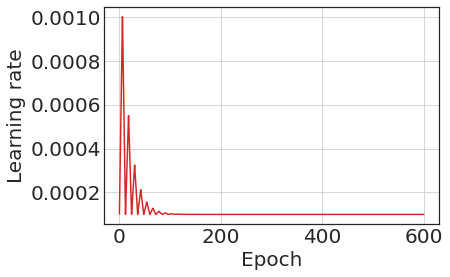

In [28]:
batches = np.linspace(0,len(metrics['lrs']),len(metrics['lrs'])+1)
epoch_list = batches/iterations_per_epoch

plt.plot(epoch_list[1:],metrics['lrs'], 'C3-')
plt.grid()
plt.ylabel("Learning rate")
plt.xlabel("Epoch")

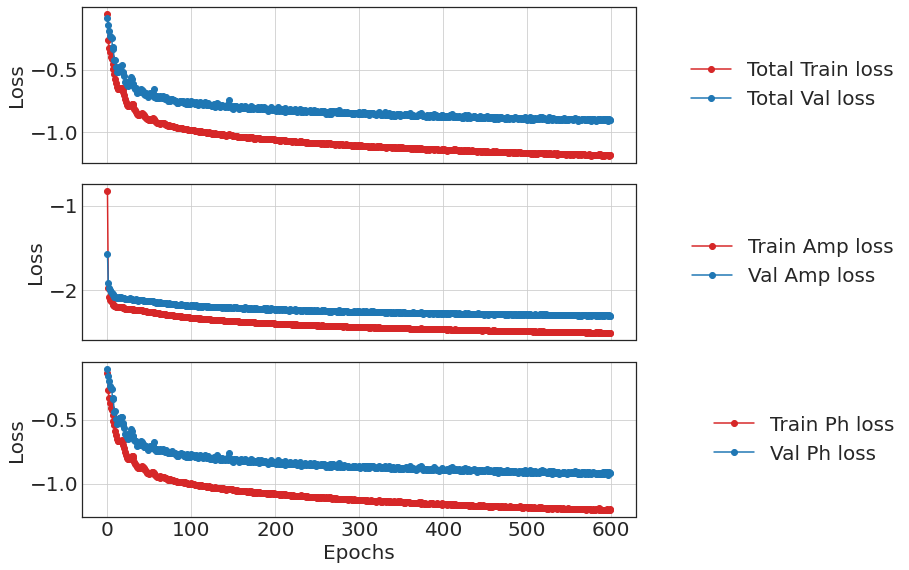

In [45]:
losses_arr = np.array(metrics['losses'])
val_losses_arr = np.array(metrics['val_losses'])
losses_arr.shape
fig, ax = plt.subplots(3,sharex=True, figsize=(15, 8))
ax[0].plot(np.log10(losses_arr[:,0]), 'C3o-', label = "Total Train loss")
ax[0].plot(np.log10(val_losses_arr[:,0]), 'C0o-', label = "Total Val loss")
ax[0].set(ylabel='Loss')
ax[0].grid()
ax[0].legend(loc='center right', bbox_to_anchor=(1.5, 0.5))
ax[1].plot(np.log10(losses_arr[:,1]), 'C3o-', label = "Train Amp loss")
ax[1].plot(np.log10(val_losses_arr[:,1]), 'C0o-', label = "Val Amp loss")
ax[1].set(ylabel='Loss')
ax[1].grid()
ax[1].legend(loc='center right', bbox_to_anchor=(1.5, 0.5))
ax[2].plot(np.log10(losses_arr[:,2]), 'C3o-', label = "Train Ph loss")
ax[2].plot(np.log10(val_losses_arr[:,2]), 'C0o-', label = "Val Ph loss")
ax[2].set(ylabel='Loss')
ax[2].grid()
ax[2].legend(loc='center right', bbox_to_anchor=(1.5, 0.5))

plt.tight_layout()
plt.xlabel("Epochs")

np.save(MODEL_SAVE_PATH + 'val_losses.npy', val_losses_arr)
np.save(MODEL_SAVE_PATH + 'train_losses.npy', losses_arr)

# Infer using LAST model

In [30]:
print ("Best model was at epoch:", val_losses_arr.argmin())

Best model was at epoch: 1798


In [31]:
model.eval() #imp when have dropout etc
amps_eval = []
phs_eval = []
for i, ft_images in enumerate(testloader):
    ft_images = ft_images[0].to(device)
    amp_eval, ph_eval = model(ft_images)
    for j in range(ft_images.shape[0]):
        amps_eval.append(amp_eval[j].detach().to("cpu").numpy())
        phs_eval.append(ph_eval[j].detach().to("cpu").numpy())

/home/mcherukara/miniconda3/envs/PyTorch/lib/python3.9/site-packages/torch/nn/functional.py:3631: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


In [32]:
amps_eval = np.array(amps_eval).squeeze()
phs_eval = np.array(phs_eval).squeeze()
print(amps_eval.shape, amps_eval.dtype)
print(phs_eval.shape, phs_eval.dtype)

(3600, 64, 64) float16
(3600, 64, 64) float16


<Figure size 432x288 with 0 Axes>

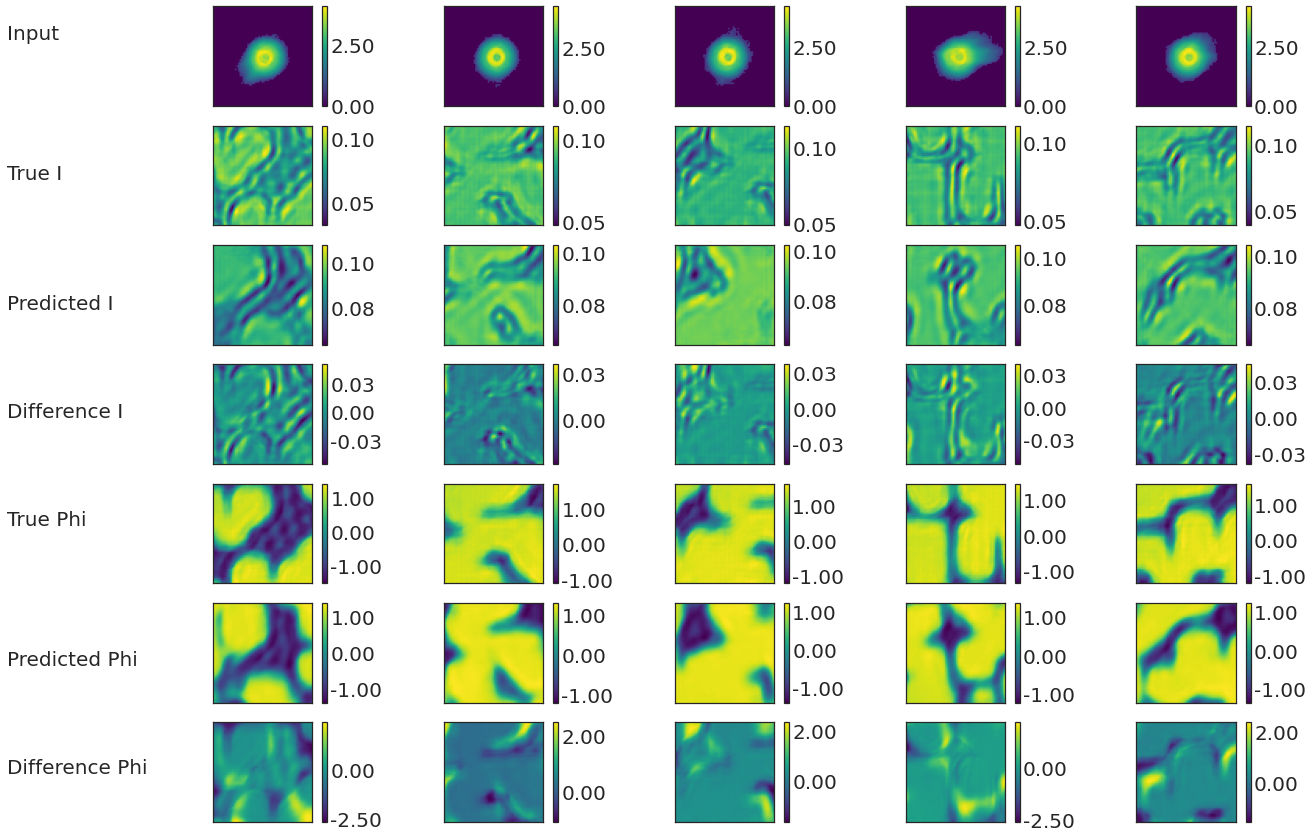

In [33]:
h,w = 64,64
ntest=amps_eval.shape[0]
plt.viridis()
n = 5
f,ax=plt.subplots(7,n,figsize=(20, 15))
plt.gcf().text(0.02, 0.85, "Input", fontsize=20)
plt.gcf().text(0.02, 0.72, "True I", fontsize=20)
plt.gcf().text(0.02, 0.6, "Predicted I", fontsize=20)
plt.gcf().text(0.02, 0.5, "Difference I", fontsize=20)
plt.gcf().text(0.02, 0.4, "True Phi", fontsize=20)
plt.gcf().text(0.02, 0.27, "Predicted Phi", fontsize=20)
plt.gcf().text(0.02, 0.17, "Difference Phi", fontsize=20)

for i in range(0,n):
    j=int(round(np.random.rand()*ntest))

        # display FT

    im=ax[0,i].imshow(np.log10(X_test[j].reshape(h, w)+1))
    plt.colorbar(im, ax=ax[0,i], format='%.2f')
    ax[0,i].get_xaxis().set_visible(False)
    ax[0,i].get_yaxis().set_visible(False)
    
    # display original intens
    im=ax[1,i].imshow(Y_I_test[j].reshape(h, w))
    plt.colorbar(im, ax=ax[1,i], format='%.2f')
    ax[1,i].get_xaxis().set_visible(False)
    ax[1,i].get_yaxis().set_visible(False)
    
    # display predicted intens
    im=ax[2,i].imshow(amps_eval[j].reshape(h, w).astype('float32'))
    plt.colorbar(im, ax=ax[2,i], format='%.2f')
    ax[2,i].get_xaxis().set_visible(False)
    ax[2,i].get_yaxis().set_visible(False)
    
        # display original phase
    im=ax[4,i].imshow(Y_phi_test[j].reshape(h, w))
    plt.colorbar(im, ax=ax[4,i], format='%.2f')
    ax[4,i].get_xaxis().set_visible(False)
    ax[4,i].get_yaxis().set_visible(False)
    
    # display predicted phase
    im=ax[5,i].imshow(phs_eval[j].reshape(h, w).astype('float32'))
    plt.colorbar(im, ax=ax[5,i], format='%.2f')
    ax[5,i].get_xaxis().set_visible(False)
    ax[5,i].get_yaxis().set_visible(False)
    
    
    #Difference in amplitude
    im=ax[3,i].imshow(Y_I_test[j].reshape(h, w) - amps_eval[j].reshape(h, w))
    plt.colorbar(im, ax=ax[3,i], format='%.2f')
    ax[3,i].get_xaxis().set_visible(False)
    ax[3,i].get_yaxis().set_visible(False)
    
    # Difference in phase
    im=ax[6,i].imshow(Y_phi_test[j].reshape(h, w) - phs_eval[j].reshape(h, w))
    plt.colorbar(im, ax=ax[6,i], format='%.2f')
    ax[6,i].get_xaxis().set_visible(False)
    ax[6,i].get_yaxis().set_visible(False)
    
plt.show()

In [34]:
point_size = 3
overlap = 4*point_size

In [35]:
tst_side = 60

composite_amp = np.zeros((tst_side*point_size+overlap,tst_side*point_size+overlap),float)
ctr = np.zeros_like(composite_amp)
data_reshaped = amps_eval.reshape(tst_side,tst_side,64,64)[:,:,32-int(overlap/2):32+int(overlap/2),
                                                     32-int(overlap/2):32+int(overlap/2)]

for i in range(tst_side):
    for j in range(tst_side):
        composite_amp[point_size*i:point_size*i+overlap, point_size*j:point_size*j+overlap] += data_reshaped[i,j]
        ctr[point_size*i:point_size*i+overlap, point_size*j:point_size*j+overlap] +=1

In [36]:

composite_phase = np.zeros((tst_side*point_size+overlap,tst_side*point_size+overlap),float)
ctr = np.zeros_like(composite_phase)
data_reshaped = phs_eval.reshape(tst_side,tst_side,64,64)[:,:,32-int(overlap/2):32+int(overlap/2),
                                                     32-int(overlap/2):32+int(overlap/2)]

for i in range(tst_side):
    for j in range(tst_side):
        composite_phase[point_size*i:point_size*i+overlap, point_size*j:point_size*j+overlap] += data_reshaped[i,j]
        ctr[point_size*i:point_size*i+overlap, point_size*j:point_size*j+overlap] +=1

In [37]:
stitched_phase = composite_phase[int(overlap/2):-int(overlap/2), int(overlap/2):-int(overlap/2)]/ctr[int(overlap/2)
                                                                    :-int(overlap/2), int(overlap/2):-int(overlap/2)]

stitched_amp = composite_amp[int(overlap/2):-int(overlap/2), int(overlap/2):-int(overlap/2)]/ctr[int(overlap/2)
                                                                    :-int(overlap/2), int(overlap/2):-int(overlap/2)]

stitched_amp_down = resize(stitched_amp, (60,60), preserve_range=True, anti_aliasing=True)
stitched_phase_down = resize(stitched_phase, (60,60), preserve_range=True, anti_aliasing=True)

In [38]:
true_amp = Y_I_test.reshape(NLTEST,NLTEST,64,64)
true_ph = Y_phi_test.reshape(NLTEST,NLTEST,64,64)

findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


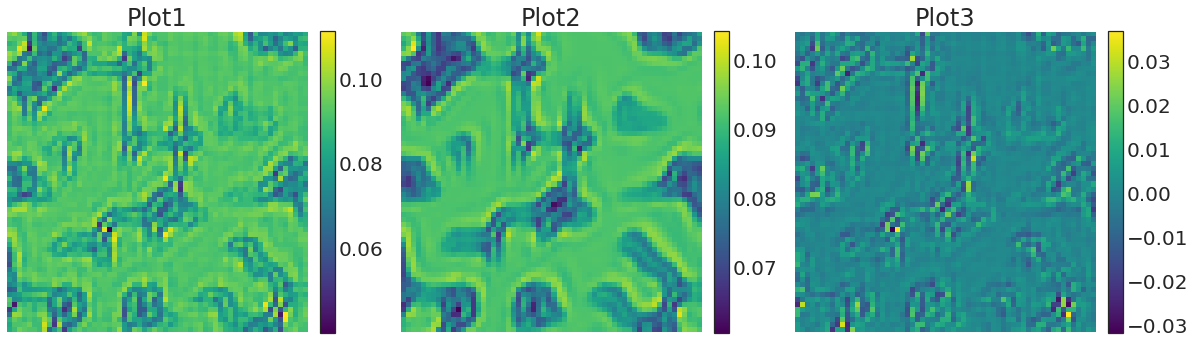

In [39]:
plot3([true_amp[:,:,32,32],stitched_amp_down,stitched_amp_down-true_amp[:,:,32,32]],[])

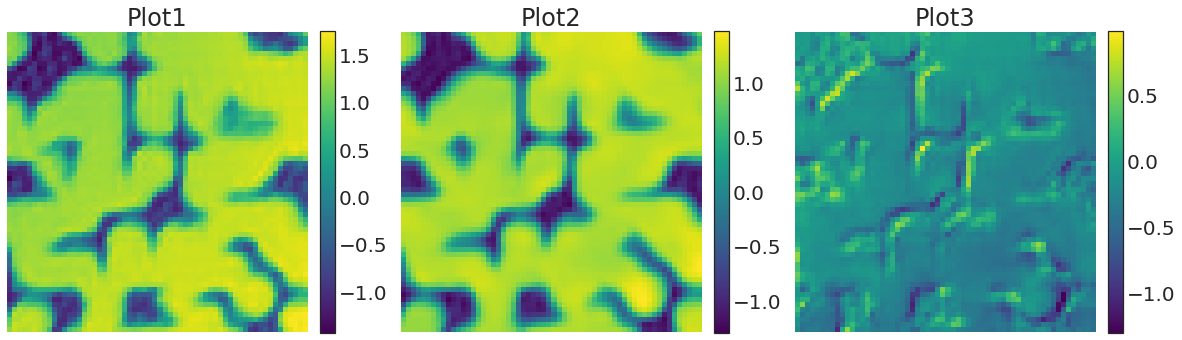

In [40]:
plot3([true_ph[:,:,32,32],stitched_phase_down,stitched_phase_down-true_ph[:,:,32,32]],[])

In [41]:
from sklearn.metrics import mean_squared_error as mse
from skimage.registration import phase_cross_correlation
print ("MSE in amplitude: ", mse(stitched_amp_down, true_amp[:,:,32,32]))
print ("MSE in phase: ", mse(stitched_phase_down, true_ph[:,:,32,32]))

MSE in amplitude:  3.913423403709007e-05
MSE in phase:  0.08752307481710557


In [42]:
true_img = true_amp * np.exp(1j * true_ph)
stitched_img = stitched_amp_down * np.exp(1j * stitched_phase_down)

In [43]:
_roll, _err, _phase = phase_cross_correlation(true_img[:,:,32, 32], stitched_img)
phase_cross_correlation(true_img[:,:,32,32], stitched_img * np.exp(1j * _phase))

(array([0., 0.]), 0.22018755089347475, 1.2157263171774999e-17)